In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVR, SVR
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,r2_score
from hyperopt import fmin, tpe, hp, Trials
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)
plt.style.use("ggplot")
sns.set_palette(sns.diverging_palette(220, 20))

Importing plotly failed. Interactive plots will not work.


# DATA VALIDATION

**train.csv:**
| Sütun      | Açıklama                                       |
|------------|------------------------------------------------|
| tarih      | Kesintinin gerçekleştiği tarih                 |
| ilce       | Kesintinin gerçekleştiği il-ilçe                |
| bildirimli_sum | Planlı kesinti sayısı                        |
| bildirimsiz_sum | Plansız kesinti sayısı (Tahmin edilecek hedef değişken 🎯) |

**test.csv:**
| Sütun      | Açıklama                                       |
|------------|------------------------------------------------|
| tarih      | Kesintinin gerçekleştiği tarih                 |
| ilce       | Kesintinin gerçekleştiği il-ilçe                |
| bildirimli_sum | Planlı kesinti sayısı                        |

**weather.csv:**
| Sütun      | Açıklama                                       |
|------------|------------------------------------------------|
| date       | Saatlik zaman                                  |
| lat        | Enlem                                          |
| lon        | Boylam                                         |
| t_2m:C     | Sıcaklık, Celcius                              |
| effective_cloud_cover:p | Bulutluluk                        |
| global_rad:W | Güneşlilik değeri, Watt                     |
| relative_humidity_2m:p | Bağıl nem                       |
| wind_dir_10m:d | Rüzgar yönü                                |
| wind_speed_10m:ms | Rüzgar hızı, m/s                         |
| prob_precip_1h:p | Yağış                                      |
| t_apparent:C | Hissedilen sıcaklık                            |
| ilce       | İl-İlçe ikilisi                                |

**holidays.csv:**
| Sütun      | Açıklama                                       |
|------------|------------------------------------------------|
| Yıl        | Yıl                                            |
| Ay         | Ay                                             |
| Gün        | Gün                                            |
| Bayram_Flag | Tatil adı                                      |

**sample_submission.csv:**
| Sütun      | Açıklama                                       |
|------------|------------------------------------------------|
| unique_id  | Test dönemindeki ilce ve tarih ikililerinden oluşturulmuş tekil id. |
| bildirimsiz_sum | Tahmin edilmesi gereken toplam plansız kesinti sayısı |


In [2]:
train = pd.read_csv("dataset/train.csv")
#train["tarih"] = pd.to_datetime(train["tarih"])
train["unique_id"] = train["tarih"].astype(str) +"-"+train["ilce"]
train.head()

tarih            ilce  bildirimsiz_sum  bildirimli_sum  \
0  2021-01-01  manisa-akhisar                9               0   
1  2021-01-02  manisa-akhisar               10               0   
2  2021-01-03  manisa-akhisar                5               2   
3  2021-01-04  manisa-akhisar                6               0   
4  2021-01-05  manisa-akhisar               15               4   

                   unique_id  
0  2021-01-01-manisa-akhisar  
1  2021-01-02-manisa-akhisar  
2  2021-01-03-manisa-akhisar  
3  2021-01-04-manisa-akhisar  
4  2021-01-05-manisa-akhisar

In [3]:
train.shape

(46944, 5)

In [4]:
test = pd.read_csv("dataset/test.csv")
#test["tarih"] = pd.to_datetime(test["tarih"])
test["bildirimsiz_sum"]=np.nan
test["unique_id"] = test["tarih"].astype(str) +"-"+test["ilce"]
test = test[train.columns.to_list()]
test.head()

tarih               ilce  bildirimsiz_sum  bildirimli_sum  \
0  2024-01-04     manisa-akhisar              NaN               0   
1  2024-01-04    manisa-alasehir              NaN               1   
2  2024-01-04     manisa-demirci              NaN               0   
3  2024-01-04  manisa-golmarmara              NaN               0   
4  2024-01-04      manisa-gordes              NaN               0   

                      unique_id  
0     2024-01-04-manisa-akhisar  
1    2024-01-04-manisa-alasehir  
2     2024-01-04-manisa-demirci  
3  2024-01-04-manisa-golmarmara  
4      2024-01-04-manisa-gordes

In [5]:
test.shape

(1316, 5)

In [6]:
sub = pd.read_csv("dataset/sample_submission.csv")
sub.head()

unique_id  bildirimsiz_sum
0     2024-01-04-manisa-akhisar              NaN
1    2024-01-04-manisa-alasehir              NaN
2     2024-01-04-manisa-demirci              NaN
3  2024-01-04-manisa-golmarmara              NaN
4      2024-01-04-manisa-gordes              NaN

In [7]:
sub.shape

(1316, 2)

**Train test birleştirme**

In [8]:
train_test_concat= pd.concat([train,test],axis=0)
train_test_concat.head()

tarih            ilce  bildirimsiz_sum  bildirimli_sum  \
0  2021-01-01  manisa-akhisar              9.0               0   
1  2021-01-02  manisa-akhisar             10.0               0   
2  2021-01-03  manisa-akhisar              5.0               2   
3  2021-01-04  manisa-akhisar              6.0               0   
4  2021-01-05  manisa-akhisar             15.0               4   

                   unique_id  
0  2021-01-01-manisa-akhisar  
1  2021-01-02-manisa-akhisar  
2  2021-01-03-manisa-akhisar  
3  2021-01-04-manisa-akhisar  
4  2021-01-05-manisa-akhisar

In [9]:
train_test_concat.shape

(48260, 5)

**Tatil verilerinin eklenmesi**

In [10]:
holidays=pd.read_csv("dataset/holidays.csv")
holidays["tarih"]=holidays[["Yıl","Ay","Gün"]].apply(lambda x : "-".join(x.astype(str)),axis=1)
holidays["tarih"] = pd.to_datetime(holidays["tarih"]).astype(str)
train_test_concat = train_test_concat.merge(holidays,how="left",on="tarih")
train_test_concat.drop(["Yıl","Ay","Gün"],inplace=True,axis=1)
train_test_concat.rename(columns={"Bayram_Flag":"flag"},inplace=True)
train_test_concat["flag"].fillna("Normal",inplace=True)
train_test_concat["flag"].replace({"Normal":"normal",
                                   "Kurban Bayramı":"kurban",
                                   "Ramazan Bayramı":"ramazan",
                                   "Yılbaşı":"yilbasi",
                                   "Demokrasi ve Millî Birlik Günü":"dvmbgunu",
                                   "Zafer Bayramı":"zafer",
                                   "Emek ve Dayanışma Günü":"evdgunu",
                                   "Atatürk'ü Anma, Gençlik ve Spor Bayramı":"spor",
                                   "Cumhuriyet Bayramı":"cumhuriyet",
                                   "Ulusal Egemenlik ve Çocuk Bayramı":"cocuk",
                                   "Ramazan Bayramı; Ulusal Egemenlik ve Çocuk Bayramı":"ramazan_cocuk"
                                   },inplace=True)
train_test_concat[train_test_concat["flag"]=="cocuk"].head()

tarih             ilce  bildirimsiz_sum  bildirimli_sum  \
112   2021-04-23   manisa-akhisar              9.0               0   
477   2022-04-23   manisa-akhisar             10.0               3   
1210  2021-04-23  manisa-alasehir              5.0               0   
1573  2022-04-23  manisa-alasehir              9.0               0   
2293  2021-04-23   manisa-demirci              1.0               0   

                       unique_id   flag  
112    2021-04-23-manisa-akhisar  cocuk  
477    2022-04-23-manisa-akhisar  cocuk  
1210  2021-04-23-manisa-alasehir  cocuk  
1573  2022-04-23-manisa-alasehir  cocuk  
2293   2021-04-23-manisa-demirci  cocuk

In [11]:
train_test_concat["flag"].value_counts()

flag
normal           46588
kurban             484
ramazan            302
yilbasi            154
dvmbgunu           132
zafer              127
evdgunu            124
spor               122
cumhuriyet         116
cocuk               78
ramazan_cocuk       33
Name: count, dtype: int64

In [12]:
train_test_concat.shape

(48260, 6)

In [13]:
holidays["tarih"].max()

'2024-10-29'

In [14]:
holidays["tarih"].min()

'2021-01-01'

**Hava Durumu verilerinin incelenmesi**

In [15]:
weather=pd.read_csv("dataset/weather.csv")
weather_columns=weather.columns.to_list()
weather_columns = ['tarih','lat','long','temp','cloud_cover','global_rad','relative_humidity','wind_dir','wind_speed','precip','temp_app','ilce']
weather.columns = weather_columns
weather["tarih"] = weather["tarih"].str[:10]
weather.head()

tarih      lat     long  temp  cloud_cover  global_rad  \
0  2021-01-01  38.7996  26.9707  13.8         40.2         0.0   
1  2021-01-01  38.7996  26.9707  13.5         56.8         0.0   
2  2021-01-01  38.7996  26.9707  13.3         71.6         0.0   
3  2021-01-01  38.7996  26.9707  12.9         69.8         0.0   
4  2021-01-01  38.7996  26.9707  12.6         56.3         0.0   

   relative_humidity  wind_dir  wind_speed  precip  temp_app          ilce  
0               80.0     168.3         6.0     1.0      13.4  izmir-aliaga  
1               83.0     173.3         5.9     1.0      13.1  izmir-aliaga  
2               83.9     176.7         5.2     1.0      13.1  izmir-aliaga  
3               88.3     183.1         5.6     1.0      12.8  izmir-aliaga  
4               90.0     166.9         6.4     1.0      12.4  izmir-aliaga

**Hava durumu sayısal değişkenlerinin incelenmesi**

In [16]:
def single_variable_multiple_plot(data,numeric=True):
    """
    Veri setindeki tek bir sayısal değişken için histogram, boxplot grafiği ve çekirdek yoğunluk grafiği.
    Kategorik değişken için countplot grafiği ve pasta grafiği kullanarak görselleştirir.

    Parametreler:
    data : DataFrame Veri kümesi.
    type : str, opsiyonel, Sayısal değişkenlerin veri tipi. Varsayılan 'float64'tür.
    numeric : bool, opsiyonel, True ise, grafikler sayısal değişkenler için oluşturulur; False ise, grafikler kategorik değişkenler için oluşturulur. Varsayılan True'dur.

    Returns:
    None
    """
 
    if numeric: 
         numeric_columns= [col for col in data.columns if data[col].dtype in ["float64","int64","float32","int32"]]
         for i in numeric_columns:
            fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,4))
            sns.histplot(x=data[i],bins=10,ax=axes[0])
            axes[0].set_title(i)
            sns.boxplot(x=data[i],ax=axes[1])
            axes[1].set_title(i)
            sns.kdeplot(x=data[i],ax=axes[2])
            axes[2].set_title(i)
            plt.show()
    
    else:
         categoric_columns= [col for col in data.columns if data[col].dtype in ["object","category"]]
         for i in categoric_columns:
            fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(16,8))
            sns.countplot(data=data, x=i,order=data[i].value_counts().index, ax=axes[0])
            axes[0].set_title(i)
            axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
            plt.pie(data[i].value_counts(), autopct='%1.1f%%',labels=data[i].value_counts().index)
            axes[1].set_title(i)
            axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
            plt.tight_layout()
            plt.show()

In [17]:
# single_variable_multiple_plot(weather,numeric=True)

In [18]:
weather.describe().T

count        mean         std      min      25%  \
lat                1314120.0   38.535130    0.303275  37.9508  38.3250   
long               1314120.0   27.526583    0.634262  26.3032  27.0697   
temp               1314120.0   17.209120    8.739404 -12.6000  10.8000   
cloud_cover        1314120.0   29.953475   34.512810   0.0000   0.0000   
global_rad         1314120.0  200.078562  278.994473   0.0000   0.0000   
relative_humidity  1314120.0   64.113455   20.443409   5.6000  49.5000   
wind_dir           1314120.0  158.241502  120.008239   0.0000  42.6000   
wind_speed         1314120.0    2.714519    1.913408   0.0000   1.3000   
precip             1314120.0    3.131745   11.168032   1.0000   1.0000   
temp_app           1314120.0   18.401119   10.323124 -17.8000  11.4000   

                        50%       75%        max  
lat                 38.4710   38.7375    39.1881  
long                27.3818   27.9748    28.8693  
temp                16.6000   23.6000    44.8000  
cloud_cover         12.9000   53.9000   100.0000  
global_rad           0.0000  375.5000  1026.3000  
relative_humidity   66.2000   80.4000   100.0000  
wind_dir           141.5000  278.6000   360.0000  
wind_speed           2.2000    3.7000    18.4000  
precip               1.0000    1.0000    95.0000  
temp_app            17.9000   25.1000    52.0000

**Hava durumu verilerini agg ile günlük formata çevirme**

In [19]:
#Hissedilen ve ölçülen sıcaklık farkı
weather["temp_measure_app_diff"] = weather["temp_app"] - weather["temp"]
weather_group = weather.groupby(["tarih","ilce"]).agg({"lat":"first",
                                                        "long":"first",
                                                        "temp":"max",
                                                        "cloud_cover":"max",
                                                        "global_rad":"max",
                                                        "relative_humidity":"max",
                                                        "wind_dir":"mean",
                                                        "wind_speed":"max",
                                                        "precip":"max",
                                                        "temp_app":"max",
                                                        "temp_measure_app_diff":"max"}).reset_index()
weather_group["wind_dir"] = round(weather_group["wind_dir"],1)
weather_group.head()

tarih            ilce      lat     long  temp  cloud_cover  \
0  2021-01-01    izmir-aliaga  38.7996  26.9707  15.8         97.1   
1  2021-01-01   izmir-balcova  38.3891  27.0500  15.0         92.6   
2  2021-01-01  izmir-bayindir  38.2178  27.6478  14.5         94.5   
3  2021-01-01  izmir-bayrakli  38.4612  27.1881  15.1         87.4   
4  2021-01-01   izmir-bergama  39.1214  27.1799  15.0         97.0   

   global_rad  relative_humidity  wind_dir  wind_speed  precip  temp_app  \
0       338.4               91.8     167.2         6.4     1.0      18.6   
1       291.2               93.3     145.4         4.5     7.9      17.8   
2       248.8               94.4      58.5         2.3     1.0      17.6   
3       282.1               97.1     141.8         3.5     3.7      17.9   
4       303.2               93.7     186.4         3.0     1.0      17.9   

   temp_measure_app_diff  
0                    3.0  
1                    3.0  
2                    3.4  
3                    2.9  
4                    3.2

In [20]:
weather_group.loc[(weather_group["tarih"]=="2021-01-01")&(weather_group["ilce"]=="izmir-aliaga"),weather_group.columns.to_list()]

tarih          ilce      lat     long  temp  cloud_cover  global_rad  \
0  2021-01-01  izmir-aliaga  38.7996  26.9707  15.8         97.1       338.4   

   relative_humidity  wind_dir  wind_speed  precip  temp_app  \
0               91.8     167.2         6.4     1.0      18.6   

   temp_measure_app_diff  
0                    3.0

In [21]:
weather_group.shape

(54755, 13)

**Train test concat tarih aralıklarına göre hava durumu verilerini alma**

In [22]:
start_date = train_test_concat["tarih"].astype(str).min()
end_date = train_test_concat["tarih"].astype(str).max()
weather_group_date_range = weather_group[(weather_group['tarih'] >= start_date) & (weather_group['tarih'] <= end_date)]
weather_group_date_range.head()


tarih            ilce      lat     long  temp  cloud_cover  \
0  2021-01-01    izmir-aliaga  38.7996  26.9707  15.8         97.1   
1  2021-01-01   izmir-balcova  38.3891  27.0500  15.0         92.6   
2  2021-01-01  izmir-bayindir  38.2178  27.6478  14.5         94.5   
3  2021-01-01  izmir-bayrakli  38.4612  27.1881  15.1         87.4   
4  2021-01-01   izmir-bergama  39.1214  27.1799  15.0         97.0   

   global_rad  relative_humidity  wind_dir  wind_speed  precip  temp_app  \
0       338.4               91.8     167.2         6.4     1.0      18.6   
1       291.2               93.3     145.4         4.5     7.9      17.8   
2       248.8               94.4      58.5         2.3     1.0      17.6   
3       282.1               97.1     141.8         3.5     3.7      17.9   
4       303.2               93.7     186.4         3.0     1.0      17.9   

   temp_measure_app_diff  
0                    3.0  
1                    3.0  
2                    3.4  
3                    2.9  
4                    3.2

In [23]:
weather_group_date_range["tarih"].min()

'2021-01-01'

In [24]:
weather_group_date_range["tarih"].max()

'2024-01-31'

In [25]:
weather_group_date_range.shape

(52922, 13)

In [26]:
train_test_concat["tarih"].min()

'2021-01-01'

In [27]:
train_test_concat["tarih"].max()

'2024-01-31'

In [28]:
train_test_concat.shape

(48260, 6)

In [29]:
weather_group_date_range.head()

tarih            ilce      lat     long  temp  cloud_cover  \
0  2021-01-01    izmir-aliaga  38.7996  26.9707  15.8         97.1   
1  2021-01-01   izmir-balcova  38.3891  27.0500  15.0         92.6   
2  2021-01-01  izmir-bayindir  38.2178  27.6478  14.5         94.5   
3  2021-01-01  izmir-bayrakli  38.4612  27.1881  15.1         87.4   
4  2021-01-01   izmir-bergama  39.1214  27.1799  15.0         97.0   

   global_rad  relative_humidity  wind_dir  wind_speed  precip  temp_app  \
0       338.4               91.8     167.2         6.4     1.0      18.6   
1       291.2               93.3     145.4         4.5     7.9      17.8   
2       248.8               94.4      58.5         2.3     1.0      17.6   
3       282.1               97.1     141.8         3.5     3.7      17.9   
4       303.2               93.7     186.4         3.0     1.0      17.9   

   temp_measure_app_diff  
0                    3.0  
1                    3.0  
2                    3.4  
3                    2.9  
4                    3.2

In [30]:
train_test_concat.loc[(train_test_concat["tarih"]=="2021-01-01")&((train_test_concat["ilce"]=="izmir-aliaga"))]

tarih          ilce  bildirimsiz_sum  bildirimli_sum  \
14892  2021-01-01  izmir-aliaga              5.0               0   

                     unique_id     flag  
14892  2021-01-01-izmir-aliaga  yilbasi

In [31]:
weather_group_date_range.loc[(weather_group_date_range["tarih"]=="2021-01-01")&(weather_group_date_range["ilce"]=="izmir-aliaga"),weather_group_date_range.columns.to_list()]

tarih          ilce      lat     long  temp  cloud_cover  global_rad  \
0  2021-01-01  izmir-aliaga  38.7996  26.9707  15.8         97.1       338.4   

   relative_humidity  wind_dir  wind_speed  precip  temp_app  \
0               91.8     167.2         6.4     1.0      18.6   

   temp_measure_app_diff  
0                    3.0

**Hava durumu verilerinin birleştirilmesi**

In [32]:
train_test_concat = train_test_concat.merge(weather_group_date_range,how= "left", on=["tarih","ilce"])
train_test_concat.head()

tarih            ilce  bildirimsiz_sum  bildirimli_sum  \
0  2021-01-01  manisa-akhisar              9.0               0   
1  2021-01-02  manisa-akhisar             10.0               0   
2  2021-01-03  manisa-akhisar              5.0               2   
3  2021-01-04  manisa-akhisar              6.0               0   
4  2021-01-05  manisa-akhisar             15.0               4   

                   unique_id     flag      lat     long  temp  cloud_cover  \
0  2021-01-01-manisa-akhisar  yilbasi  38.9177  27.8366  14.9         75.0   
1  2021-01-02-manisa-akhisar   normal  38.9177  27.8366  17.1         49.6   
2  2021-01-03-manisa-akhisar   normal  38.9177  27.8366  14.5         99.8   
3  2021-01-04-manisa-akhisar   normal  38.9177  27.8366  17.5         95.5   
4  2021-01-05-manisa-akhisar   normal  38.9177  27.8366  15.6        100.0   

   global_rad  relative_humidity  wind_dir  wind_speed  precip  temp_app  \
0       283.5               94.3     133.6         2.1     1.0      17.8   
1       437.6               95.7     100.6         1.4     1.0      20.2   
2       236.1               95.0     122.5         1.7     1.0      16.3   
3       442.3               96.3      90.2         2.7    30.4      19.2   
4       375.1               90.2     160.1         3.1    53.9      18.6   

   temp_measure_app_diff  
0                    3.5  
1                    4.2  
2                    2.7  
3                    3.5  
4                    3.4

In [33]:
# kontrol
train_test_concat.loc[(train_test_concat["tarih"]=="2021-01-01")&(train_test_concat["ilce"]=="izmir-aliaga"),train_test_concat.columns.to_list()]

tarih          ilce  bildirimsiz_sum  bildirimli_sum  \
14892  2021-01-01  izmir-aliaga              5.0               0   

                     unique_id     flag      lat     long  temp  cloud_cover  \
14892  2021-01-01-izmir-aliaga  yilbasi  38.7996  26.9707  15.8         97.1   

       global_rad  relative_humidity  wind_dir  wind_speed  precip  temp_app  \
14892       338.4               91.8     167.2         6.4     1.0      18.6   

       temp_measure_app_diff  
14892                    3.0

**Hava durumu verilerini agg min ile günlük formata çevirme**

In [34]:
weather_group_min = weather.groupby(["tarih","ilce"]).agg({
                                                        "cloud_cover":"min",
                                                        "relative_humidity":"min",
                                                        "wind_speed":"min",
                                                        "precip":"min"}).reset_index()
weather_group_min.columns = ["tarih","ilce","cloud_cover_min","relative_humidity_min","wind_speed_min","precip_min"]
weather_group_min.head()

tarih            ilce  cloud_cover_min  relative_humidity_min  \
0  2021-01-01    izmir-aliaga             24.7                   75.7   
1  2021-01-01   izmir-balcova             28.0                   81.8   
2  2021-01-01  izmir-bayindir             35.3                   83.5   
3  2021-01-01  izmir-bayrakli             29.6                   83.5   
4  2021-01-01   izmir-bergama             29.2                   72.0   

   wind_speed_min  precip_min  
0             1.8         1.0  
1             2.3         1.0  
2             0.5         1.0  
3             1.5         1.0  
4             0.5         1.0

In [35]:
start_date = train_test_concat["tarih"].astype(str).min()
end_date = train_test_concat["tarih"].astype(str).max()
weather_group_date_range_min = weather_group_min[(weather_group_min["tarih"] >= start_date) & (weather_group_min["tarih"] <= end_date)]
weather_group_date_range_min.head()

tarih            ilce  cloud_cover_min  relative_humidity_min  \
0  2021-01-01    izmir-aliaga             24.7                   75.7   
1  2021-01-01   izmir-balcova             28.0                   81.8   
2  2021-01-01  izmir-bayindir             35.3                   83.5   
3  2021-01-01  izmir-bayrakli             29.6                   83.5   
4  2021-01-01   izmir-bergama             29.2                   72.0   

   wind_speed_min  precip_min  
0             1.8         1.0  
1             2.3         1.0  
2             0.5         1.0  
3             1.5         1.0  
4             0.5         1.0

In [36]:
train_test_concat = train_test_concat.merge(weather_group_date_range_min,how= "left", on=["tarih","ilce"])
train_test_concat.head()

tarih            ilce  bildirimsiz_sum  bildirimli_sum  \
0  2021-01-01  manisa-akhisar              9.0               0   
1  2021-01-02  manisa-akhisar             10.0               0   
2  2021-01-03  manisa-akhisar              5.0               2   
3  2021-01-04  manisa-akhisar              6.0               0   
4  2021-01-05  manisa-akhisar             15.0               4   

                   unique_id     flag      lat     long  temp  cloud_cover  \
0  2021-01-01-manisa-akhisar  yilbasi  38.9177  27.8366  14.9         75.0   
1  2021-01-02-manisa-akhisar   normal  38.9177  27.8366  17.1         49.6   
2  2021-01-03-manisa-akhisar   normal  38.9177  27.8366  14.5         99.8   
3  2021-01-04-manisa-akhisar   normal  38.9177  27.8366  17.5         95.5   
4  2021-01-05-manisa-akhisar   normal  38.9177  27.8366  15.6        100.0   

   global_rad  relative_humidity  wind_dir  wind_speed  precip  temp_app  \
0       283.5               94.3     133.6         2.1     1.0      17.8   
1       437.6               95.7     100.6         1.4     1.0      20.2   
2       236.1               95.0     122.5         1.7     1.0      16.3   
3       442.3               96.3      90.2         2.7    30.4      19.2   
4       375.1               90.2     160.1         3.1    53.9      18.6   

   temp_measure_app_diff  cloud_cover_min  relative_humidity_min  \
0                    3.5             30.5                   78.6   
1                    4.2              3.3                   52.7   
2                    2.7              1.3                   57.3   
3                    3.5              7.7                   41.9   
4                    3.4              8.0                   61.6   

   wind_speed_min  precip_min  
0             0.2         1.0  
1             0.4         1.0  
2             0.2         1.0  
3             0.5         1.0  
4             0.9         1.0

In [37]:
train_test_concat.isnull().sum()

tarih                       0
ilce                        0
bildirimsiz_sum          1316
bildirimli_sum              0
unique_id                   0
flag                        0
lat                         0
long                        0
temp                        0
cloud_cover                 0
global_rad                  0
relative_humidity           0
wind_dir                    0
wind_speed                  0
precip                      0
temp_app                    0
temp_measure_app_diff       0
cloud_cover_min             0
relative_humidity_min       0
wind_speed_min              0
precip_min                  0
dtype: int64

In [38]:
train_test_concat.shape

(48260, 21)

**Keşifsel Veri Analizi - EDA**

**Kategorik Değişkenlerin Analizi**

**Target değişkene göre(bildirimsiz_sum) İl ve İlçe bazlı analiz**

In [39]:
train_test_concat.rename(columns={"ilce":"il_ilce"},inplace=True)
train_test_concat[["il","ilce"]] =  train_test_concat["il_ilce"].str.split("-",expand=True)
train_test_concat.head()

tarih         il_ilce  bildirimsiz_sum  bildirimli_sum  \
0  2021-01-01  manisa-akhisar              9.0               0   
1  2021-01-02  manisa-akhisar             10.0               0   
2  2021-01-03  manisa-akhisar              5.0               2   
3  2021-01-04  manisa-akhisar              6.0               0   
4  2021-01-05  manisa-akhisar             15.0               4   

                   unique_id     flag      lat     long  temp  cloud_cover  \
0  2021-01-01-manisa-akhisar  yilbasi  38.9177  27.8366  14.9         75.0   
1  2021-01-02-manisa-akhisar   normal  38.9177  27.8366  17.1         49.6   
2  2021-01-03-manisa-akhisar   normal  38.9177  27.8366  14.5         99.8   
3  2021-01-04-manisa-akhisar   normal  38.9177  27.8366  17.5         95.5   
4  2021-01-05-manisa-akhisar   normal  38.9177  27.8366  15.6        100.0   

   global_rad  relative_humidity  wind_dir  wind_speed  precip  temp_app  \
0       283.5               94.3     133.6         2.1     1.0      17.8   
1       437.6               95.7     100.6         1.4     1.0      20.2   
2       236.1               95.0     122.5         1.7     1.0      16.3   
3       442.3               96.3      90.2         2.7    30.4      19.2   
4       375.1               90.2     160.1         3.1    53.9      18.6   

   temp_measure_app_diff  cloud_cover_min  relative_humidity_min  \
0                    3.5             30.5                   78.6   
1                    4.2              3.3                   52.7   
2                    2.7              1.3                   57.3   
3                    3.5              7.7                   41.9   
4                    3.4              8.0                   61.6   

   wind_speed_min  precip_min      il     ilce  
0             0.2         1.0  manisa  akhisar  
1             0.4         1.0  manisa  akhisar  
2             0.2         1.0  manisa  akhisar  
3             0.5         1.0  manisa  akhisar  
4             0.9         1.0  manisa  akhisar

In [40]:
train_test_concat["il"].value_counts()

il
izmir     31279
manisa    16981
Name: count, dtype: int64

- İzmir ve Manisa ilçe sayıları

In [41]:
train_test_concat.groupby("il").agg({"ilce":pd.Series.nunique}).reset_index()

il  ilce
0   izmir    30
1  manisa    17

- izmirde büyüklük ve nufus yoğunluğuda göz önünde bulundurulduğunda kesintiler daha fazla

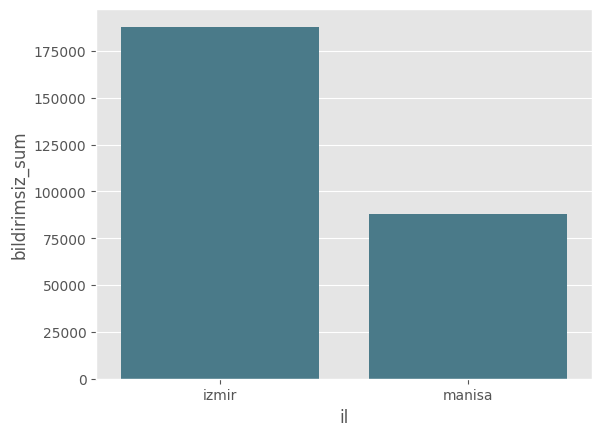

In [42]:
il_group=train_test_concat.groupby("il")["bildirimsiz_sum"].sum().reset_index()
sns.barplot(x="il",y="bildirimsiz_sum",data=il_group)
plt.show()

**İl ve İlçe kesinti toplam sayıları**
- İzmir ilinde toplam kesinti sayısının en fazla olduğu ilk  3 ilçe çeşme, ödemiş ve konak iken en az olan 3 ilçe narlıdere, beydağ ve balçova ilçeleridir.
- Manisa ilinde toplam kesinti sayısının en fazla olduğu ilk  3 ilçe yunusemre, salihli ve akhisar iken en az olan 3 ilçe köprübaşı, ahmetli ve gölmarmara ilçeleridir.

In [43]:
sorted_df = train_test_concat.groupby(["il", "ilce"])["bildirimsiz_sum"].sum().reset_index().sort_values(by=["il", "bildirimsiz_sum"], ascending=[True, False])
sorted_df["il_ilce"] = sorted_df["il"] + "-" + sorted_df["ilce"]
sorted_df = sorted_df.drop(columns=["il", "ilce"])
sorted_df = sorted_df[["il_ilce", "bildirimsiz_sum"]].reset_index(drop=True)
sorted_df.head()

il_ilce  bildirimsiz_sum
0    izmir-cesme          14189.0
1   izmir-odemis          11543.0
2    izmir-konak          10437.0
3  izmir-bornova          10382.0
4     izmir-urla          10125.0

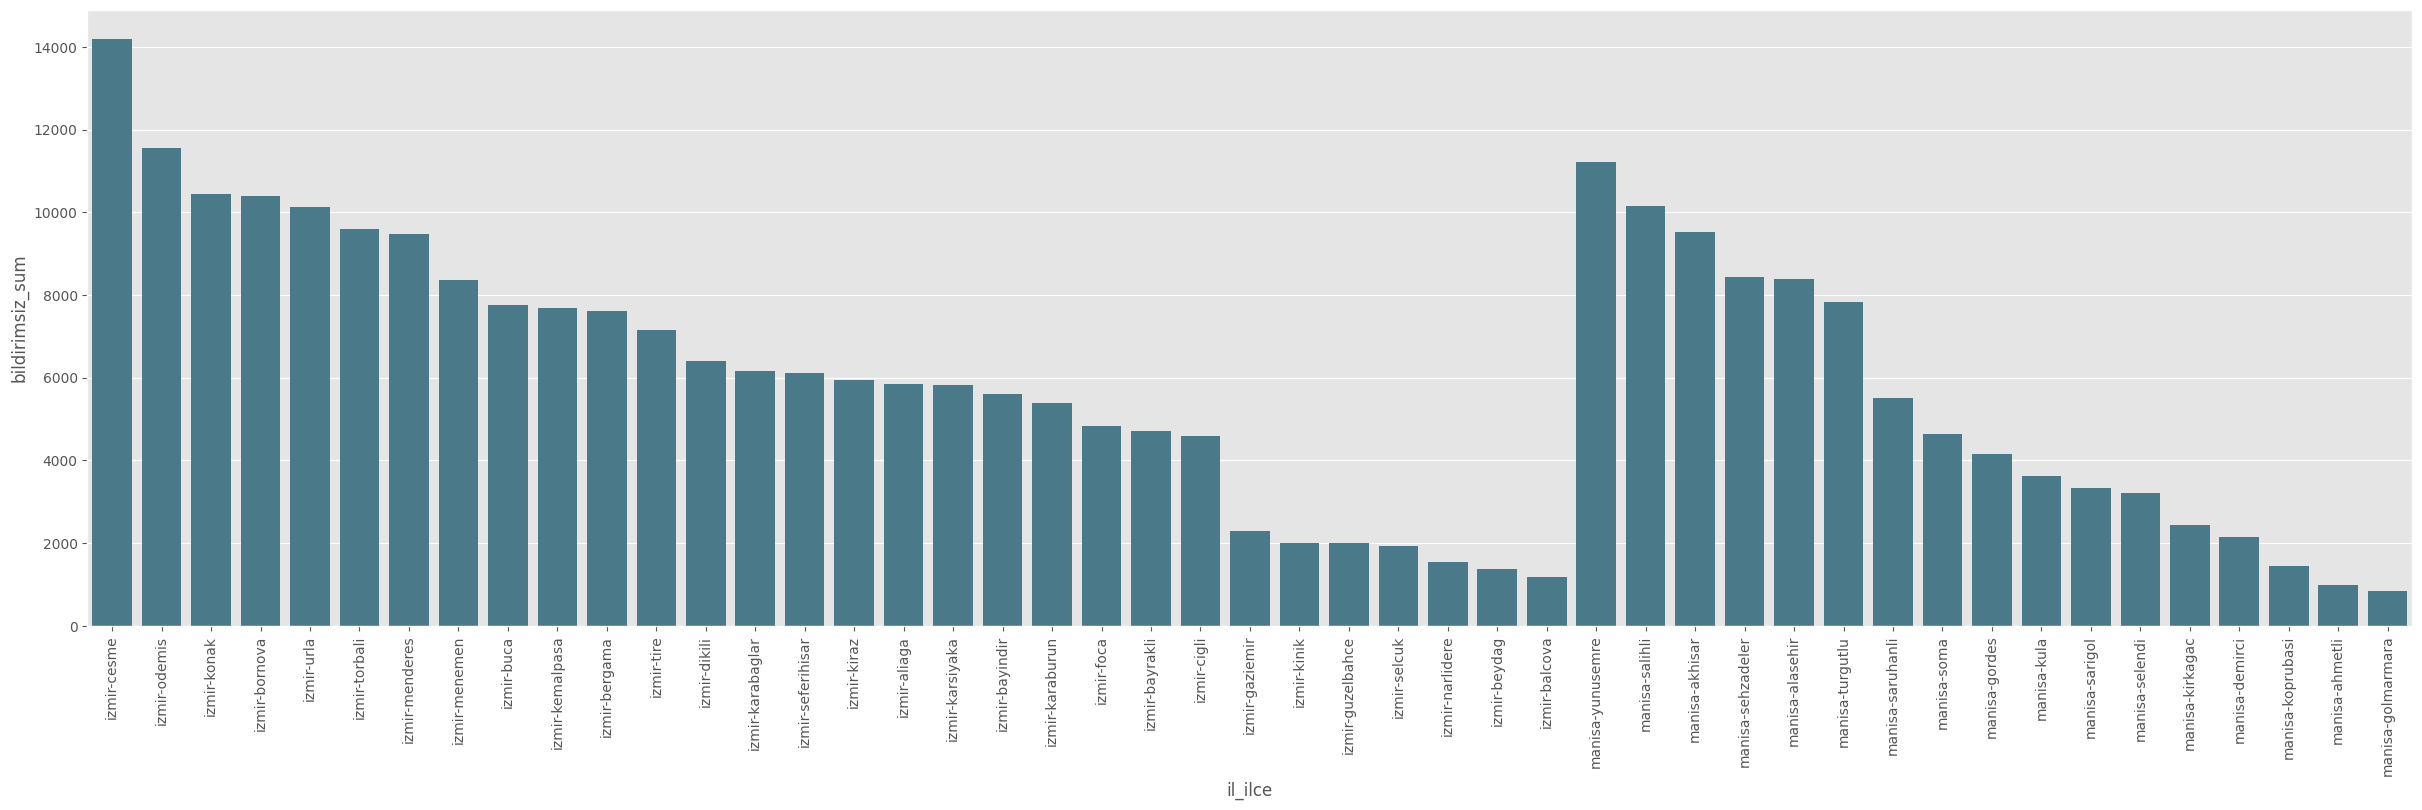

In [44]:
plt.figure(figsize=(30, 8))
sns.barplot(x="il_ilce", y="bildirimsiz_sum", data=sorted_df)
plt.xticks(rotation=90)
plt.show()

**il ve ilçe bazlı elektrik kesintilerinin toplam kesintiye oranı değişkeninin veri setine eklenmesi**

In [45]:
sorted_df["blackout_ratio_per_city_county"] = sorted_df["bildirimsiz_sum"] / sorted_df["bildirimsiz_sum"].sum()
sorted_df.drop("bildirimsiz_sum",inplace=True,axis=1)
sorted_series = sorted_df.set_index("il_ilce")["blackout_ratio_per_city_county"]
train_test_concat["blackout_ratio_per_city_county"] = train_test_concat["il_ilce"].map(sorted_series)
train_test_concat.head()

tarih         il_ilce  bildirimsiz_sum  bildirimli_sum  \
0  2021-01-01  manisa-akhisar              9.0               0   
1  2021-01-02  manisa-akhisar             10.0               0   
2  2021-01-03  manisa-akhisar              5.0               2   
3  2021-01-04  manisa-akhisar              6.0               0   
4  2021-01-05  manisa-akhisar             15.0               4   

                   unique_id     flag      lat     long  temp  cloud_cover  \
0  2021-01-01-manisa-akhisar  yilbasi  38.9177  27.8366  14.9         75.0   
1  2021-01-02-manisa-akhisar   normal  38.9177  27.8366  17.1         49.6   
2  2021-01-03-manisa-akhisar   normal  38.9177  27.8366  14.5         99.8   
3  2021-01-04-manisa-akhisar   normal  38.9177  27.8366  17.5         95.5   
4  2021-01-05-manisa-akhisar   normal  38.9177  27.8366  15.6        100.0   

   global_rad  relative_humidity  wind_dir  wind_speed  precip  temp_app  \
0       283.5               94.3     133.6         2.1     1.0      17.8   
1       437.6               95.7     100.6         1.4     1.0      20.2   
2       236.1               95.0     122.5         1.7     1.0      16.3   
3       442.3               96.3      90.2         2.7    30.4      19.2   
4       375.1               90.2     160.1         3.1    53.9      18.6   

   temp_measure_app_diff  cloud_cover_min  relative_humidity_min  \
0                    3.5             30.5                   78.6   
1                    4.2              3.3                   52.7   
2                    2.7              1.3                   57.3   
3                    3.5              7.7                   41.9   
4                    3.4              8.0                   61.6   

   wind_speed_min  precip_min      il     ilce  blackout_ratio_per_city_county  
0             0.2         1.0  manisa  akhisar                         0.03451  
1             0.4         1.0  manisa  akhisar                         0.03451  
2             0.2         1.0  manisa  akhisar                         0.03451  
3             0.5         1.0  manisa  akhisar                         0.03451  
4             0.9         1.0  manisa  akhisar                         0.03451

- Kontrol

In [46]:
sorted_df.head(1)

il_ilce  blackout_ratio_per_city_county
0  izmir-cesme                        0.051435

In [47]:
train_test_concat.loc[train_test_concat["il_ilce"]=="izmir-cesme","blackout_ratio_per_city_county"].head(1)

39144    0.051435
Name: blackout_ratio_per_city_county, dtype: float64

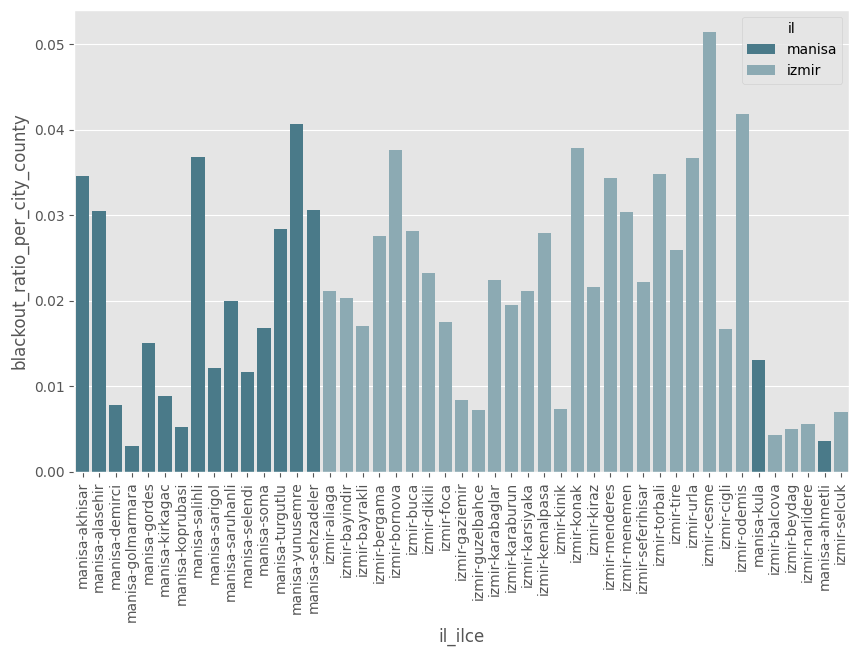

In [48]:
plt.figure(figsize=(10, 6))
sns.barplot(x="il_ilce", y="blackout_ratio_per_city_county",data=train_test_concat,hue="il")
plt.xticks(rotation=90)
plt.show()

**Planlı kesintiye göre (bildirimli_sum) İl ve İlçe bazlı analiz**

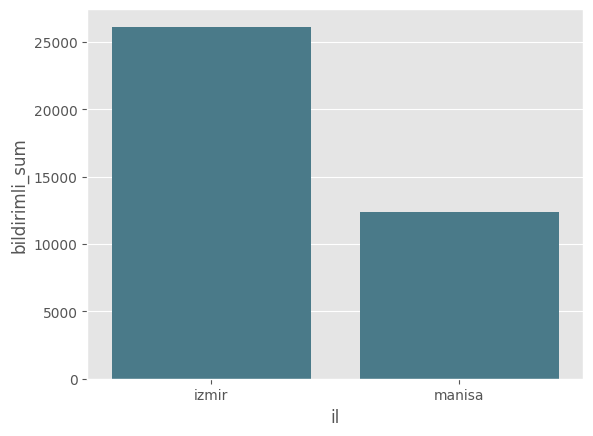

In [49]:
il_group=train_test_concat.groupby("il")["bildirimli_sum"].sum().reset_index()
sns.barplot(x="il",y="bildirimli_sum",data=il_group)
plt.show()

**İl ve İlçe planlı kesinti toplam sayıları**
- İzmir ilinde toplam planlı kesinti sayısının en fazla olduğu ilk  3 ilçe bornova, ödemiş ve konak iken en az olan 3 ilçe kınık, balçova ve beydağ ilçeleridir. Planlı kesintide bornova ilk sıraya gelmiştir.
- Manisa ilinde toplam planlı kesinti sayısının en fazla olduğu ilk  3 ilçe akhisar, yunusemre, salihli iken en az olan 3 ilçe selendi, ahmetli ve gölmarmara ilçeleridir. Burdada ilk sıraya akhisar gelmiştir.
- Planlı kesintinin olduğu yerlerde altyapı çalışmaları olabilir.

In [50]:
sorted_df_planli = train_test_concat.groupby(["il", "ilce"])["bildirimli_sum"].sum().reset_index().sort_values(by=["il", "bildirimli_sum"], ascending=[True, False])
sorted_df_planli["il_ilce"] = sorted_df_planli["il"] + "-" + sorted_df_planli["ilce"]
sorted_df_planli = sorted_df_planli.drop(columns=["il", "ilce"])
sorted_df_planli = sorted_df_planli[["il_ilce", "bildirimli_sum"]].reset_index(drop=True)
sorted_df_planli.head()

il_ilce  bildirimli_sum
0  izmir-bornova            1953
1   izmir-odemis            1823
2    izmir-konak            1357
3     izmir-buca            1344
4  izmir-torbali            1236

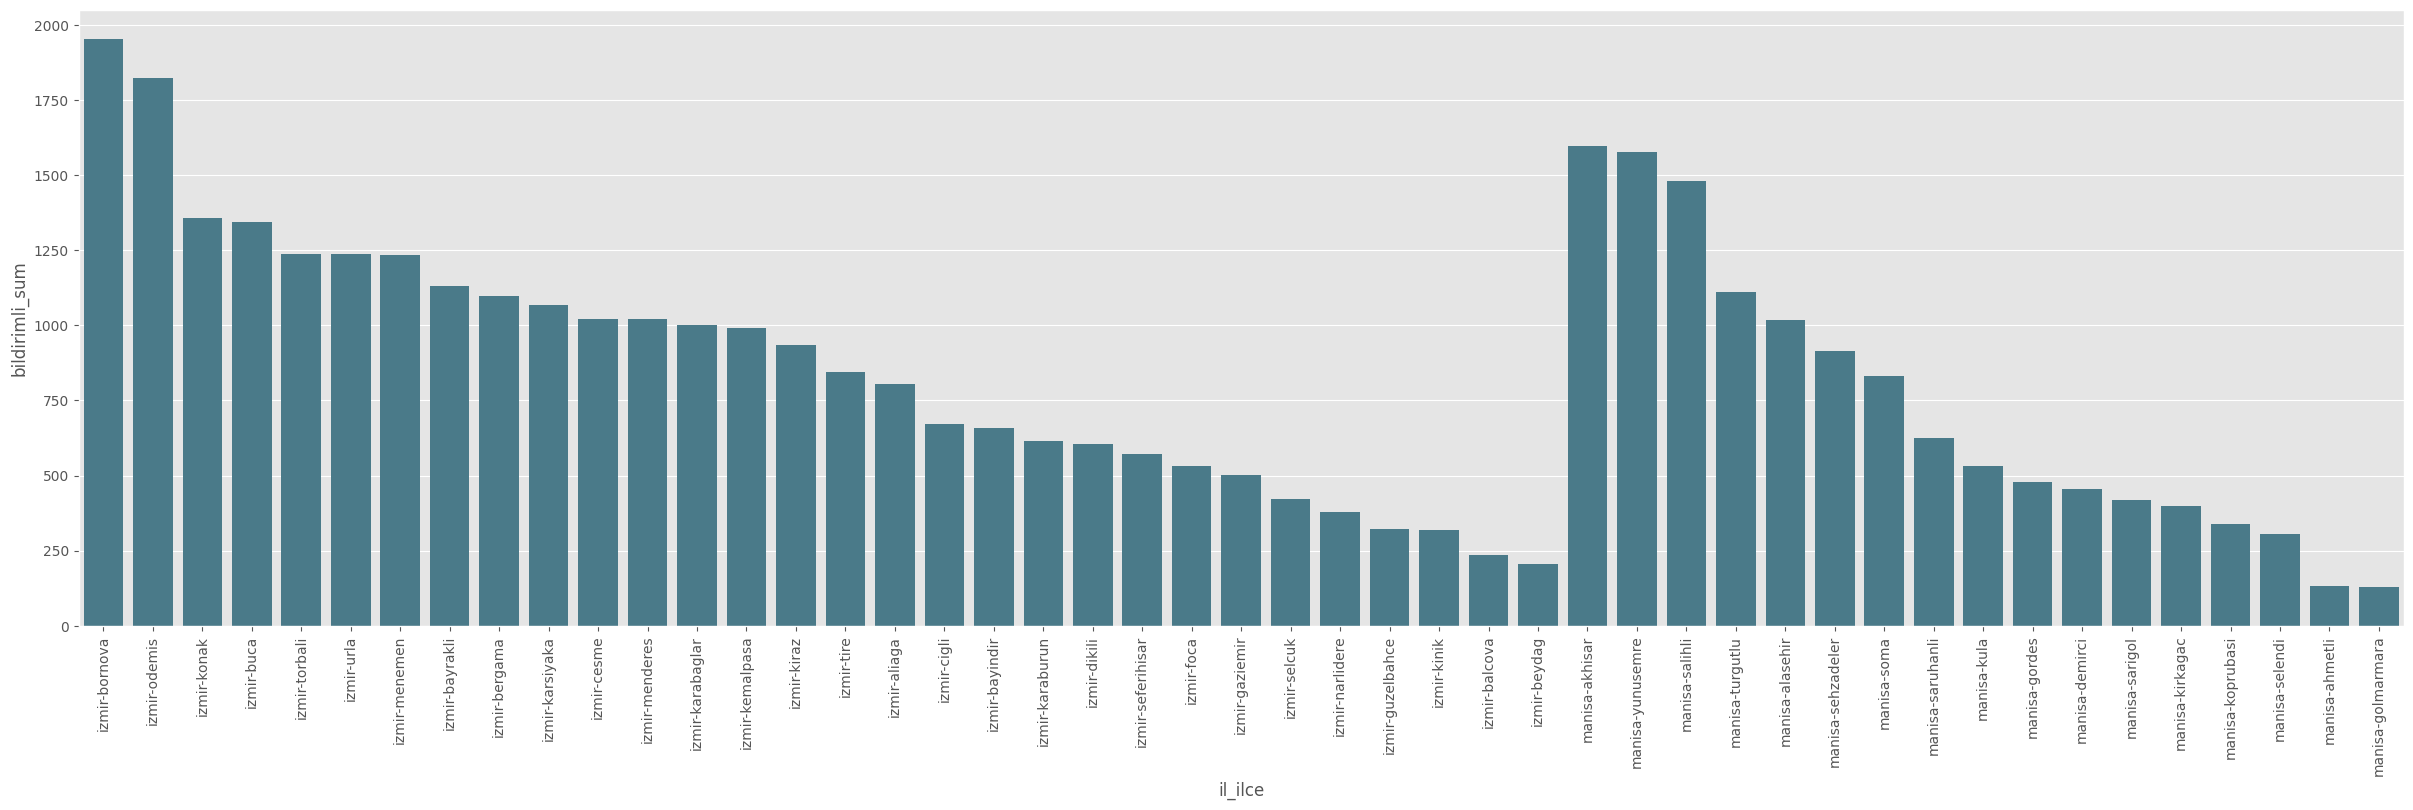

In [51]:
plt.figure(figsize=(30, 8))
sns.barplot(x="il_ilce", y="bildirimli_sum", data=sorted_df_planli)
plt.xticks(rotation=90)
plt.show()

**il ve ilçe bazlı planlı elektrik kesintilerinin toplam planlı kesintiye oranı değişkeninin veri setine eklenmesi**

In [52]:
sorted_df_planli["planned_blackout_ratio_per_city_county"] = sorted_df_planli["bildirimli_sum"] / sorted_df_planli["bildirimli_sum"].sum()
sorted_df_planli.drop("bildirimli_sum",inplace=True,axis=1)
sorted_series_planli = sorted_df_planli.set_index("il_ilce")["planned_blackout_ratio_per_city_county"]
train_test_concat["planned_blackout_ratio_per_city_county"] = train_test_concat["il_ilce"].map(sorted_series_planli)


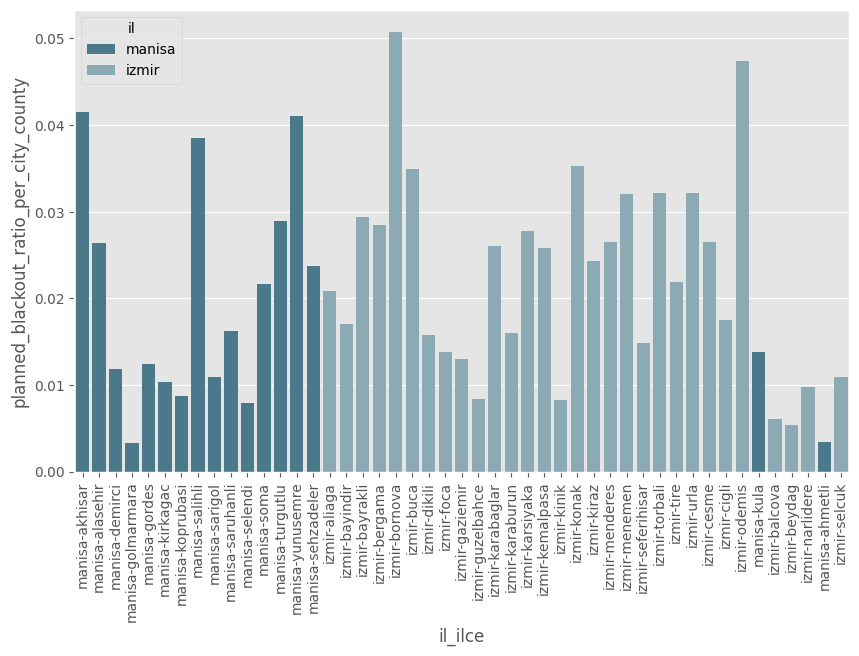

In [53]:
plt.figure(figsize=(10, 6))
sns.barplot(x="il_ilce", y="planned_blackout_ratio_per_city_county",data=train_test_concat,hue="il")
plt.xticks(rotation=90)
plt.show()

**Train set bilgisi kullanılarak bildirimli ratio eklenme**

In [54]:
train_test_concat[["year","month","day"]] = train_test_concat["tarih"].str.split("-",expand=True).astype(int)

In [55]:
temp_train=train_test_concat[train_test_concat["unique_id"].isin(train["unique_id"])]
temp_test=train_test_concat[train_test_concat["unique_id"].isin(test["unique_id"])]

In [56]:
sorted_df_planli_train = temp_train.groupby(["il", "ilce"])["bildirimli_sum"].sum().reset_index().sort_values(by=["il", "bildirimli_sum"], ascending=[True, False])
sorted_df_planli_train["il_ilce"] = sorted_df_planli_train["il"] + "-" + sorted_df_planli_train["ilce"]
sorted_df_planli_train = sorted_df_planli_train.drop(columns=["il", "ilce"])
sorted_df_planli_train = sorted_df_planli_train[["il_ilce", "bildirimli_sum"]].reset_index(drop=True)
sorted_df_planli_train.head()

il_ilce  bildirimli_sum
0  izmir-bornova            1872
1   izmir-odemis            1764
2    izmir-konak            1318
3     izmir-buca            1293
4  izmir-torbali            1219

In [57]:
sorted_df_planli_train["bildirimli_sum_ratio_per_city_county"] = sorted_df_planli_train["bildirimli_sum"] / sorted_df_planli_train["bildirimli_sum"].sum()
sorted_df_planli_train.drop("bildirimli_sum",inplace=True,axis=1)
sorted_series_planli_bildirim = sorted_df_planli_train.set_index("il_ilce")["bildirimli_sum_ratio_per_city_county"]
train_test_concat["bildirimli_sum_ratio_per_city_county"] = train_test_concat["il_ilce"].map(sorted_series_planli_bildirim)
train_test_concat.head()

tarih         il_ilce  bildirimsiz_sum  bildirimli_sum  \
0  2021-01-01  manisa-akhisar              9.0               0   
1  2021-01-02  manisa-akhisar             10.0               0   
2  2021-01-03  manisa-akhisar              5.0               2   
3  2021-01-04  manisa-akhisar              6.0               0   
4  2021-01-05  manisa-akhisar             15.0               4   

                   unique_id     flag      lat     long  temp  cloud_cover  \
0  2021-01-01-manisa-akhisar  yilbasi  38.9177  27.8366  14.9         75.0   
1  2021-01-02-manisa-akhisar   normal  38.9177  27.8366  17.1         49.6   
2  2021-01-03-manisa-akhisar   normal  38.9177  27.8366  14.5         99.8   
3  2021-01-04-manisa-akhisar   normal  38.9177  27.8366  17.5         95.5   
4  2021-01-05-manisa-akhisar   normal  38.9177  27.8366  15.6        100.0   

   global_rad  relative_humidity  wind_dir  wind_speed  precip  temp_app  \
0       283.5               94.3     133.6         2.1     1.0      17.8   
1       437.6               95.7     100.6         1.4     1.0      20.2   
2       236.1               95.0     122.5         1.7     1.0      16.3   
3       442.3               96.3      90.2         2.7    30.4      19.2   
4       375.1               90.2     160.1         3.1    53.9      18.6   

   temp_measure_app_diff  cloud_cover_min  relative_humidity_min  \
0                    3.5             30.5                   78.6   
1                    4.2              3.3                   52.7   
2                    2.7              1.3                   57.3   
3                    3.5              7.7                   41.9   
4                    3.4              8.0                   61.6   

   wind_speed_min  precip_min      il     ilce  \
0             0.2         1.0  manisa  akhisar   
1             0.4         1.0  manisa  akhisar   
2             0.2         1.0  manisa  akhisar   
3             0.5         1.0  manisa  akhisar   
4             0.9         1.0  manisa  akhisar   

   blackout_ratio_per_city_county  planned_blackout_ratio_per_city_county  \
0                         0.03451                                0.041542   
1                         0.03451                                0.041542   
2                         0.03451                                0.041542   
3                         0.03451                                0.041542   
4                         0.03451                                0.041542   

   year  month  day  bildirimli_sum_ratio_per_city_county  
0  2021      1    1                              0.041752  
1  2021      1    2                              0.041752  
2  2021      1    3                              0.041752  
3  2021      1    4                              0.041752  
4  2021      1    5                              0.041752

In [58]:
sorted_df_planli_train.head()

il_ilce  bildirimli_sum_ratio_per_city_county
0  izmir-bornova                              0.049815
1   izmir-odemis                              0.046941
2    izmir-konak                              0.035073
3     izmir-buca                              0.034408
4  izmir-torbali                              0.032438

In [59]:
train_test_concat.loc[train_test_concat["il_ilce"]=="izmir-bornova","bildirimli_sum_ratio_per_city_county"].head(1)

19199    0.049815
Name: bildirimli_sum_ratio_per_city_county, dtype: float64

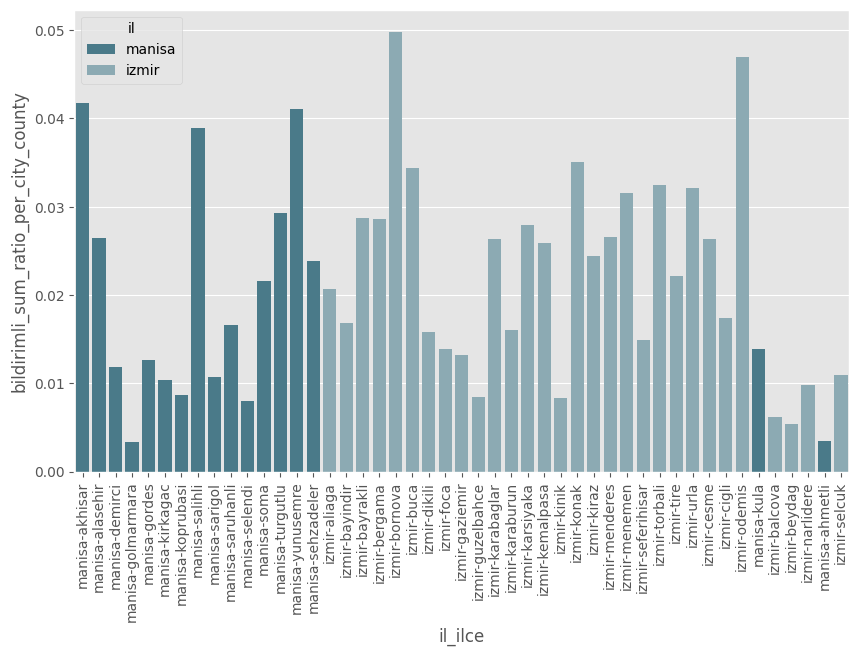

In [60]:
plt.figure(figsize=(10, 6))
sns.barplot(x="il_ilce", y="bildirimli_sum_ratio_per_city_county",data=train_test_concat,hue="il")
plt.xticks(rotation=90)
plt.show()

**Tatil günleri bazlı analiz**
- Tatil günlerinden en fazla kesinti kurban bayramı ve demokrasi ve milli birlik gününde meydana gelmiş

Özel günlerin sayısı

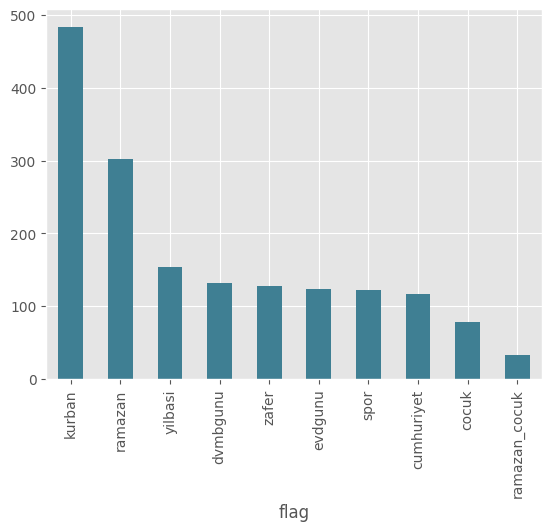

In [61]:
train_test_concat[train_test_concat["flag"]!="normal"]["flag"].value_counts().plot(kind="bar")
plt.show()

Özel günlere göre kesinti toplamları

In [62]:
holidays=train_test_concat.groupby("flag")["bildirimsiz_sum"].sum().reset_index().sort_values(by=["bildirimsiz_sum"], ascending=[False])
holidays_except_normal=holidays[holidays["flag"]!="normal"]

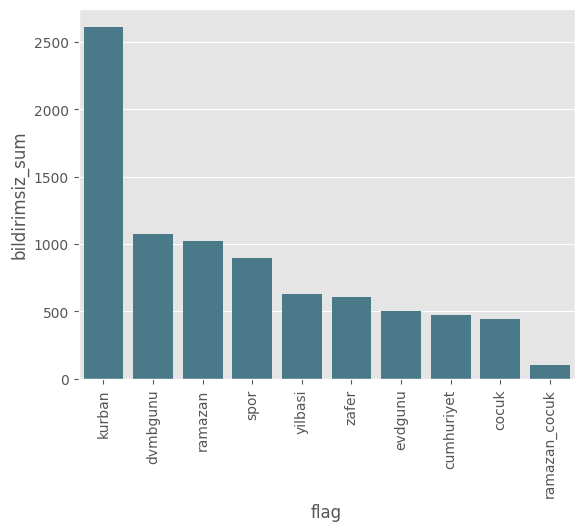

In [63]:
sns.barplot(x="flag",y="bildirimsiz_sum",data=holidays_except_normal)
plt.xticks(rotation=90)
plt.show()

**Sayısal Değişkenlerin Analizi**

In [64]:
train_test_concat.describe().T

count         mean         std  \
bildirimsiz_sum                         46944.0     5.876385    5.415367   
bildirimli_sum                          48260.0     0.797078    1.314725   
lat                                     48260.0    38.535063    0.301958   
long                                    48260.0    27.502069    0.625079   
temp                                    48260.0    22.856948    8.945107   
cloud_cover                             48260.0    59.182250   37.547151   
global_rad                              48260.0   672.005959  225.423653   
relative_humidity                       48260.0    83.255912   12.357642   
wind_dir                                48260.0   156.341751   76.187870   
wind_speed                              48260.0     4.522066    2.002611   
precip                                  48260.0    13.689476   27.266648   
temp_app                                48260.0    27.320576   10.326587   
temp_measure_app_diff                   48260.0     5.289279    2.005112   
cloud_cover_min                         48260.0     7.195966   16.278179   
relative_humidity_min                   48260.0    42.433262   16.433426   
wind_speed_min                          48260.0     1.328603    1.401579   
precip_min                              48260.0     1.002176    0.135916   
blackout_ratio_per_city_county          48260.0     0.022604    0.011746   
planned_blackout_ratio_per_city_county  48260.0     0.022461    0.011521   
year                                    48260.0  2022.056610    0.875344   
month                                   48260.0     6.378947    3.516559   
day                                     48260.0    15.717903    8.801458   
bildirimli_sum_ratio_per_city_county    48260.0     0.022458    0.011425   

                                                min          25%          50%  \
bildirimsiz_sum                            0.000000     2.000000     4.000000   
bildirimli_sum                             0.000000     0.000000     0.000000   
lat                                       37.950800    38.325000    38.471000   
long                                      26.303200    27.069700    27.381800   
temp                                      -2.700000    15.900000    22.300000   
cloud_cover                                0.000000    23.975000    64.000000   
global_rad                                27.600000   490.000000   703.000000   
relative_humidity                         30.300000    75.200000    85.400000   
wind_dir                                   5.000000   105.800000   156.100000   
wind_speed                                 0.700000     3.100000     4.300000   
precip                                     1.000000     1.000000     1.000000   
temp_app                                  -5.300000    19.200000    26.400000   
temp_measure_app_diff                     -4.400000     3.900000     5.500000   
cloud_cover_min                            0.000000     0.000000     0.000000   
relative_humidity_min                      5.600000    29.400000    41.900000   
wind_speed_min                             0.000000     0.400000     0.800000   
precip_min                                 1.000000     1.000000     1.000000   
blackout_ratio_per_city_county             0.003009     0.013115     0.021580   
planned_blackout_ratio_per_city_county     0.003328     0.013024     0.021941   
year                                    2021.000000  2021.000000  2022.000000   
month                                      1.000000     3.000000     6.000000   
day                                        1.000000     8.000000    16.000000   
bildirimli_sum_ratio_per_city_county       0.003380     0.013199     0.022193   

                                                75%          max  
bildirimsiz_sum                            8.000000    93.000000  
bildirimli_sum                             1.000000    19.000000  
lat                                       38.737500    39.188100  
long

In [65]:
train_test_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48260 entries, 0 to 48259
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   tarih                                   48260 non-null  object 
 1   il_ilce                                 48260 non-null  object 
 2   bildirimsiz_sum                         46944 non-null  float64
 3   bildirimli_sum                          48260 non-null  int64  
 4   unique_id                               48260 non-null  object 
 5   flag                                    48260 non-null  object 
 6   lat                                     48260 non-null  float64
 7   long                                    48260 non-null  float64
 8   temp                                    48260 non-null  float64
 9   cloud_cover                             48260 non-null  float64
 10  global_rad                              48260 non-null  fl

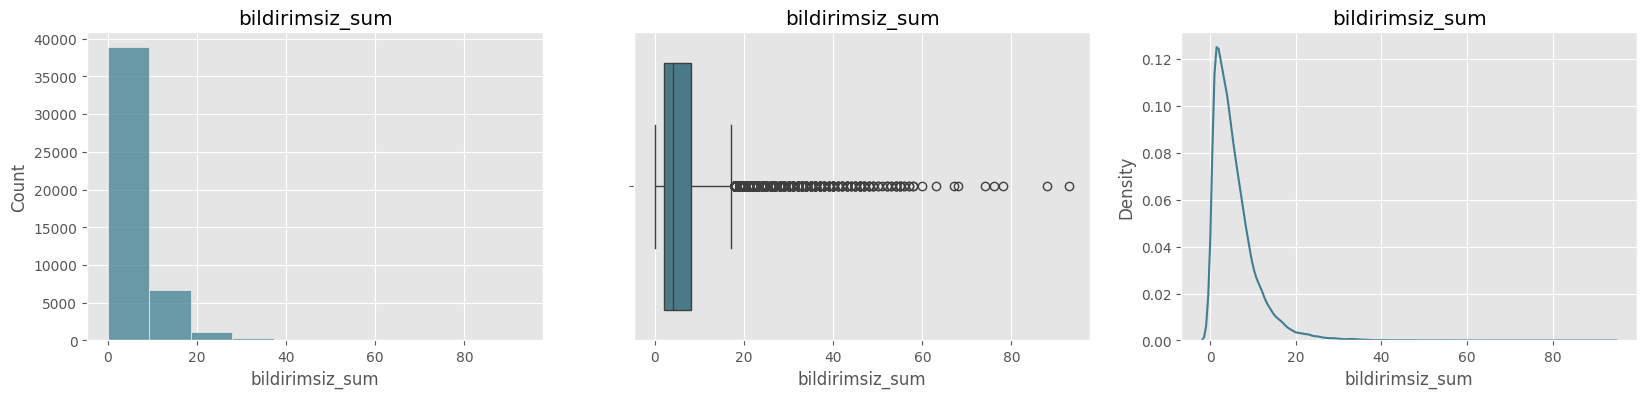

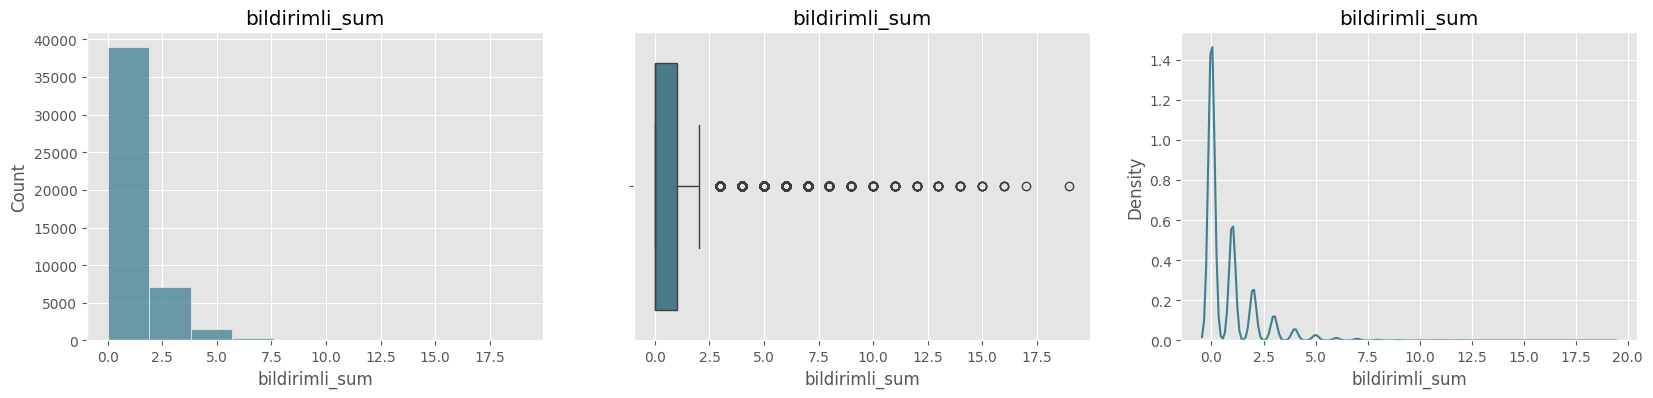

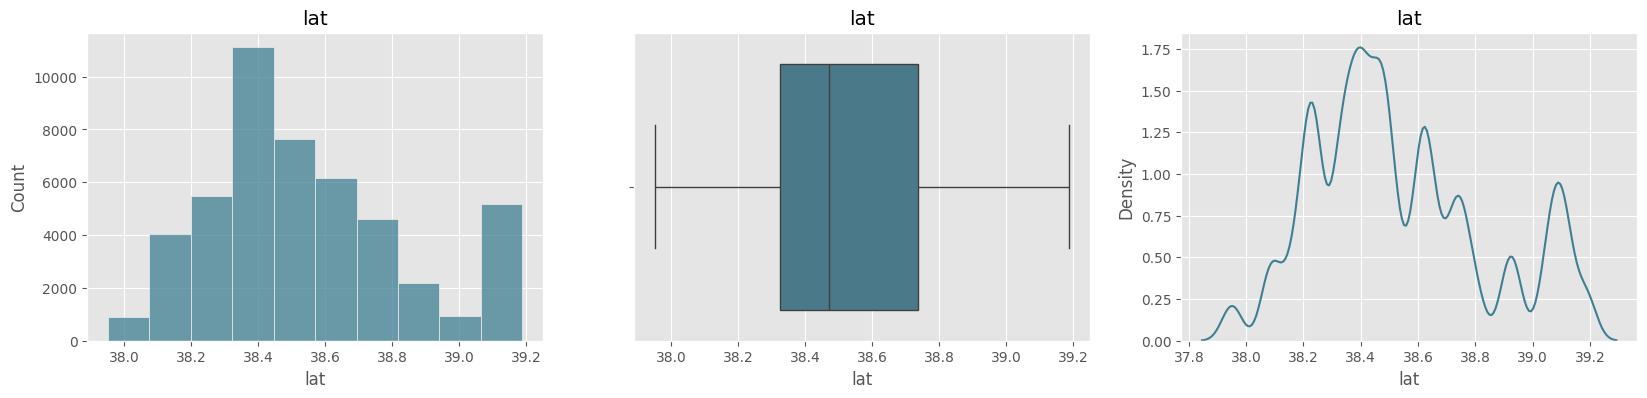

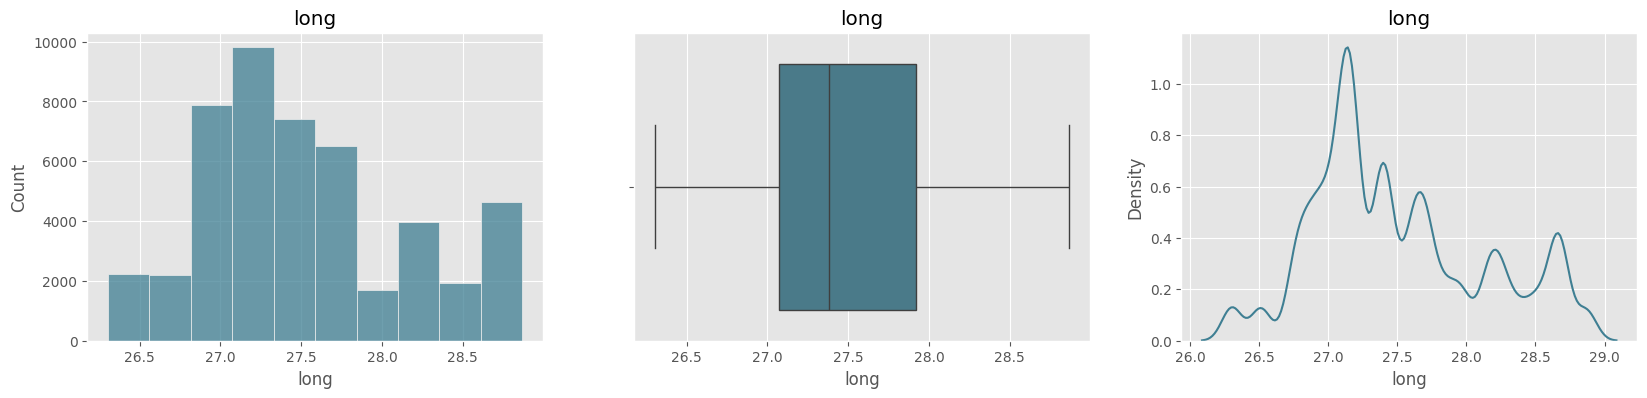

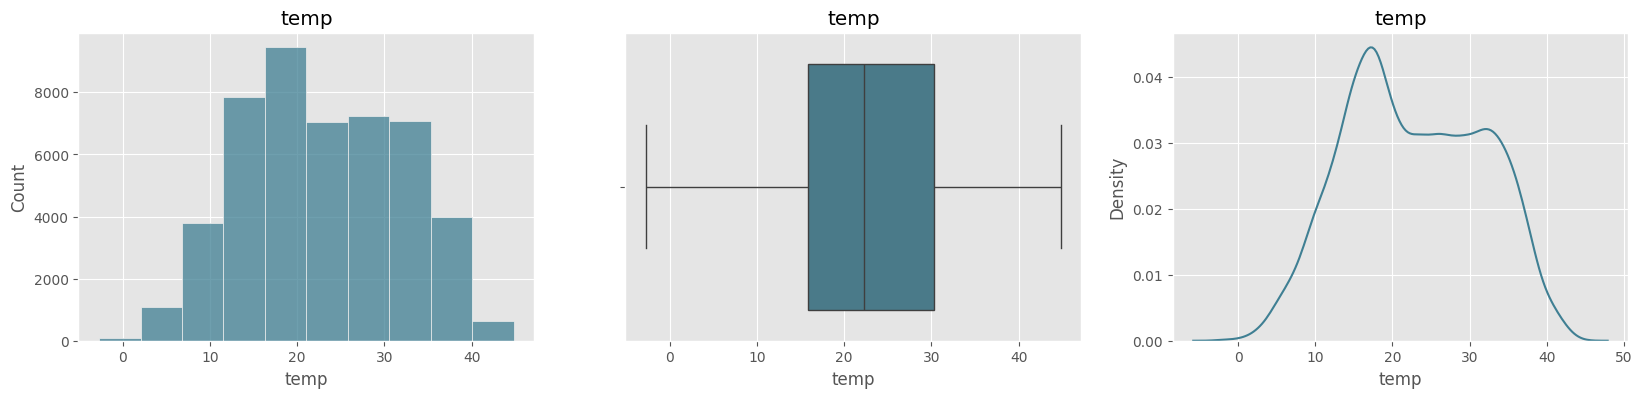

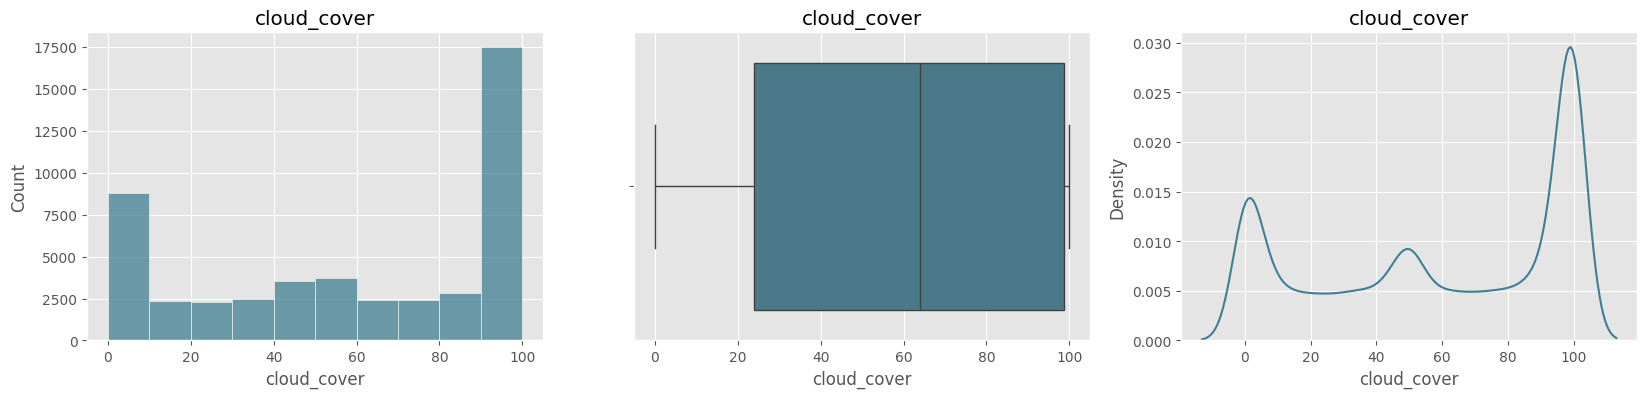

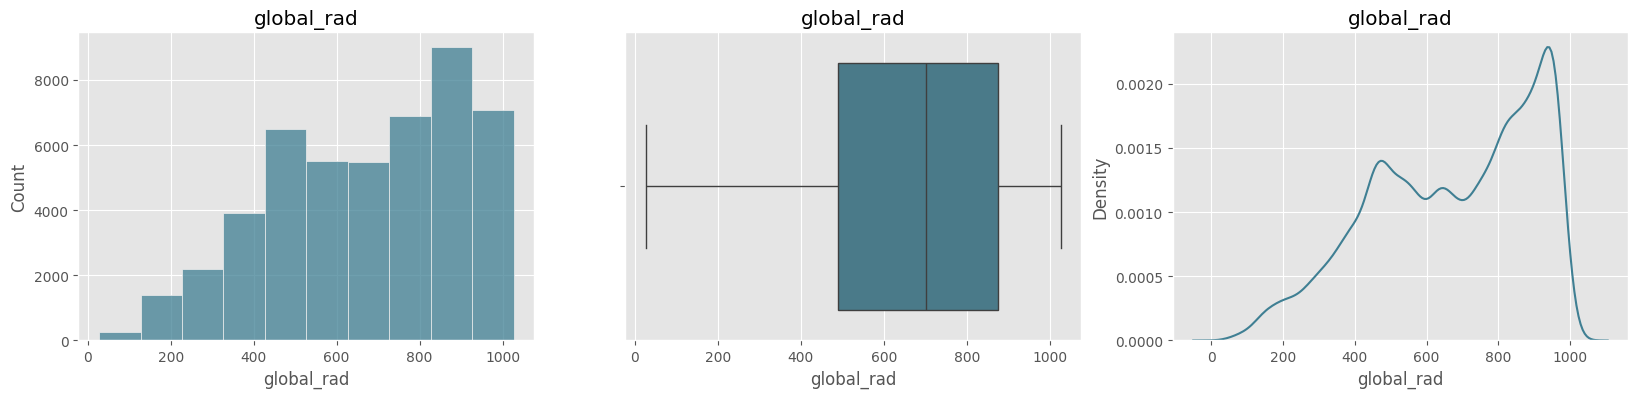

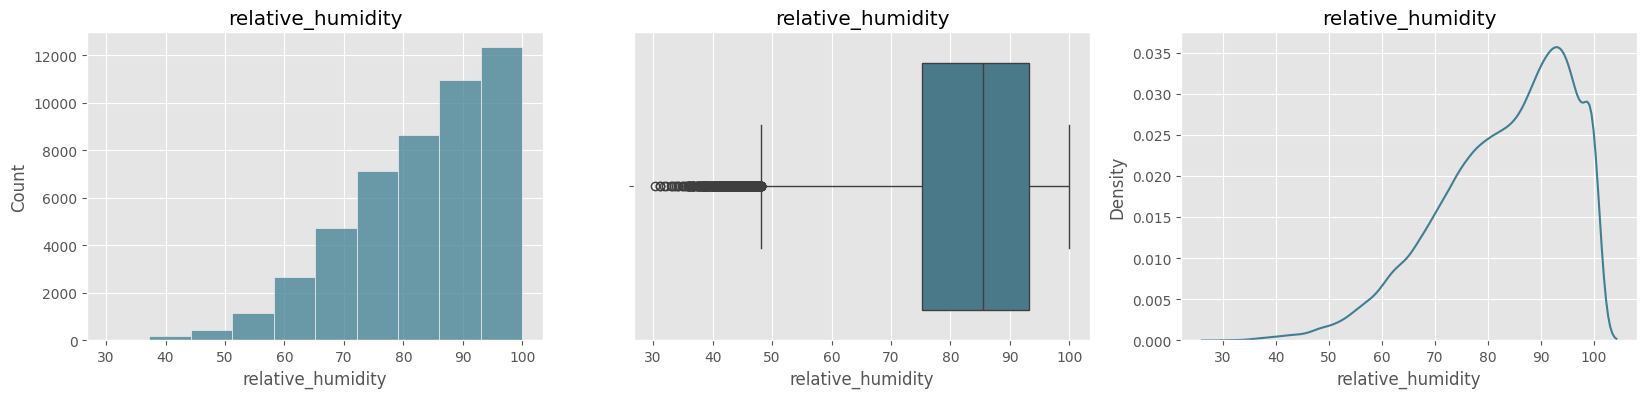

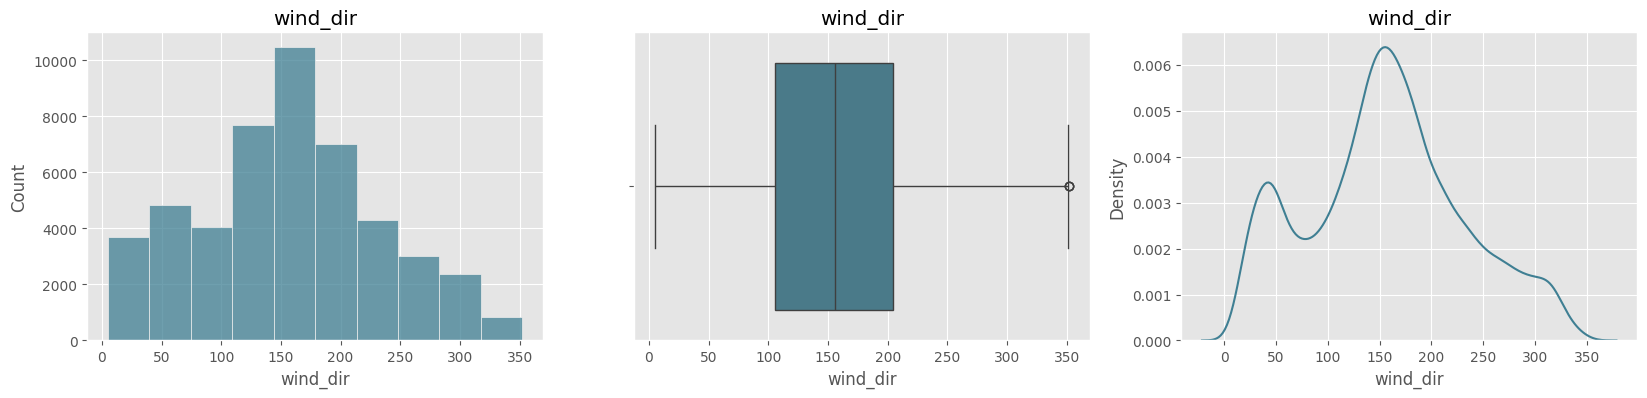

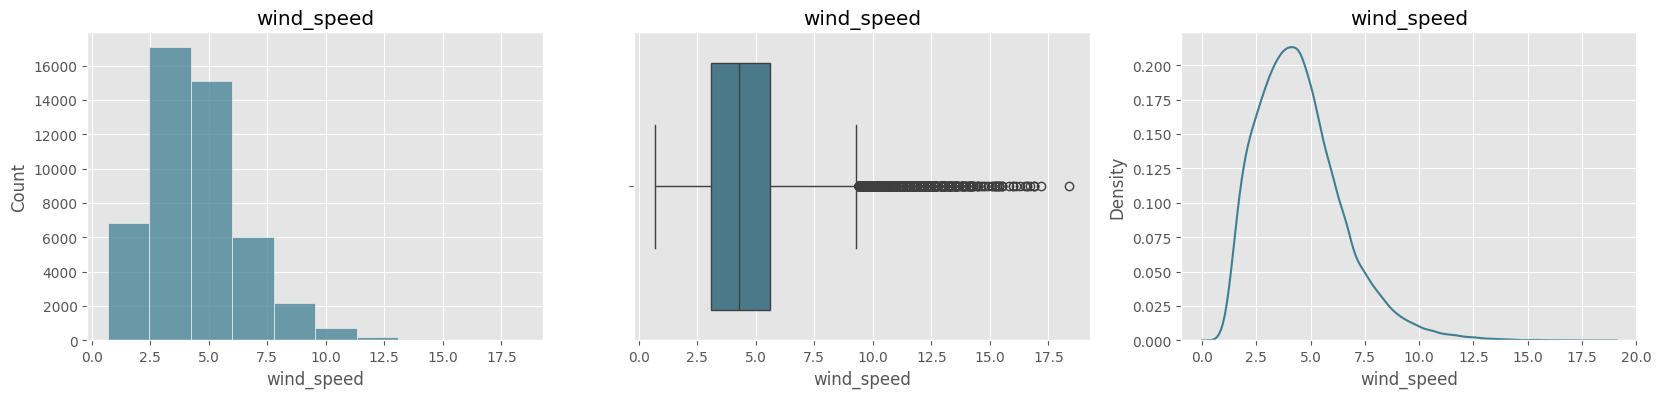

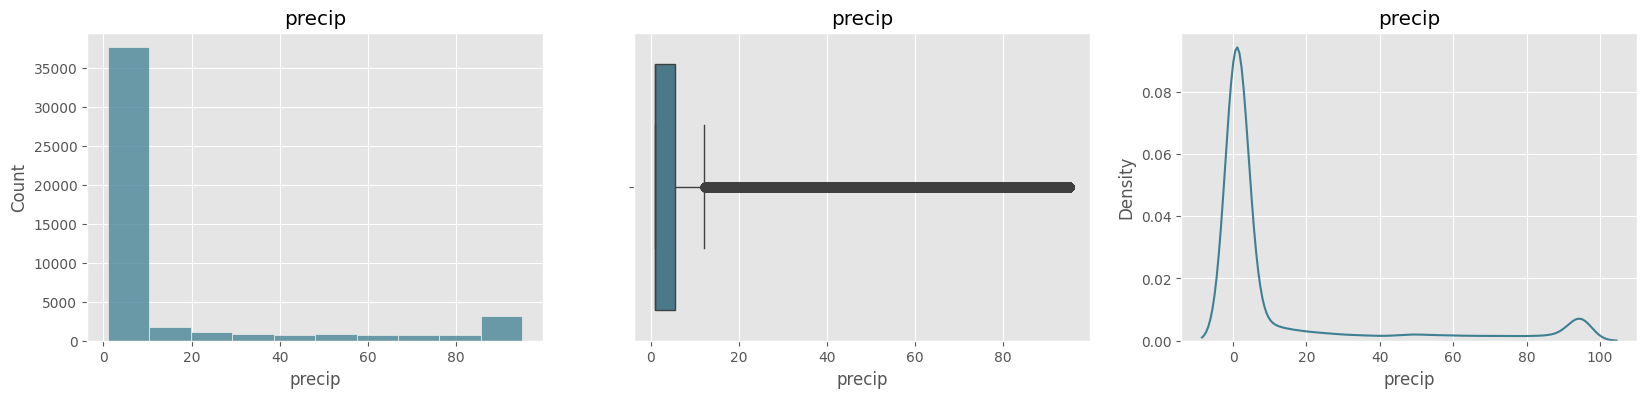

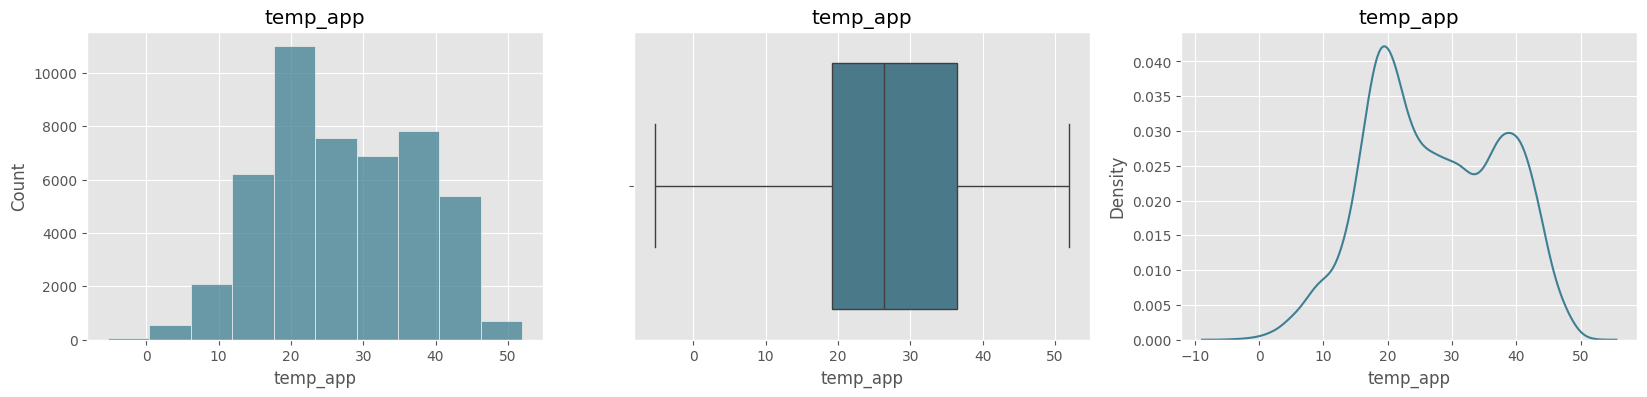

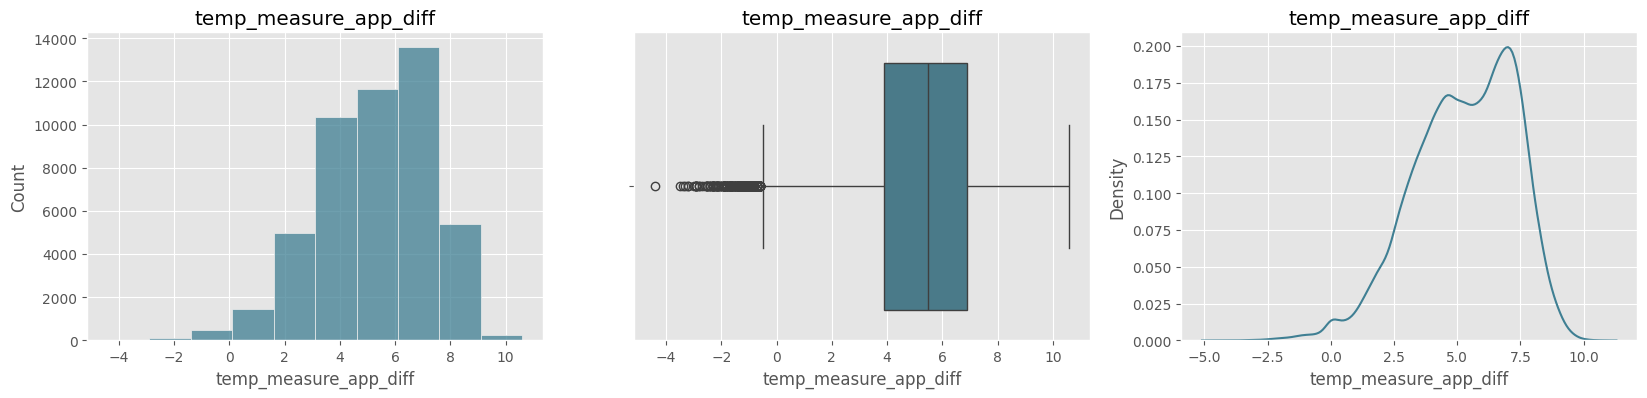

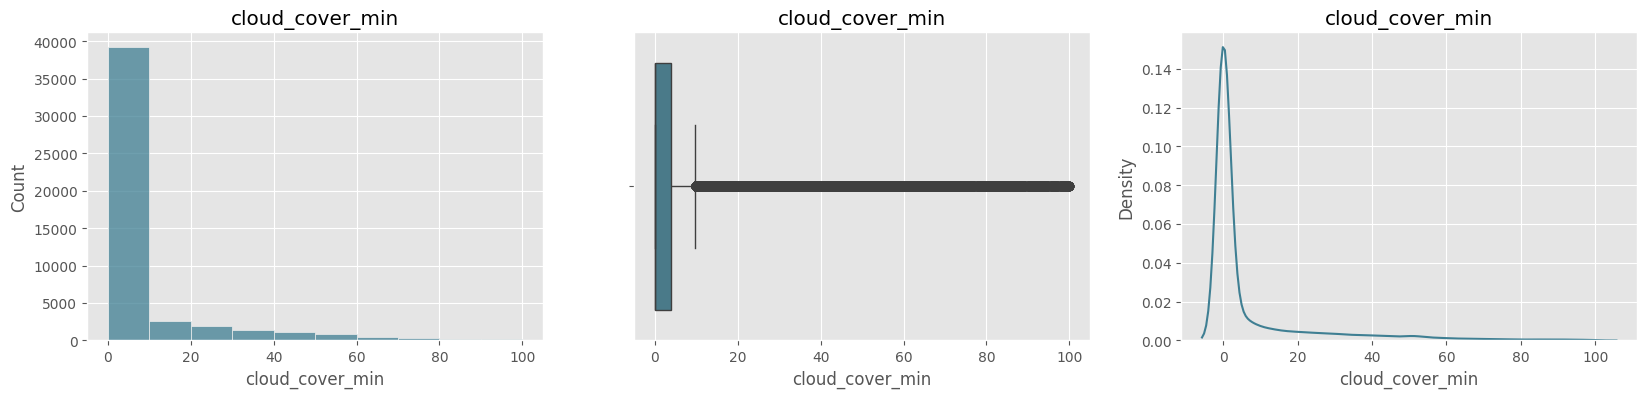

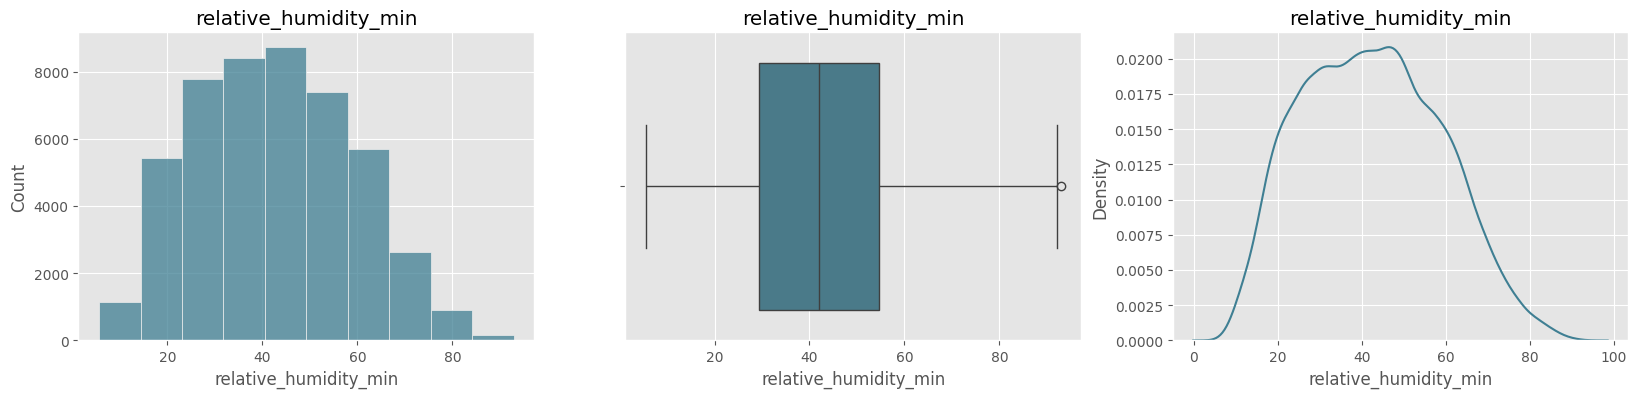

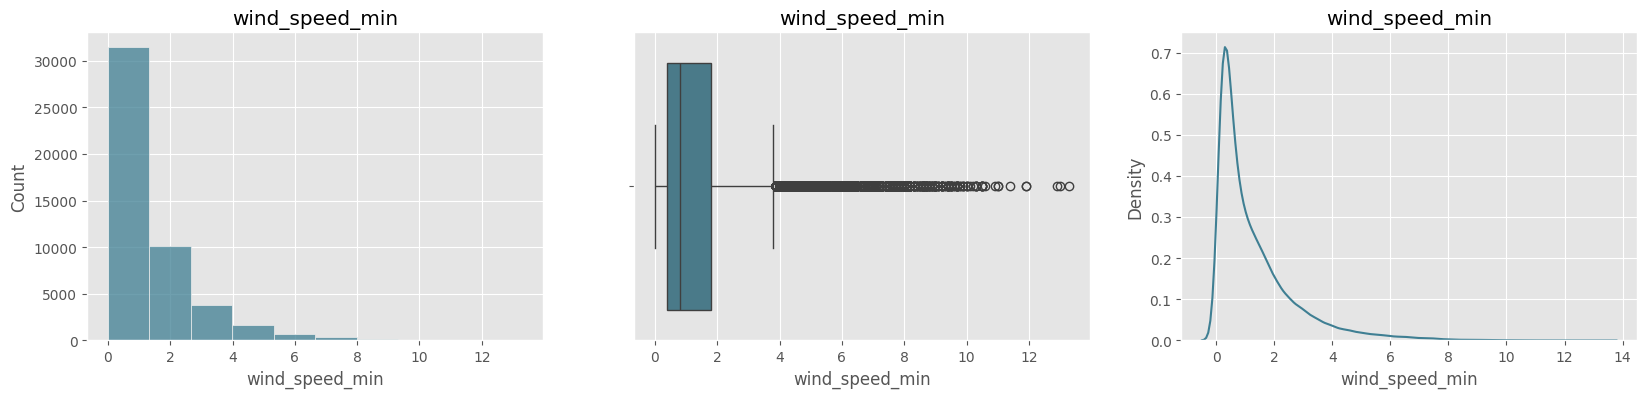

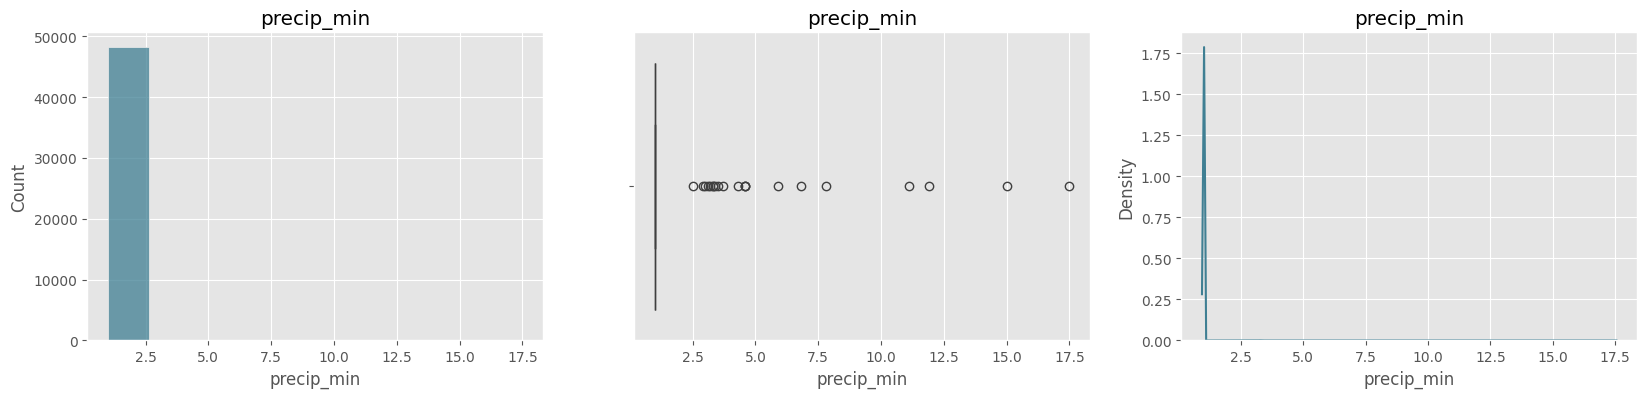

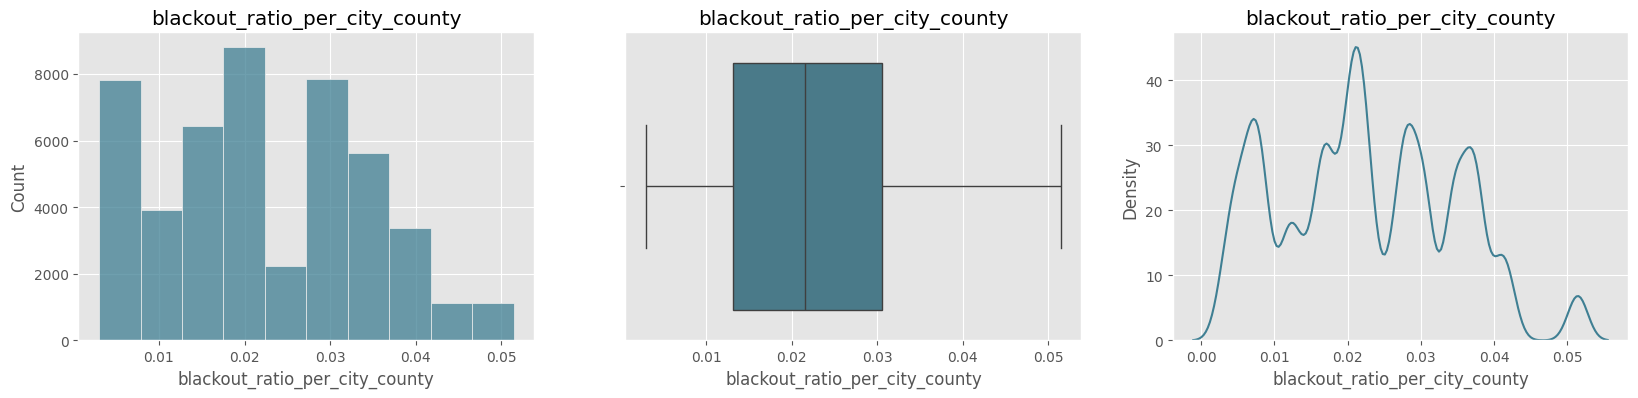

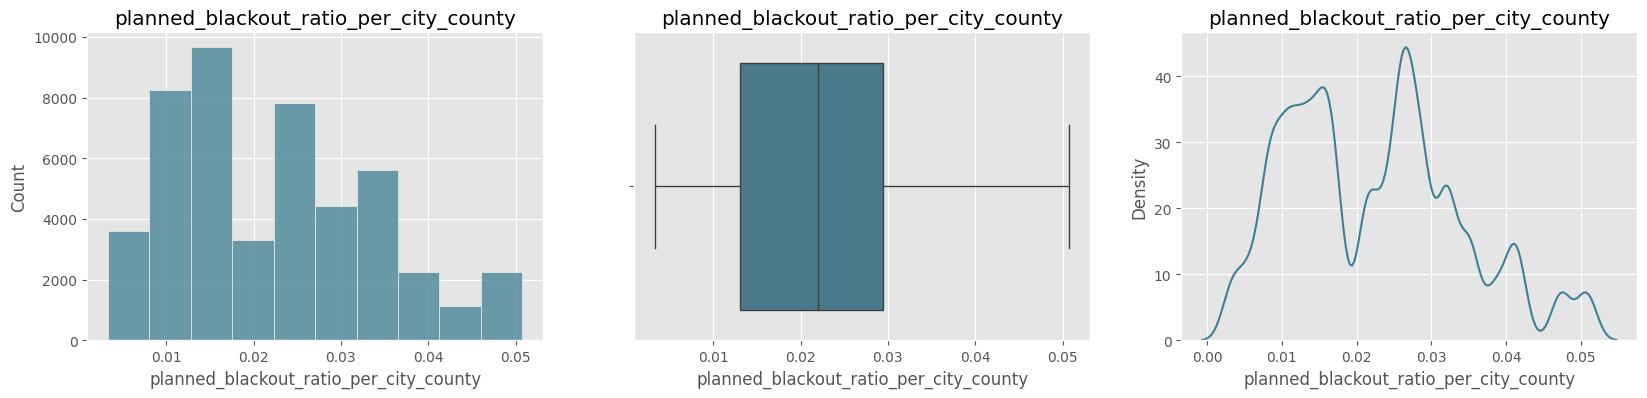

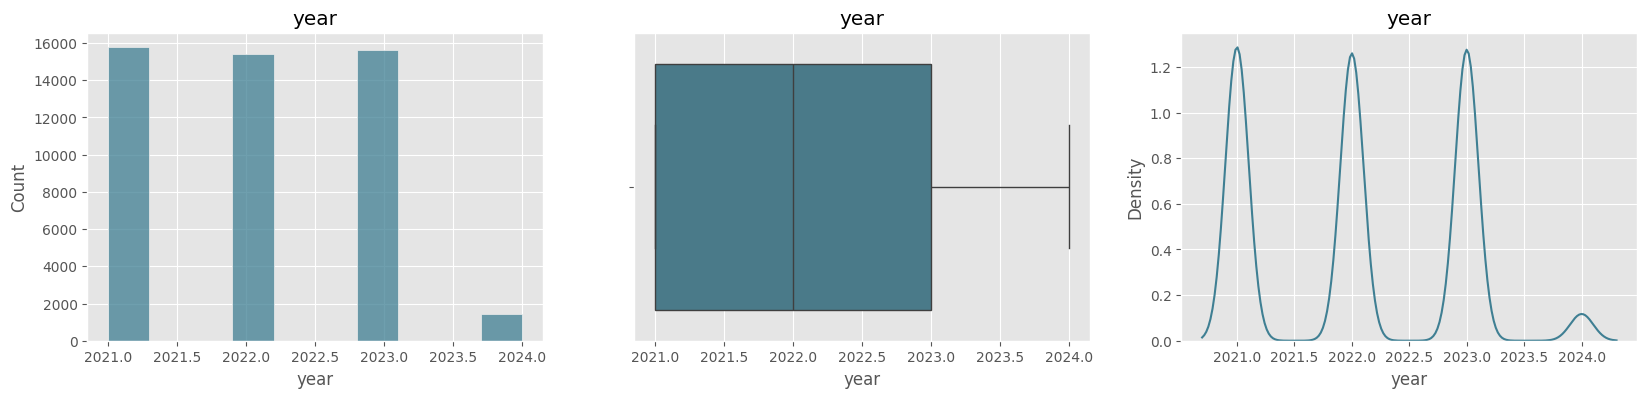

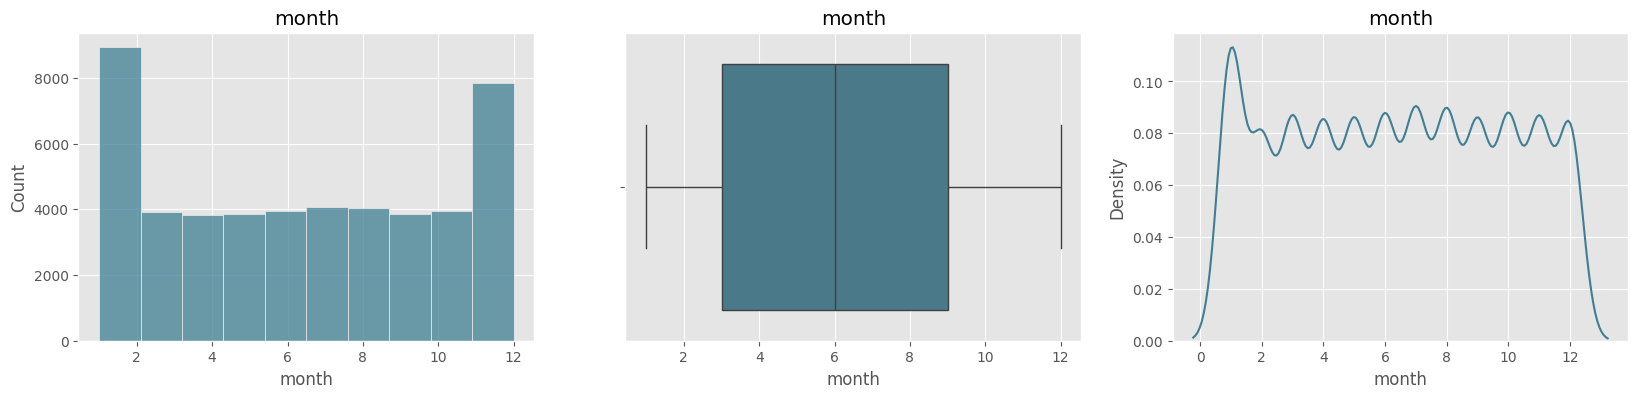

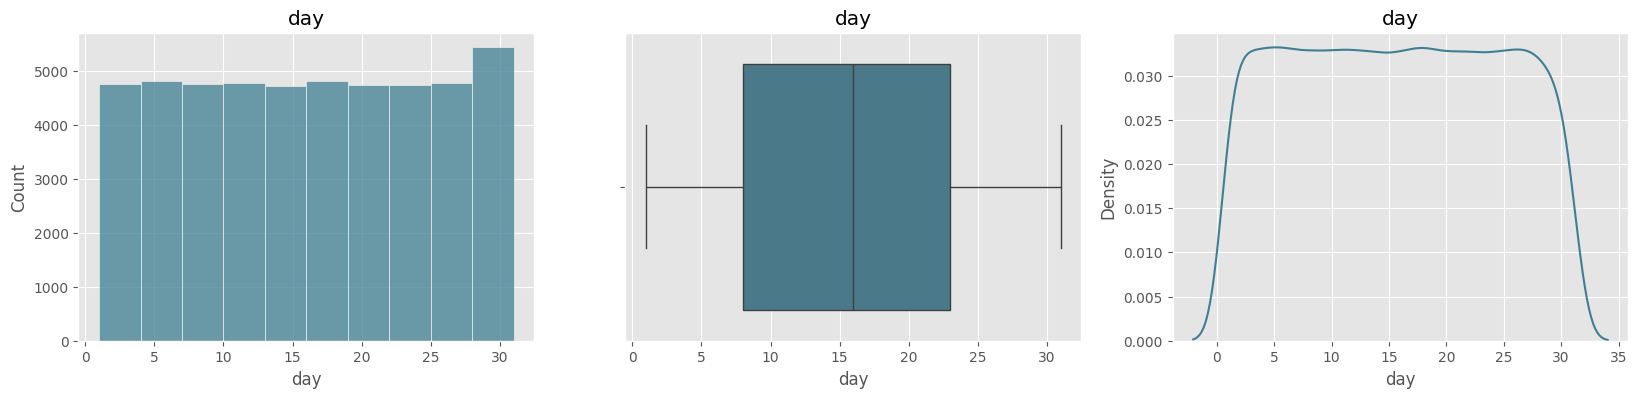

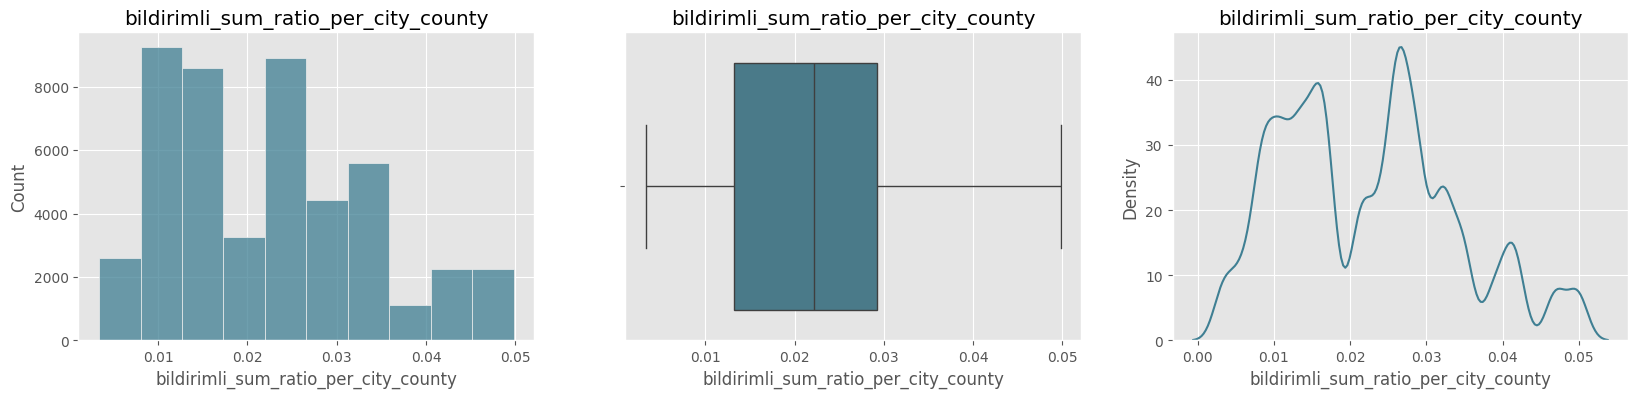

In [66]:
single_variable_multiple_plot(train_test_concat,numeric=True)

**Tarih Değişkenlerinin Eklenmesi**
- Yıl ve ay etkili olabileceği için oranlar yıl ve aya göre oluşturuldu.

In [67]:
train_test_concat[["year","month","day"]] = train_test_concat["tarih"].str.split("-",expand=True).astype(int)

**Yıl değişkeni**

**Bildirimsiz**

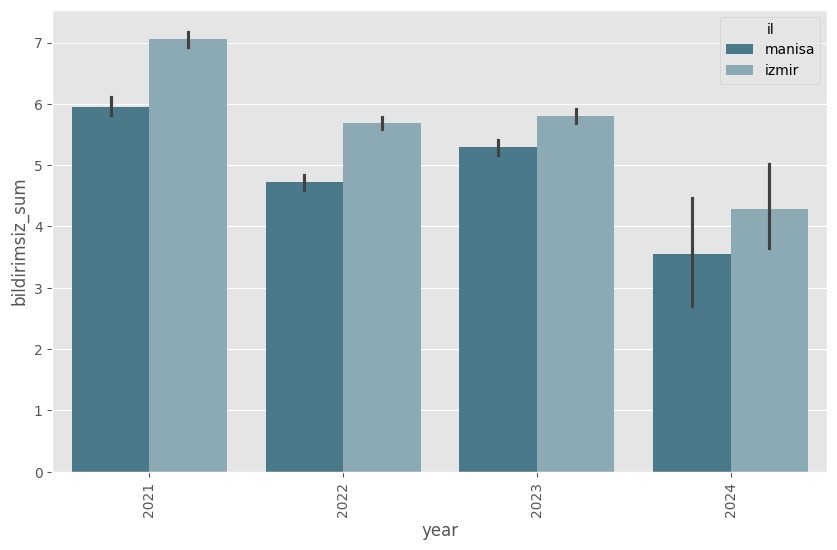

In [68]:
plt.figure(figsize=(10, 6))
sns.barplot(x="year", y="bildirimsiz_sum",hue="il",data=train_test_concat)
plt.xticks(rotation=90)
plt.show()

In [69]:
year_group_bsiz = train_test_concat.groupby("year")["bildirimsiz_sum"].sum().reset_index()
year_group_bsiz["year_bildirimsiz_ratio"] = year_group_bsiz["bildirimsiz_sum"] / year_group_bsiz["bildirimsiz_sum"].sum()
year_group_bsiz.drop("bildirimsiz_sum",axis=1, inplace=True)
year_group_series_bsiz=year_group_bsiz.set_index("year")["year_bildirimsiz_ratio"]
train_test_concat["year_bildirimsiz_ratio"] = train_test_concat["year"].map(year_group_series_bsiz)
year_group_bsiz

year  year_bildirimsiz_ratio
0  2021                0.380895
1  2022                0.299075
2  2023                0.318298
3  2024                0.001733

**Bildirimli**

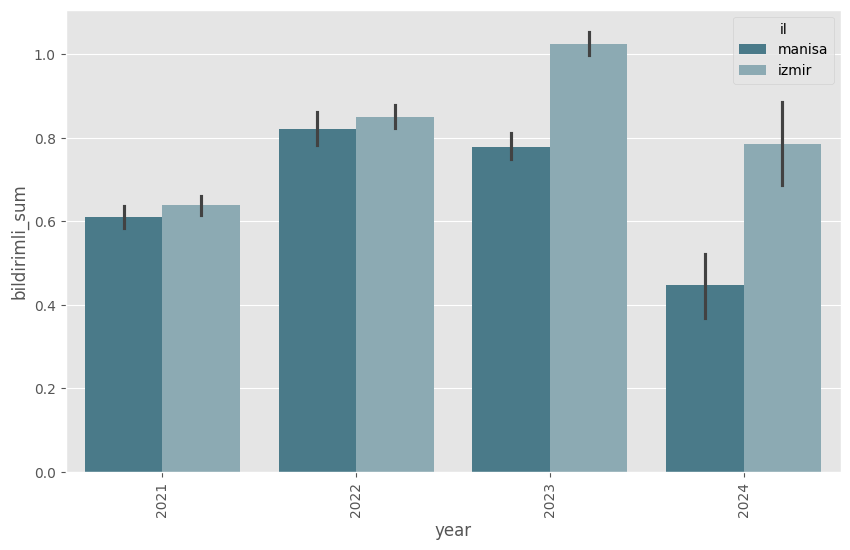

In [70]:
plt.figure(figsize=(10, 6))
sns.barplot(x="year", y="bildirimli_sum",hue="il",data=train_test_concat)
plt.xticks(rotation=90)
plt.show()

In [71]:
year_group_bli = train_test_concat.groupby("year")["bildirimli_sum"].sum().reset_index()
year_group_bli["year_bildirimli_ratio"] = year_group_bli["bildirimli_sum"] / year_group_bli["bildirimli_sum"].sum()
year_group_bli.drop("bildirimli_sum",axis=1, inplace=True)
year_group_series_bli=year_group_bli.set_index("year")["year_bildirimli_ratio"]
train_test_concat["year_bildirimli_ratio"] = train_test_concat["year"].map(year_group_series_bli)
year_group_bli

year  year_bildirimli_ratio
0  2021               0.257597
1  2022               0.336678
2  2023               0.381028
3  2024               0.024696

**Ay Değişkeni**

**Bildirimsiz**

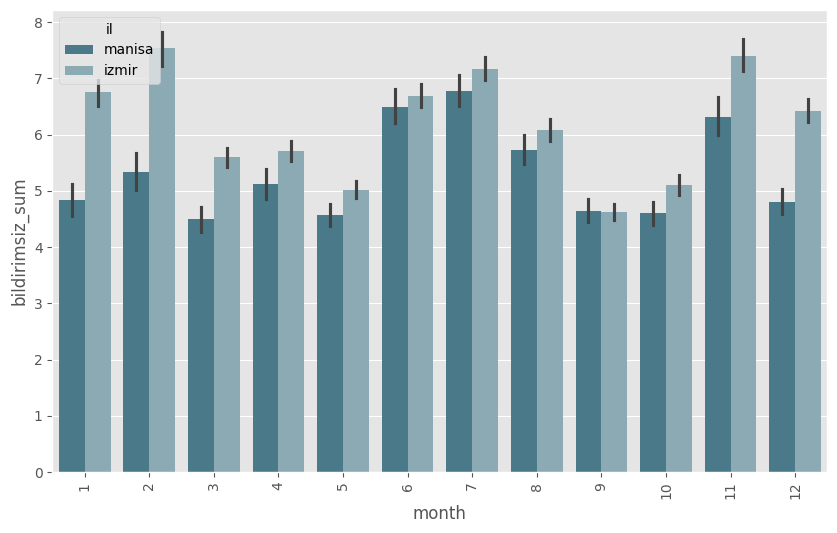

In [72]:
plt.figure(figsize=(10, 6))
sns.barplot(x="month", y="bildirimsiz_sum",data=train_test_concat,hue="il")
plt.xticks(rotation=90)
plt.show()

In [73]:
month_group_bsiz = train_test_concat.groupby("month")["bildirimsiz_sum"].sum().reset_index()
month_group_bsiz["month_bildirimsiz_ratio"] = month_group_bsiz["bildirimsiz_sum"] / month_group_bsiz["bildirimsiz_sum"].sum()
month_group_bsiz.drop("bildirimsiz_sum",axis=1, inplace=True)
month_group_series_bsiz=month_group_bsiz.set_index("month")["month_bildirimsiz_ratio"]
train_test_concat["month_bildirimsiz_ratio"] = train_test_concat["month"].map(month_group_series_bsiz)
month_group_bsiz

month  month_bildirimsiz_ratio
0       1                 0.089980
1       2                 0.087381
2       3                 0.074320
3       4                 0.076303
4       5                 0.068132
5       6                 0.094613
6       7                 0.103712
7       8                 0.087160
8       9                 0.064696
9      10                 0.070623
10     11                 0.099141
11     12                 0.083941

**Bildirimli**

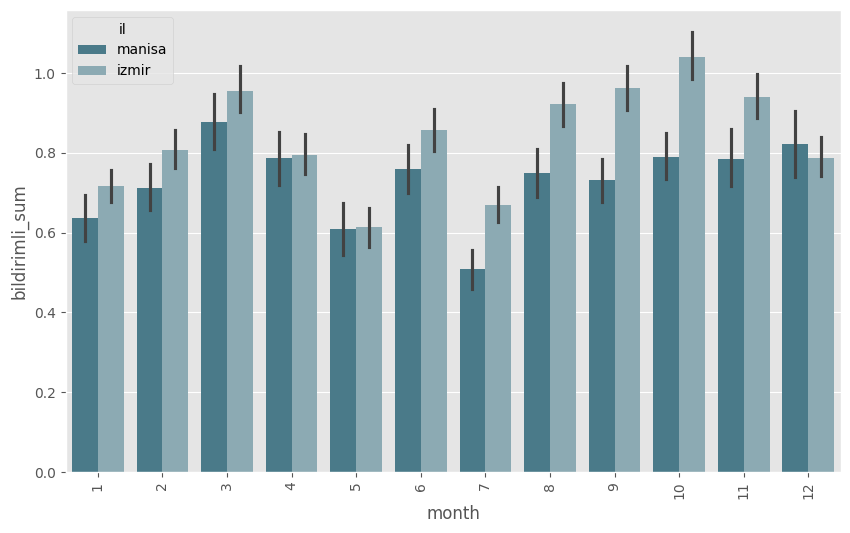

In [74]:
plt.figure(figsize=(10, 6))
sns.barplot(x="month", y="bildirimli_sum",data=train_test_concat,hue="il")
plt.xticks(rotation=90)
plt.show()

In [75]:
month_group_bli = train_test_concat.groupby("month")["bildirimli_sum"].sum().reset_index()
month_group_bli["month_bildirimli_ratio"] = month_group_bli["bildirimli_sum"] / month_group_bli["bildirimli_sum"].sum()
month_group_bli.drop("bildirimli_sum",axis=1, inplace=True)
month_group_series_bli=month_group_bli.set_index("month")["month_bildirimli_ratio"]
train_test_concat["month_bildirimli_ratio"] = train_test_concat["month"].map(month_group_series_bli)
month_group_bli

month  month_bildirimli_ratio
0       1                0.096420
1       2                0.071490
2       3                0.094887
3       4                0.078847
4       5                0.061559
5       6                0.084072
6       7                0.064601
7       8                0.090311
8       9                0.088127
9      10                0.097902
10     11                0.089713
11     12                0.082070

**Gün Değişkeni**

**Bildirimsiz**

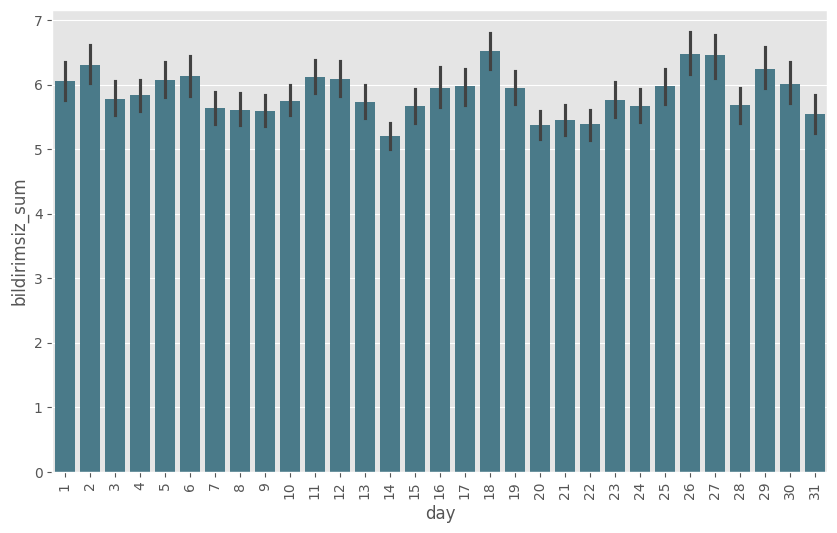

In [76]:
plt.figure(figsize=(10, 6))
sns.barplot(x="day", y="bildirimsiz_sum",data=train_test_concat)
plt.xticks(rotation=90)
plt.show()

In [77]:
day_group_bsiz = train_test_concat.groupby("day")["bildirimsiz_sum"].sum().reset_index()
day_group_bsiz["day_bildirimsiz_ratio"] = day_group_bsiz["bildirimsiz_sum"] / day_group_bsiz["bildirimsiz_sum"].sum()
day_group_bsiz.drop("bildirimsiz_sum",axis=1, inplace=True)
day_group_series_bsiz=day_group_bsiz.set_index("day")["day_bildirimsiz_ratio"]
train_test_concat["day_bildirimsiz_ratio"] = train_test_concat["day"].map(day_group_series_bsiz)
day_group_bsiz.head()

day  day_bildirimsiz_ratio
0    1               0.034594
1    2               0.036141
2    3               0.033241
3    4               0.032770
4    5               0.034441

**Bildirimli**

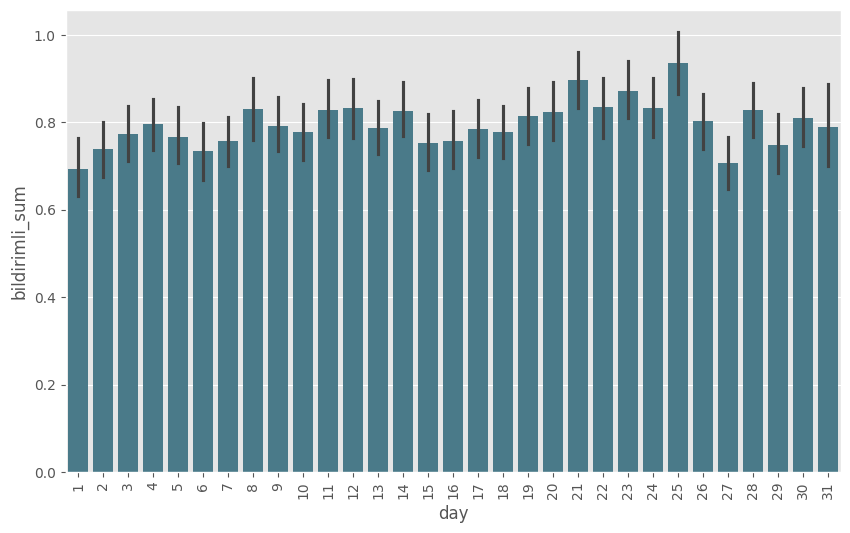

In [78]:
plt.figure(figsize=(10, 6))
sns.barplot(x="day", y="bildirimli_sum",data=train_test_concat)
plt.xticks(rotation=90)
plt.show()

In [79]:
day_group_bli = train_test_concat.groupby("day")["bildirimli_sum"].sum().reset_index()
day_group_bli["day_bildirimli_ratio"] = day_group_bli["bildirimli_sum"] / day_group_bli["bildirimli_sum"].sum()
day_group_bli.drop("bildirimli_sum",axis=1, inplace=True)
day_group_series_bli=day_group_bli.set_index("day")["day_bildirimli_ratio"]
train_test_concat["day_bildirimli_ratio"] = train_test_concat["day"].map(day_group_series_bli)
day_group_bli.head()

day  day_bildirimli_ratio
0    1              0.028414
1    2              0.030416
2    3              0.031871
3    4              0.033015
4    5              0.032079

**Kategorik Değişken Oluşturulması**

**Hava durumu kategorik değişkenlerinin oluşturulması**
- Kesintiye en çok etki eden temp, wind_speed, precip(1 saat içinde yağmur yağma olasılığı) değişkenleri seçilmiştir.

In [80]:
temp_train = train_test_concat[train_test_concat["unique_id"].isin(train["unique_id"])]
temp_test = train_test_concat[train_test_concat["unique_id"].isin(test["unique_id"])]
temp_train[["temp","wind_speed","precip"]].describe().T

count       mean        std  min   25%   50%   75%   max
temp        46944.0  23.145872   8.875585 -2.7  16.2  22.7  30.5  44.8
wind_speed  46944.0   4.517576   1.986995  0.7   3.1   4.3   5.6  18.4
precip      46944.0  13.617936  27.228542  1.0   1.0   1.0   5.0  95.0

In [81]:
temp_test[["temp","wind_speed","precip"]].describe().T

count       mean        std  min    25%    50%   75%   max
temp        1316.0  12.550532   3.875558  2.6  9.600  11.75  16.3  20.2
wind_speed  1316.0   4.682219   2.492230  0.9  2.675   4.30   6.0  16.3
precip      1316.0  16.241413  28.486223  1.0  1.000   1.00  15.9  95.0

In [82]:
def create_categorical(whole_df:pd.DataFrame, train_df:pd.DataFrame, test_df:pd.DataFrame,unique_id:str, num_var_name:str, bins:list, labels:list, ordered:bool=True ):
        
    temp_train_df = whole_df[whole_df[unique_id].isin(train_df[unique_id])]
    temp_test_df = train_test_concat[train_test_concat[unique_id].isin(test_df[unique_id])]

    temp_train_df[f"{num_var_name}_category"] = pd.cut(temp_train_df[num_var_name],bins=bins,labels=labels,ordered=ordered)
    temp_test_df[f"{num_var_name}_category"] = pd.cut(temp_test_df[num_var_name],bins=bins,labels=labels,ordered=ordered)

    whole_df = pd.concat([temp_train_df,temp_test_df],axis=0)
    print("Feature created.")
    print("***************")
    print("Whole df value counts:")
    print(whole_df[[f"{num_var_name}_category"]].value_counts())
    print("***************")
    print("Train df value counts:")
    print(temp_train_df[[f"{num_var_name}_category"]].value_counts())
    print("***************")
    print("Test df value counts:")
    print(temp_test_df[[f"{num_var_name}_category"]].value_counts())
    print("***************")
    return whole_df

**Sıcaklık kategorik değişkeninin eklenmesi**
- Aralıklar literatür araştırması ile belirlenmiştir.

In [83]:
bins_temp =[-np.inf, 5, 10, 15, 25, np.inf]
labels_temp = ["cold","cool", "mild", "warm", "high"]
train_test_concat = create_categorical(train_test_concat,train, test, "unique_id", "temp", bins_temp, labels_temp )

Feature created.
***************
Whole df value counts:
temp_category
high             19997
warm             17860
mild              6987
cool              2856
cold               560
Name: count, dtype: int64
***************
Train df value counts:
temp_category
high             19997
warm             17458
mild              6473
cool              2472
cold               544
Name: count, dtype: int64
***************
Test df value counts:
temp_category
mild             514
warm             402
cool             384
cold              16
high               0
Name: count, dtype: int64
***************


**Rüzgar hızı kategorisinin eklenmesi**
- Aralıklar beaufort rüzgar skalasına göre belirlenmiştir.(m/sn)

In [84]:
bins_wind_speed =[-np.inf, 0.2, 1.5, 3.3, 5.4, 7.9, 10.7, 13.8, 17.1, np.inf]
labels_wind = ["sakin","esinti", "hafif_rizgar", "tatli_ruzgar", "orta_ruzgar","sert_ruzgar", "kuvvetli_ruzgar", "firtinamsi_ruzgar","firtina"  ]
train_test_concat = create_categorical(train_test_concat,train, test, "unique_id", "wind_speed", bins_wind_speed, labels_wind )

Feature created.
***************
Whole df value counts:
wind_speed_category
tatli_ruzgar           20281
hafif_rizgar           13666
orta_ruzgar            10372
sert_ruzgar             2391
esinti                  1086
kuvvetli_ruzgar          409
firtinamsi_ruzgar         53
firtina                    2
sakin                      0
Name: count, dtype: int64
***************
Train df value counts:
wind_speed_category
tatli_ruzgar           19882
hafif_rizgar           13248
orta_ruzgar            10068
sert_ruzgar             2292
esinti                  1026
kuvvetli_ruzgar          375
firtinamsi_ruzgar         51
firtina                    2
sakin                      0
Name: count, dtype: int64
***************
Test df value counts:
wind_speed_category
hafif_rizgar           418
tatli_ruzgar           399
orta_ruzgar            304
sert_ruzgar             99
esinti                  60
kuvvetli_ruzgar         34
firtinamsi_ruzgar        2
sakin                    0
firtina          

**1 saat içinde yağmur yağma olasılığı kategorisinin eklenmesi**

In [85]:
bins_precip =[-np.inf, 2, 5, 10, 20, np.inf]
labels_precip = ["very_low","low", "medium", "high", "very_high"]
train_test_concat = create_categorical(train_test_concat,train, test, "unique_id", "precip", bins_precip, labels_precip )

Feature created.
***************
Whole df value counts:
precip_category
very_low           34865
very_high           8845
high                1853
medium              1502
low                 1195
Name: count, dtype: int64
***************
Train df value counts:
precip_category
very_low           34067
very_high           8562
high                1727
medium              1430
low                 1158
Name: count, dtype: int64
***************
Test df value counts:
precip_category
very_low           798
very_high          283
high               126
medium              72
low                 37
Name: count, dtype: int64
***************


**KMeans ile ilçelerin havadurumu segmentlerinin çıkarılması**

In [86]:
temp_train = train_test_concat[train_test_concat["unique_id"].isin(train["unique_id"])]
temp_test = train_test_concat[train_test_concat["unique_id"].isin(test["unique_id"])]

In [87]:
weather_features_df = temp_train.groupby("il_ilce")[["temp","cloud_cover","global_rad","relative_humidity","wind_dir","wind_speed","precip","cloud_cover_min","relative_humidity_min","wind_speed_min","precip_min"]].mean().reset_index()
weather_features_df.head()

il_ilce       temp  cloud_cover  global_rad  relative_humidity  \
0    izmir-aliaga  22.470223    56.544063  680.962616          83.163358   
1   izmir-balcova  21.832599    57.368722  662.185463          82.611747   
2  izmir-bayindir  24.652319    58.416141  685.170686          80.371521   
3  izmir-bayrakli  24.167800    56.793484  676.738810          82.694429   
4   izmir-bergama  23.036264    63.137271  663.495330          83.890842   

     wind_dir  wind_speed     precip  cloud_cover_min  relative_humidity_min  \
0  121.811874    6.190445  13.459833         6.380334              48.043692   
1  201.457856    5.175918  15.337151         7.305874              50.218943   
2  111.068275    4.366419  13.366883         7.351484              38.426809   
3  130.007838    4.495467  13.168366         6.814542              40.693012   
4  107.428755    4.774176  13.258883         8.729670              42.478388   

   wind_speed_min  precip_min  
0        2.376531    1.001948  
1        1.458884    1.005286  
2        1.252134    1.000000  
3        1.460907    1.010293  
4        1.540018    1.000000

In [88]:
# inertia = []
# for k in range(1, 11):
#     kmeans = KMeans(n_clusters=k, random_state=42,n_init=100)
#     kmeans.fit(weather_features_df.select_dtypes(exclude="object"))
#     inertia.append(kmeans.inertia_)

# # Elbow yöntemi ile belirlenen küme sayısını görselleştirin
# plt.plot(range(1, 11), inertia, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Inertia')
# plt.title('Elbow Method for Optimal k')
# plt.show()

In [89]:
pipeline = Pipeline([("scaler",StandardScaler()),
                    ("kmeans",KMeans(n_clusters=3,random_state=42,n_init=100))])
pipeline.fit(weather_features_df.select_dtypes(exclude="object"))
weather_features_df["weather_profile_of_county"] = pipeline.predict(weather_features_df.select_dtypes(exclude="object"))
weather_features_df.head()

il_ilce       temp  cloud_cover  global_rad  relative_humidity  \
0    izmir-aliaga  22.470223    56.544063  680.962616          83.163358   
1   izmir-balcova  21.832599    57.368722  662.185463          82.611747   
2  izmir-bayindir  24.652319    58.416141  685.170686          80.371521   
3  izmir-bayrakli  24.167800    56.793484  676.738810          82.694429   
4   izmir-bergama  23.036264    63.137271  663.495330          83.890842   

     wind_dir  wind_speed     precip  cloud_cover_min  relative_humidity_min  \
0  121.811874    6.190445  13.459833         6.380334              48.043692   
1  201.457856    5.175918  15.337151         7.305874              50.218943   
2  111.068275    4.366419  13.366883         7.351484              38.426809   
3  130.007838    4.495467  13.168366         6.814542              40.693012   
4  107.428755    4.774176  13.258883         8.729670              42.478388   

   wind_speed_min  precip_min  weather_profile_of_county  
0        2.376531    1.001948                          1  
1        1.458884    1.005286                          1  
2        1.252134    1.000000                          0  
3        1.460907    1.010293                          0  
4        1.540018    1.000000                          2

In [90]:
weather_series = weather_features_df[["il_ilce","weather_profile_of_county"]].set_index("il_ilce")["weather_profile_of_county"]
train_test_concat["weather_profile_of_county"] = train_test_concat["il_ilce"].map(weather_series)
train_test_concat.groupby(["il_ilce","weather_profile_of_county"])["bildirimsiz_sum"].sum().reset_index().head()

il_ilce  weather_profile_of_county  bildirimsiz_sum
0    izmir-aliaga                          1           5840.0
1   izmir-balcova                          1           1178.0
2  izmir-bayindir                          0           5595.0
3  izmir-bayrakli                          0           4705.0
4   izmir-bergama                          2           7606.0

In [91]:
weather_kmeans_df = train_test_concat.groupby(["il", "ilce","weather_profile_of_county"])["bildirimsiz_sum"].sum().reset_index().sort_values(by=["il", "bildirimsiz_sum"], ascending=[True, False])
weather_kmeans_df["il_ilce"] = weather_kmeans_df["il"] + "-" + weather_kmeans_df["ilce"]
weather_kmeans_df = weather_kmeans_df.drop(columns=["il", "ilce"])
weather_kmeans_df = weather_kmeans_df[["il_ilce", "bildirimsiz_sum","weather_profile_of_county"]].reset_index(drop=True)

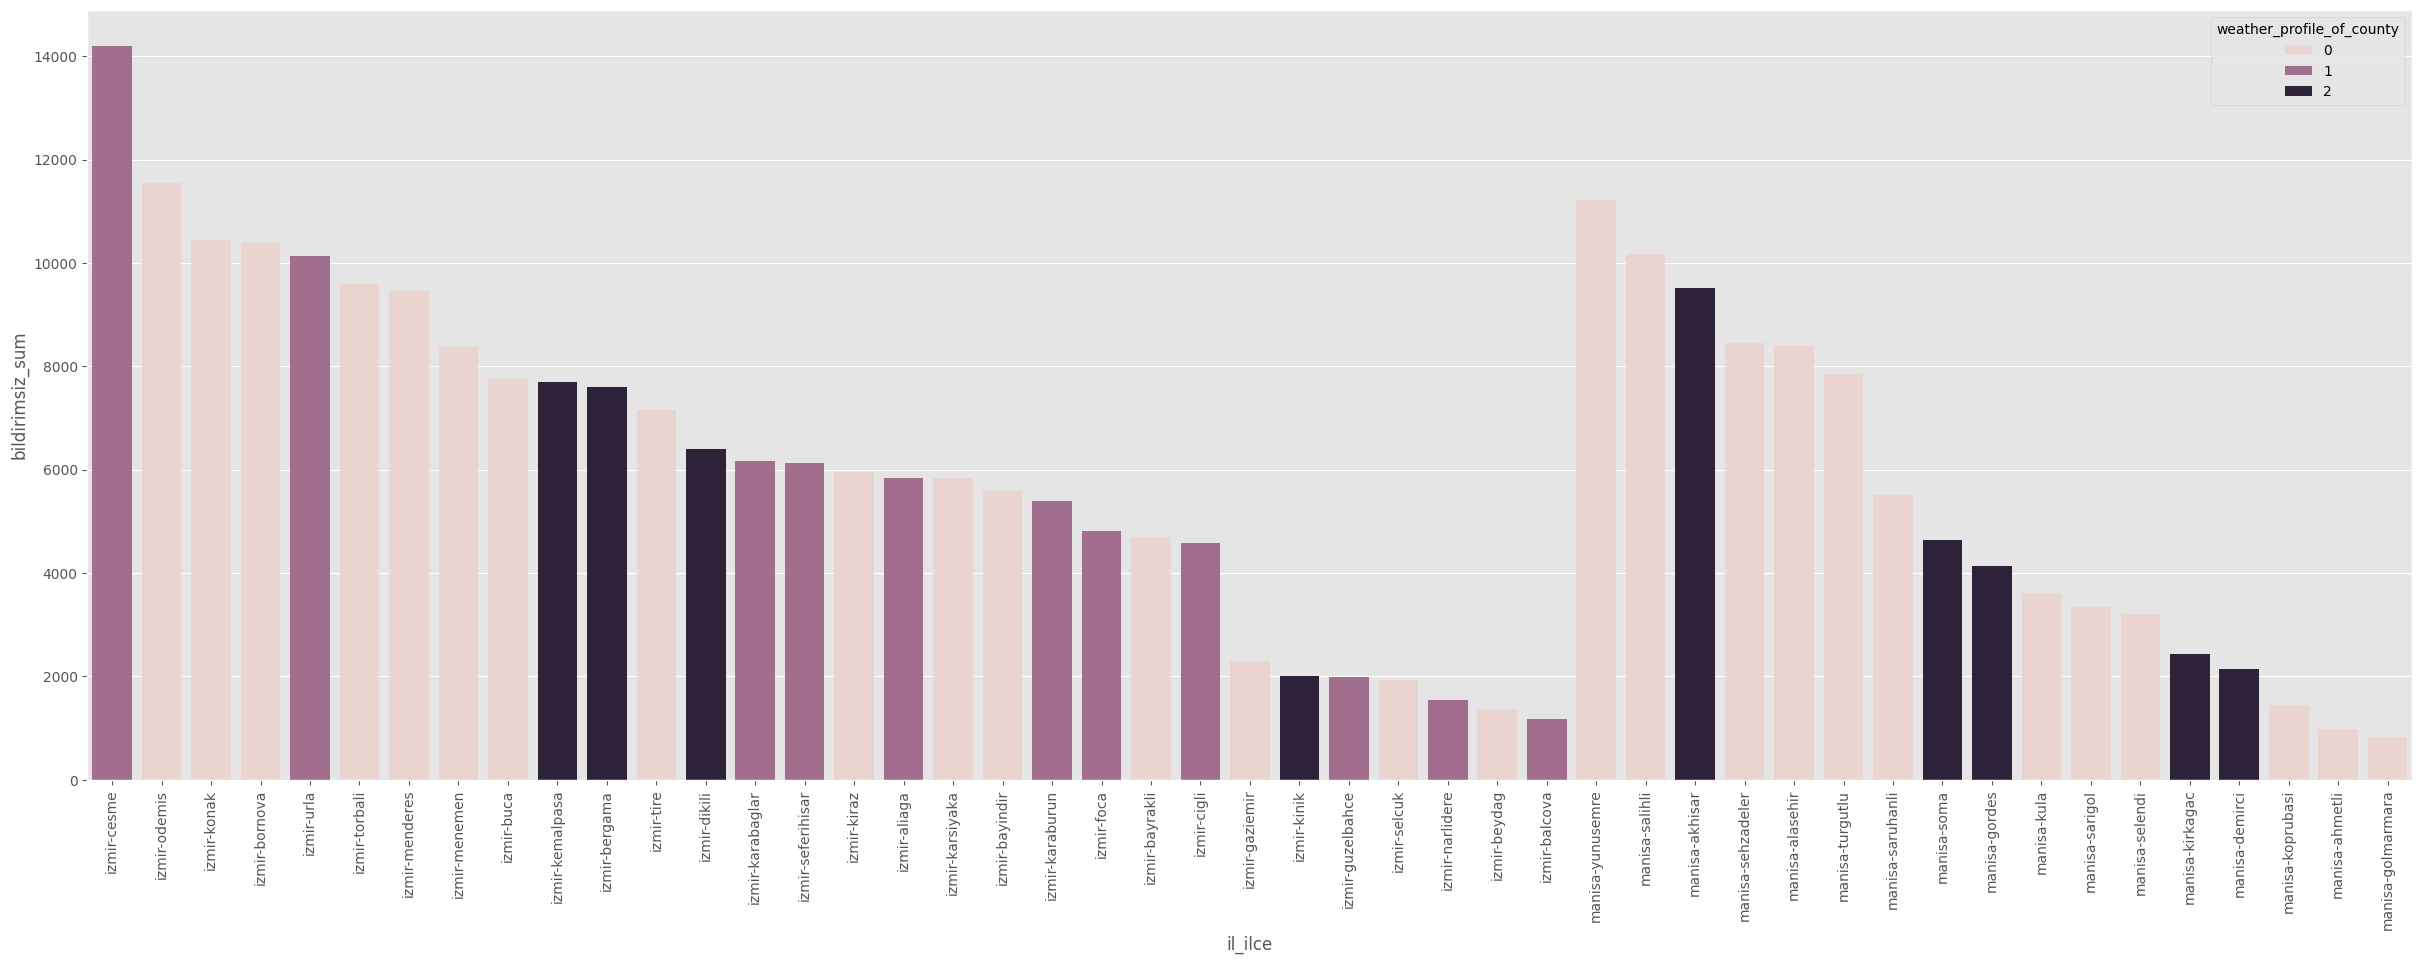

In [92]:
plt.figure(figsize=(30,10))
sns.barplot(x="il_ilce",y="bildirimsiz_sum",data=weather_kmeans_df,hue="weather_profile_of_county")
plt.xticks(rotation=90)
plt.show()

In [93]:
train_test_concat.groupby("weather_profile_of_county")["bildirimsiz_sum"].sum().reset_index()

weather_profile_of_county  bildirimsiz_sum
0                          0         167342.0
1                          1          61961.0
2                          2          46558.0

**Koordinat Özellikleri**
* Konum kümesi

In [94]:
coord_features_df = train_test_concat.groupby("il_ilce")[["lat","long"]].mean().reset_index()
coord_features_df.head()

il_ilce      lat     long
0    izmir-aliaga  38.7996  26.9707
1   izmir-balcova  38.3891  27.0500
2  izmir-bayindir  38.2178  27.6478
3  izmir-bayrakli  38.4612  27.1881
4   izmir-bergama  39.1214  27.1799

In [95]:
# inertia_coords = []
# for k in range(1, 11):
#     kmeans_coord = KMeans(n_clusters=k, random_state=42,n_init=100)
#     kmeans_coord.fit(coord_features_df[["lat","long"]])
#     inertia_coords.append(kmeans_coord.inertia_)

# # Elbow yöntemi ile belirlenen küme sayısını görselleştirin
# plt.plot(range(1, 11), inertia_coords, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Inertia')
# plt.title('Elbow Method for Optimal k')
# plt.show()

In [96]:
pipeline_coord = Pipeline([("scaler",StandardScaler()),
                    ("kmeans",KMeans(n_clusters=3,random_state=42,n_init=100))])
pipeline_coord.fit(coord_features_df.select_dtypes(exclude="object"))
coord_features_df["coords_clusters"] = pipeline_coord.predict(coord_features_df.select_dtypes(exclude="object"))
coord_features_df.head()

il_ilce      lat     long  coords_clusters
0    izmir-aliaga  38.7996  26.9707                2
1   izmir-balcova  38.3891  27.0500                0
2  izmir-bayindir  38.2178  27.6478                0
3  izmir-bayrakli  38.4612  27.1881                0
4   izmir-bergama  39.1214  27.1799                2

In [97]:
coord_series = coord_features_df[["il_ilce","coords_clusters"]].set_index("il_ilce")["coords_clusters"]
train_test_concat["coords_clusters"] = train_test_concat["il_ilce"].map(coord_series)
train_test_concat.groupby(["il_ilce","coords_clusters"])["bildirimsiz_sum"].sum().reset_index().head()

il_ilce  coords_clusters  bildirimsiz_sum
0    izmir-aliaga                2           5840.0
1   izmir-balcova                0           1178.0
2  izmir-bayindir                0           5595.0
3  izmir-bayrakli                0           4705.0
4   izmir-bergama                2           7606.0

In [98]:
coord_kmeans_df = train_test_concat.groupby(["il", "ilce","coords_clusters"])["bildirimsiz_sum"].sum().reset_index().sort_values(by=["il", "bildirimsiz_sum"], ascending=[True, False])
coord_kmeans_df["il_ilce"] = coord_kmeans_df["il"] + "-" + coord_kmeans_df["ilce"]
coord_kmeans_df = coord_kmeans_df.drop(columns=["il", "ilce"])
coord_kmeans_df = coord_kmeans_df[["il_ilce", "bildirimsiz_sum","coords_clusters"]].reset_index(drop=True)
coord_kmeans_df.head()

il_ilce  bildirimsiz_sum  coords_clusters
0    izmir-cesme          14189.0                0
1   izmir-odemis          11543.0                1
2    izmir-konak          10437.0                0
3  izmir-bornova          10382.0                0
4     izmir-urla          10125.0                0

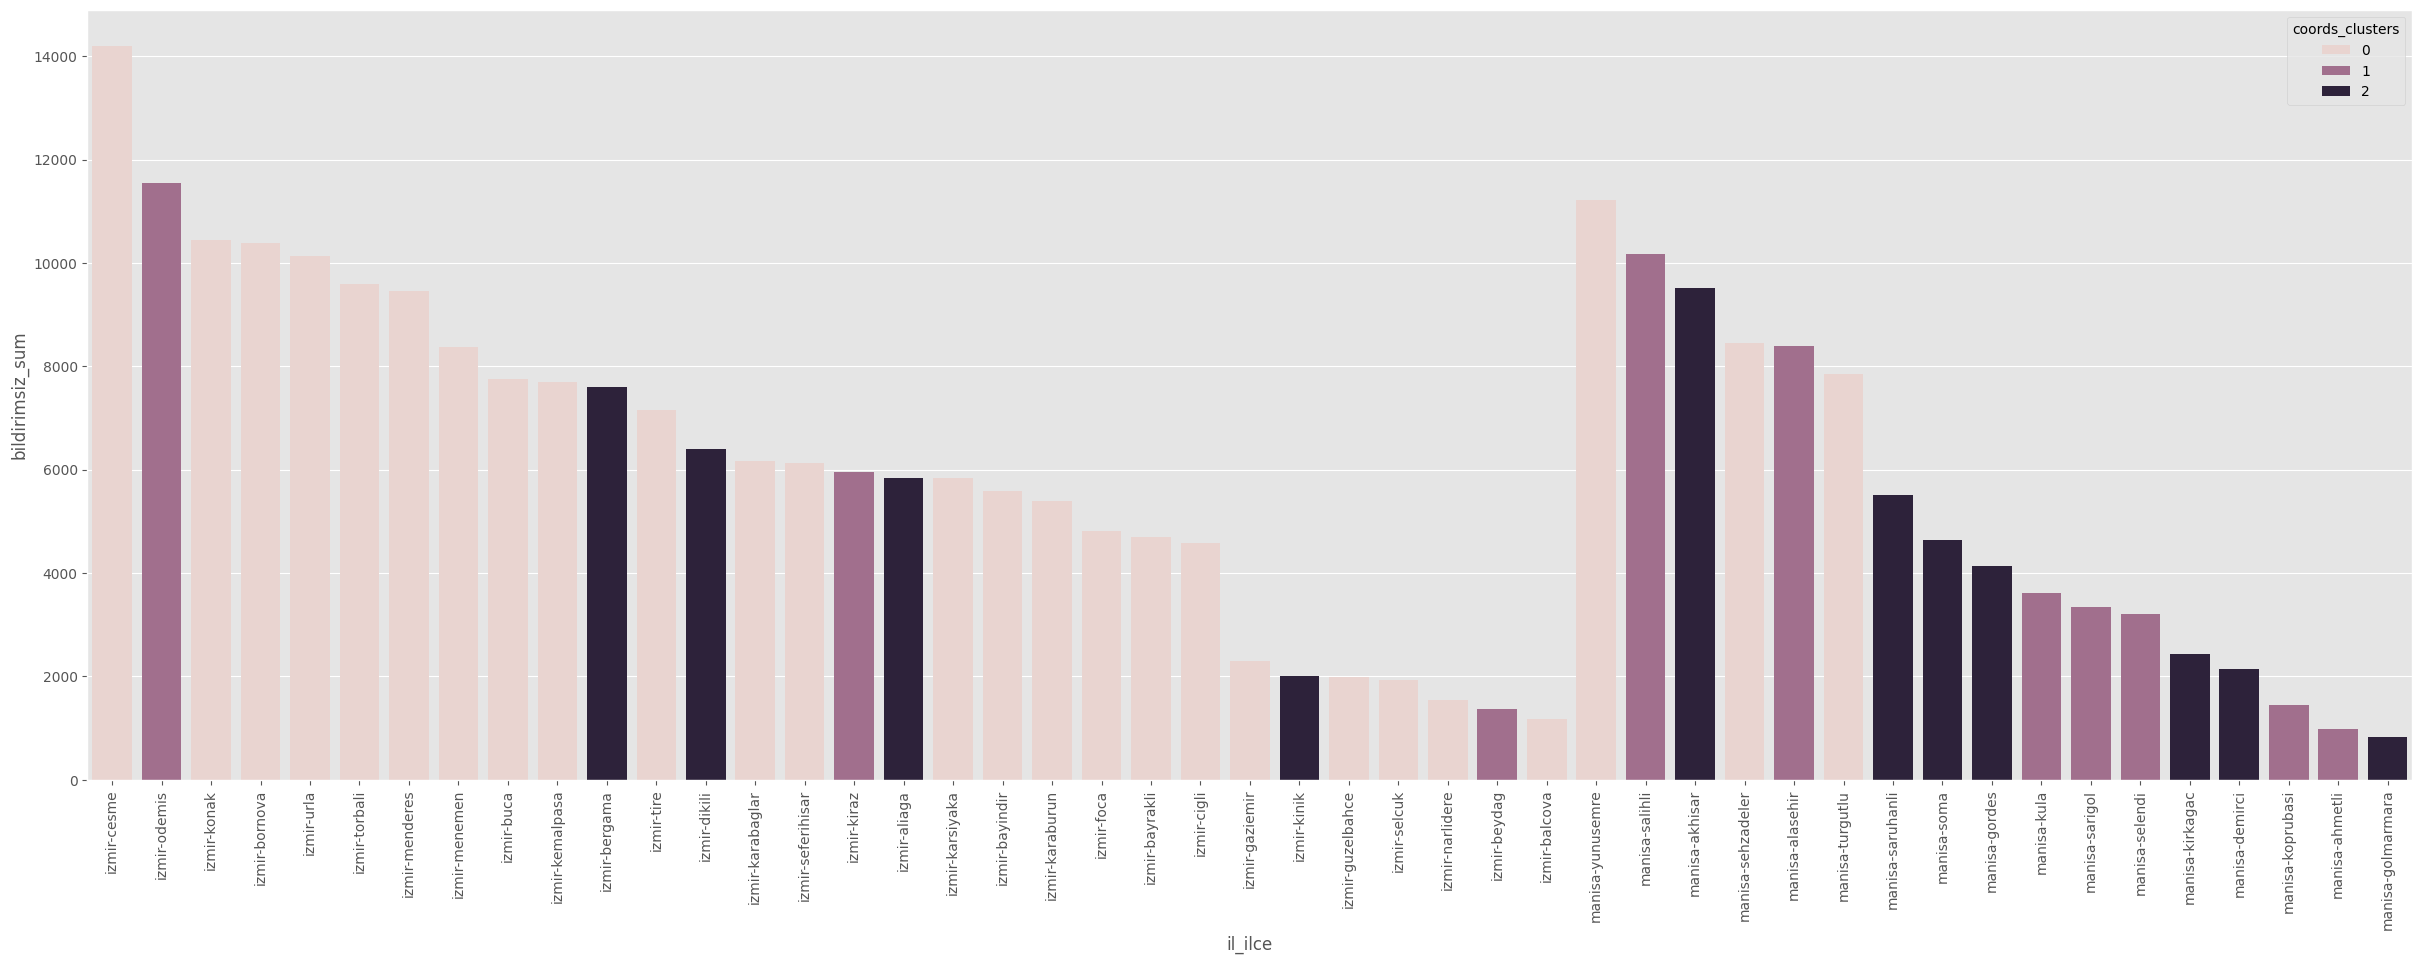

In [99]:
plt.figure(figsize=(30,10))
sns.barplot(x="il_ilce",y="bildirimsiz_sum",data=coord_kmeans_df,hue="coords_clusters")
plt.xticks(rotation=90)
plt.show()

**Time series özellikleri**

In [100]:
temp_train = train_test_concat[train_test_concat["unique_id"].isin(train["unique_id"])]
temp_test = train_test_concat[train_test_concat["unique_id"].isin(test["unique_id"])]

time_series_train_group = temp_train.groupby("tarih")[["bildirimsiz_sum","bildirimli_sum"]].sum().reset_index()
time_series_train_group["tarih"] = pd.to_datetime(time_series_train_group["tarih"])
time_series_train_group.head()

tarih  bildirimsiz_sum  bildirimli_sum
0 2021-01-01            220.0               4
1 2021-01-02            216.0              17
2 2021-01-03            168.0              20
3 2021-01-04            196.0              30
4 2021-01-05            476.0              30

In [101]:
time_series_train_group["bildirimsiz_rolling_3_month"] = time_series_train_group["bildirimsiz_sum"].rolling(window=90).mean()
time_series_train_group["bildirimsiz_pct_change_3_month"] = time_series_train_group["bildirimsiz_sum"].pct_change(periods=90)
time_series_train_group["bildirimsiz_diff_3_month"] = time_series_train_group["bildirimsiz_sum"].diff(periods=90)

seasonal_decomposed = seasonal_decompose(time_series_train_group["bildirimsiz_sum"], period=90)
time_series_train_group["bildirimsiz_seasonal_3_month"] = seasonal_decomposed.seasonal
time_series_train_group["bildirimsiz_trend_3_month"] = seasonal_decomposed.trend
time_series_train_group["bildirimsiz_residuel_3_month"] = seasonal_decomposed.resid

time_series_train_group["bildirimli_rolling_3_month"] = time_series_train_group["bildirimli_sum"].rolling(window=90).mean()
#time_series_train_group["bildirimli_pct_change_1_month"] = time_series_train_group["bildirimli_sum"].pct_change(periods=30)
time_series_train_group["bildirimli_diff_3_month"] = time_series_train_group["bildirimli_sum"].diff(periods=90)

seasonal_decomposed = seasonal_decompose(time_series_train_group["bildirimli_sum"], period=90)
time_series_train_group["bildirimli_seasonal_3_month"] = seasonal_decomposed.seasonal
time_series_train_group["bildirimli_trend_3_month"] = seasonal_decomposed.trend
time_series_train_group["bildirimli_residuel_3_month"] = seasonal_decomposed.resid

time_series_train_group.fillna(method="bfill", inplace=True)
time_series_train_group.drop(["bildirimsiz_sum","bildirimli_sum"],inplace=True,axis=1)
time_series_train_group.head()

tarih  bildirimsiz_rolling_3_month  bildirimsiz_pct_change_3_month  \
0 2021-01-01                   324.633333                        0.072727   
1 2021-01-02                   324.633333                        0.072727   
2 2021-01-03                   324.633333                        0.072727   
3 2021-01-04                   324.633333                        0.072727   
4 2021-01-05                   324.633333                        0.072727   

   bildirimsiz_diff_3_month  bildirimsiz_seasonal_3_month  \
0                      16.0                    -26.762171   
1                      16.0                    -26.284393   
2                      16.0                    -32.802575   
3                      16.0                    -16.423282   
4                      16.0                    -21.205606   

   bildirimsiz_trend_3_month  bildirimsiz_residuel_3_month  \
0                 324.722222                    -16.624571   
1                 324.722222                    -16.624571   
2                 324.722222                    -16.624571   
3                 324.722222                    -16.624571   
4                 324.722222                    -16.624571   

   bildirimli_rolling_3_month  bildirimli_diff_3_month  \
0                   33.844444                     21.0   
1                   33.844444                     21.0   
2                   33.844444                     21.0   
3                   33.844444                     21.0   
4                   33.844444                     21.0   

   bildirimli_seasonal_3_month  bildirimli_trend_3_month  \
0                     5.077216                 33.961111   
1                     5.785802                 33.961111   
2                     9.311055                 33.961111   
3                    13.846913                 33.961111   
4                     3.127721                 33.961111   

   bildirimli_residuel_3_month  
0                    -8.543336  
1                    -8.543336  
2                    -8.543336  
3                    -8.543336  
4                    -8.543336

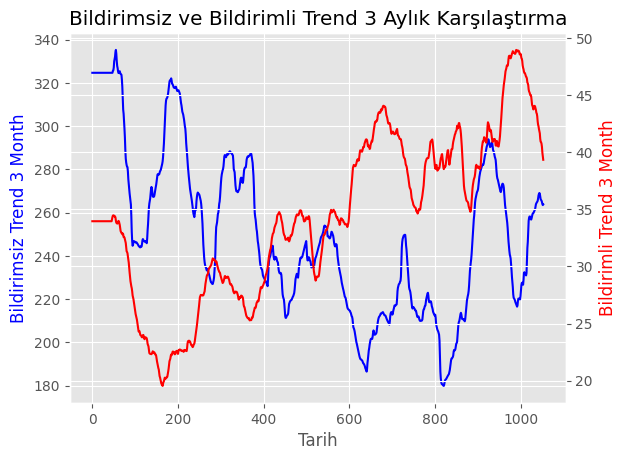

In [102]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  
time_series_train_group["bildirimsiz_trend_3_month"].plot(ax=ax1, color="blue", label="Bildirimsiz Trend 3 Month")
ax1.set_ylabel("Bildirimsiz Trend 3 Month", color="blue")
time_series_train_group["bildirimli_trend_3_month"].plot(ax=ax2, color="red", label="Bildirimli Trend 3 Month")
ax2.set_ylabel("Bildirimli Trend 3 Month", color="red")
ax1.set_xlabel("Tarih")
plt.title("Bildirimsiz ve Bildirimli Trend 3 Aylık Karşılaştırma")
plt.show()

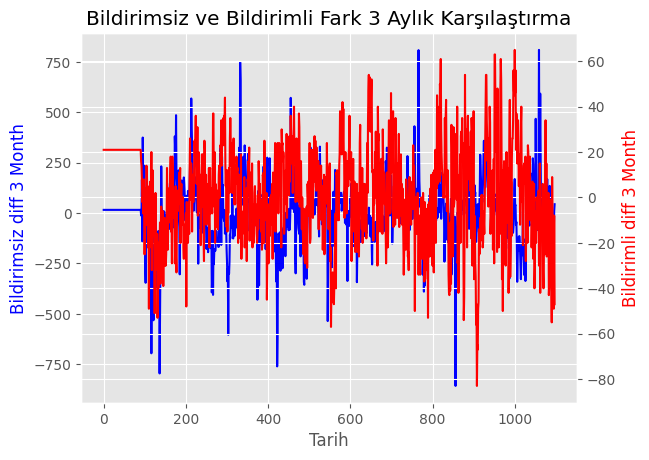

In [103]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  
time_series_train_group["bildirimsiz_diff_3_month"].plot(ax=ax1, color="blue", label="Bildirimsiz fark 3 Month")
ax1.set_ylabel("Bildirimsiz diff 3 Month", color="blue")
time_series_train_group["bildirimli_diff_3_month"].plot(ax=ax2, color="red", label="Bildirimli fark 3 Month")
ax2.set_ylabel("Bildirimli diff 3 Month", color="red")
ax1.set_xlabel("Tarih")
plt.title("Bildirimsiz ve Bildirimli Fark 3 Aylık Karşılaştırma")
plt.show()

In [104]:
time_series_train_group.describe().T

count                 mean  \
tarih                             1098  2022-07-03 12:00:00   
bildirimsiz_rolling_3_month     1098.0           252.786288   
bildirimsiz_pct_change_3_month  1098.0             0.123543   
bildirimsiz_diff_3_month        1098.0            -3.653916   
bildirimsiz_seasonal_3_month    1098.0            -0.005875   
bildirimsiz_trend_3_month       1053.0           249.748465   
bildirimsiz_residuel_3_month    1053.0            -2.003678   
bildirimli_rolling_3_month      1098.0            34.250951   
bildirimli_diff_3_month         1098.0             2.150273   
bildirimli_seasonal_3_month     1098.0             0.010397   
bildirimli_trend_3_month        1053.0            34.270824   
bildirimli_residuel_3_month     1053.0            -0.262551   

                                                min                  25%  \
tarih                           2021-01-01 00:00:00  2021-10-02 06:00:00   
bildirimsiz_rolling_3_month              179.777778           220.041667   
bildirimsiz_pct_change_3_month            -0.854582             -0.26604   
bildirimsiz_diff_3_month                     -858.0                -69.0   
bildirimsiz_seasonal_3_month             -66.895336           -17.815202   
bildirimsiz_trend_3_month                179.827778                219.4   
bildirimsiz_residuel_3_month            -199.306516           -54.197256   
bildirimli_rolling_3_month                19.488889            28.963889   
bildirimli_diff_3_month                       -83.0                -12.0   
bildirimli_seasonal_3_month              -11.455107             -2.33137   
bildirimli_trend_3_month                  19.544444            28.722222   
bildirimli_residuel_3_month              -39.324691            -8.543336   

                                                50%                  75%  \
tarih                           2022-07-03 12:00:00  2023-04-03 18:00:00   
bildirimsiz_rolling_3_month              246.211111           279.966667   
bildirimsiz_pct_change_3_month             0.021338              0.30556   
bildirimsiz_diff_3_month                        4.5                60.75   
bildirimsiz_seasonal_3_month              -4.138939            17.956516   
bildirimsiz_trend_3_month                244.733333           275.311111   
bildirimsiz_residuel_3_month             -16.624571            21.803585   
bildirimli_rolling_3_month                33.861111            40.119444   
bildirimli_diff_3_month                         3.0                 19.0   
bildirimli_seasonal_3_month                0.227974             2.283782   
bildirimli_trend_3_month                  34.088889            40.288889   
bildirimli_residuel_3_month                0.174299             8.232885   

                                                max         std  
tarih                           2024-01-03 00:00:00         NaN  
bildirimsiz_rolling_3_month                   335.7   39.523981  
bildirimsiz_pct_change_3_month             4.148718    0.627531  
bildirimsiz_diff_3_month                      810.0  154.192721  
bildirimsiz_seasonal_3_month              93.810219   28.306471  
bildirimsiz_trend_3_month                335.305556   37.431226  
bildirimsiz_residuel_3_month             700.217558   93.167277  
bildirimli_rolling_3_month                48.977778    7.084249  
bildirimli_diff_3_month                        65.0   21.424736  
bildirimli_seasonal_3_month               13.846913    3.998928  
bildirimli_trend_3_month                  48.955556    7.231711  
bildirimli_residuel_3_month               44.564198   13.005846

**Test setine nan kolonlar eklenmesi**

In [105]:
train_feature_list=time_series_train_group.loc[:,time_series_train_group.columns.str.contains("bildirimsiz|bildirimli")].columns.to_list()
train_feature_list

['bildirimsiz_rolling_3_month',
 'bildirimsiz_pct_change_3_month',
 'bildirimsiz_diff_3_month',
 'bildirimsiz_seasonal_3_month',
 'bildirimsiz_trend_3_month',
 'bildirimsiz_residuel_3_month',
 'bildirimli_rolling_3_month',
 'bildirimli_diff_3_month',
 'bildirimli_seasonal_3_month',
 'bildirimli_trend_3_month',
 'bildirimli_residuel_3_month']

In [106]:
time_series_train_group.head()

tarih  bildirimsiz_rolling_3_month  bildirimsiz_pct_change_3_month  \
0 2021-01-01                   324.633333                        0.072727   
1 2021-01-02                   324.633333                        0.072727   
2 2021-01-03                   324.633333                        0.072727   
3 2021-01-04                   324.633333                        0.072727   
4 2021-01-05                   324.633333                        0.072727   

   bildirimsiz_diff_3_month  bildirimsiz_seasonal_3_month  \
0                      16.0                    -26.762171   
1                      16.0                    -26.284393   
2                      16.0                    -32.802575   
3                      16.0                    -16.423282   
4                      16.0                    -21.205606   

   bildirimsiz_trend_3_month  bildirimsiz_residuel_3_month  \
0                 324.722222                    -16.624571   
1                 324.722222                    -16.624571   
2                 324.722222                    -16.624571   
3                 324.722222                    -16.624571   
4                 324.722222                    -16.624571   

   bildirimli_rolling_3_month  bildirimli_diff_3_month  \
0                   33.844444                     21.0   
1                   33.844444                     21.0   
2                   33.844444                     21.0   
3                   33.844444                     21.0   
4                   33.844444                     21.0   

   bildirimli_seasonal_3_month  bildirimli_trend_3_month  \
0                     5.077216                 33.961111   
1                     5.785802                 33.961111   
2                     9.311055                 33.961111   
3                    13.846913                 33.961111   
4                     3.127721                 33.961111   

   bildirimli_residuel_3_month  
0                    -8.543336  
1                    -8.543336  
2                    -8.543336  
3                    -8.543336  
4                    -8.543336

**Test grup oluşturulması ve tahminlerin test setine eklenmesi**

In [107]:
time_series_test_group = temp_test.groupby("tarih")[["bildirimsiz_sum","bildirimli_sum"]].sum().reset_index()
for feature in train_feature_list:
    time_series_test_group[feature] = np.nan
time_series_test_group["tarih"] = pd.to_datetime(time_series_test_group["tarih"])
time_series_test_group.drop(["bildirimsiz_sum","bildirimli_sum"],inplace=True,axis=1)
time_series_test_group.head()

tarih  bildirimsiz_rolling_3_month  bildirimsiz_pct_change_3_month  \
0 2024-01-04                          NaN                             NaN   
1 2024-01-05                          NaN                             NaN   
2 2024-01-06                          NaN                             NaN   
3 2024-01-07                          NaN                             NaN   
4 2024-01-08                          NaN                             NaN   

   bildirimsiz_diff_3_month  bildirimsiz_seasonal_3_month  \
0                       NaN                           NaN   
1                       NaN                           NaN   
2                       NaN                           NaN   
3                       NaN                           NaN   
4                       NaN                           NaN   

   bildirimsiz_trend_3_month  bildirimsiz_residuel_3_month  \
0                        NaN                           NaN   
1                        NaN                           NaN   
2                        NaN                           NaN   
3                        NaN                           NaN   
4                        NaN                           NaN   

   bildirimli_rolling_3_month  bildirimli_diff_3_month  \
0                         NaN                      NaN   
1                         NaN                      NaN   
2                         NaN                      NaN   
3                         NaN                      NaN   
4                         NaN                      NaN   

   bildirimli_seasonal_3_month  bildirimli_trend_3_month  \
0                          NaN                       NaN   
1                          NaN                       NaN   
2                          NaN                       NaN   
3                          NaN                       NaN   
4                          NaN                       NaN   

   bildirimli_residuel_3_month  
0                          NaN  
1                          NaN  
2                          NaN  
3                          NaN  
4                          NaN

In [108]:
def predict_ts_features_and_write_to_test_df(test_df: pd.DataFrame, train_df: pd.DataFrame, feature_list: list, date_col_name: str):
    
    test_df_copy = test_df.copy()
    for feature in feature_list:
        df = train_df[[date_col_name, feature]].copy()
        df.rename(columns={date_col_name: "ds", feature: "y"}, inplace=True)
        model = Prophet()
        model.fit(df)
        future = model.make_future_dataframe(periods=len(test_df))
        forecast = model.predict(future)
        test_df_copy[feature] = forecast["yhat"]
    print("Features have been predicted and written to the test DataFrame!")
    print("---------------------")
    return test_df_copy

In [109]:
time_series_test_group = predict_ts_features_and_write_to_test_df(time_series_test_group,time_series_train_group,train_feature_list, "tarih")
time_series_test_group.head()


08:47:33 - cmdstanpy - INFO - Chain [1] start processing


08:47:34 - cmdstanpy - INFO - Chain [1] done processing
08:47:34 - cmdstanpy - INFO - Chain [1] start processing
08:47:34 - cmdstanpy - INFO - Chain [1] done processing
08:47:35 - cmdstanpy - INFO - Chain [1] start processing
08:47:35 - cmdstanpy - INFO - Chain [1] done processing
08:47:35 - cmdstanpy - INFO - Chain [1] start processing
08:47:35 - cmdstanpy - INFO - Chain [1] done processing
08:47:36 - cmdstanpy - INFO - Chain [1] start processing
08:47:36 - cmdstanpy - INFO - Chain [1] done processing
08:47:36 - cmdstanpy - INFO - Chain [1] start processing
08:47:37 - cmdstanpy - INFO - Chain [1] done processing
08:47:37 - cmdstanpy - INFO - Chain [1] start processing
08:47:37 - cmdstanpy - INFO - Chain [1] done processing
08:47:38 - cmdstanpy - INFO - Chain [1] start processing
08:47:38 - cmdstanpy - INFO - Chain [1] done processing
08:47:38 - cmdstanpy - INFO - Chain [1] start processing
08:47:38 - cmdstanpy - INFO - Chain [1] done processing
08:47:39 - cmdstanpy - INFO - Chain [1] 

Features have been predicted and written to the test DataFrame!
---------------------


tarih  bildirimsiz_rolling_3_month  bildirimsiz_pct_change_3_month  \
0 2024-01-04                   321.879807                       -0.109268   
1 2024-01-05                   322.237493                        0.049761   
2 2024-01-06                   321.859883                       -0.249824   
3 2024-01-07                   321.613583                       -0.164463   
4 2024-01-08                   321.282545                       -0.195411   

   bildirimsiz_diff_3_month  bildirimsiz_seasonal_3_month  \
0                -26.126325                     -2.876361   
1                  1.202591                     -1.766885   
2                -63.816056                     -0.686366   
3                -50.764448                     -0.118282   
4                -57.058175                     -0.033042   

   bildirimsiz_trend_3_month  bildirimsiz_residuel_3_month  \
0                 335.672450                    -63.827029   
1                 335.662451                    -62.876298   
2                 335.555056                    -91.188191   
3                 335.373674                    -63.506059   
4                 335.012571                    -61.926811   

   bildirimli_rolling_3_month  bildirimli_diff_3_month  \
0                   34.346173                 5.943412   
1                   34.308347                 5.333152   
2                   34.210878                 0.084381   
3                   34.138597                 2.435877   
4                   34.174436                12.255328   

   bildirimli_seasonal_3_month  bildirimli_trend_3_month  \
0                     1.136383                 36.153769   
1                     0.795510                 35.976796   
2                     0.586285                 35.737832   
3                     0.335487                 35.489689   
4                    -0.213455                 35.339622   

   bildirimli_residuel_3_month  
0                    -3.654108  
1                    -6.737978  
2                    -9.057043  
3                    -5.949537  
4                    -4.390619

In [110]:
def plot_all_feature_predictions(train_df:pd.DataFrame, test_df:pd.DataFrame, feature_list:list, date_col:str):
    for feature in feature_list:
        plt.figure(figsize=(10, 6))
        plt.plot(train_df[date_col], train_df[feature], label=feature)
        plt.plot(test_df[date_col], test_df[feature], label=feature)
        plt.title("Train ve Tahmin Edilen Değerlerin Grafiksel Karşılaştırması")
        plt.xlabel(date_col)
        plt.ylabel(feature)
        plt.legend()
        plt.grid(True)
        plt.show()

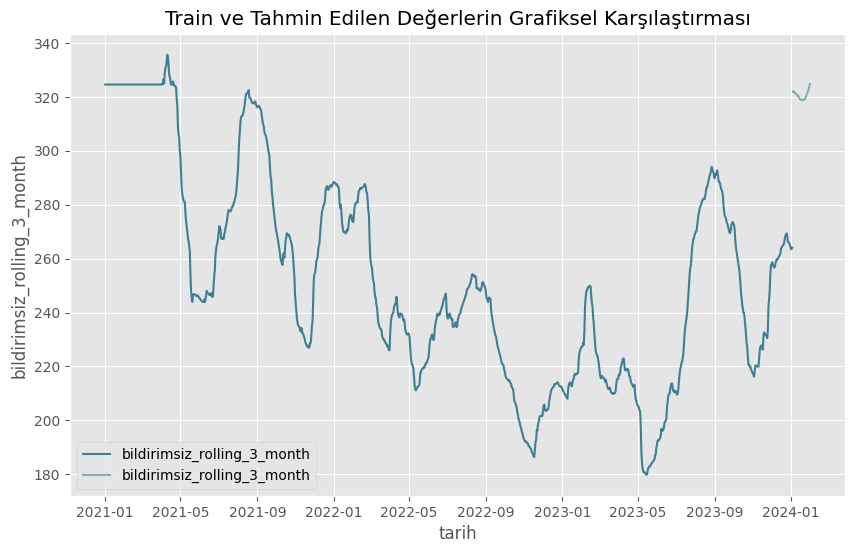

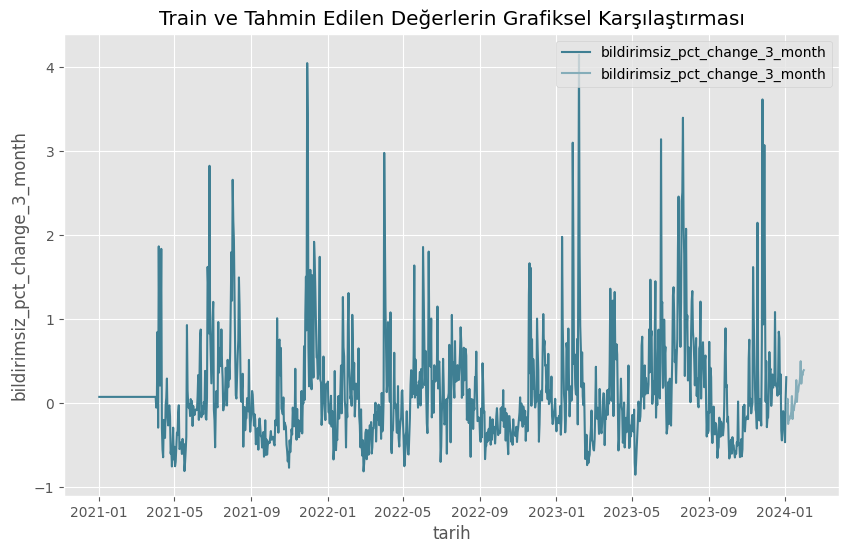

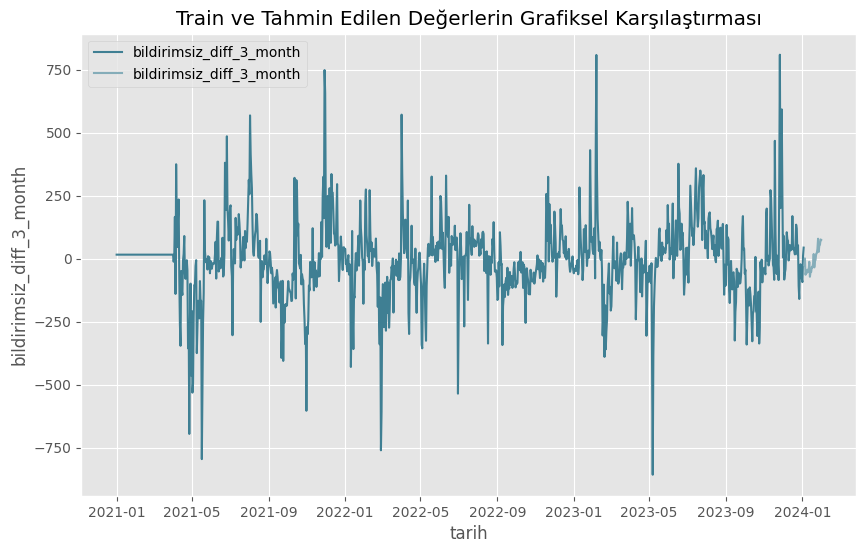

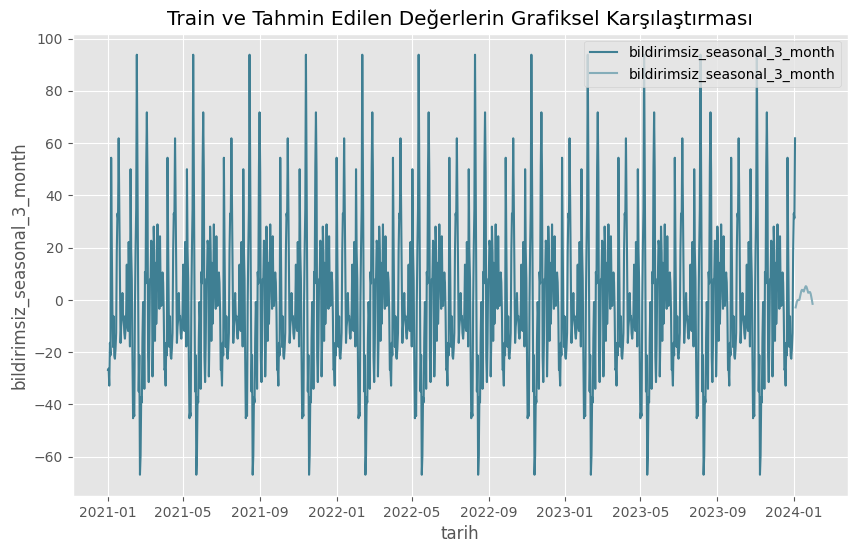

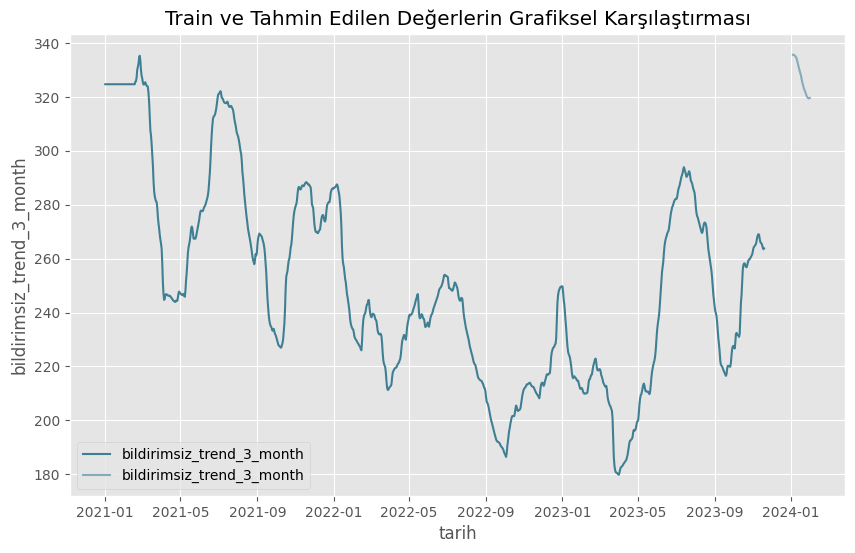

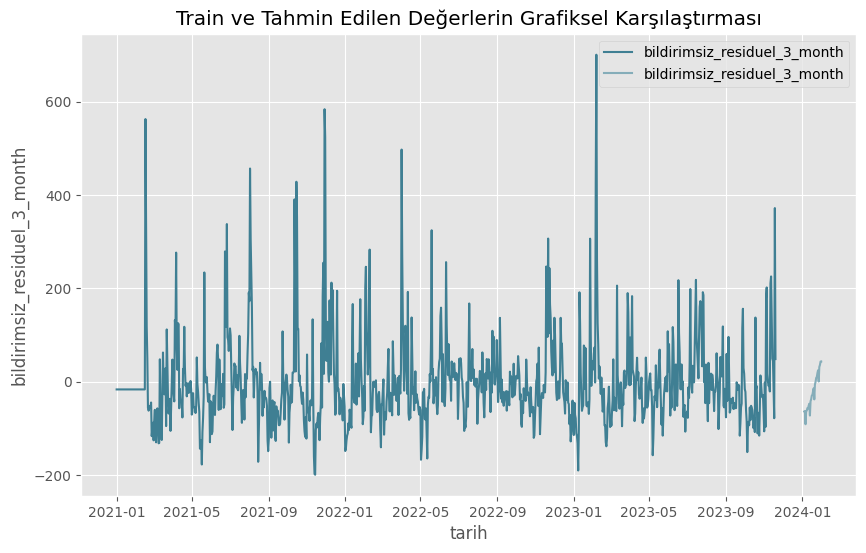

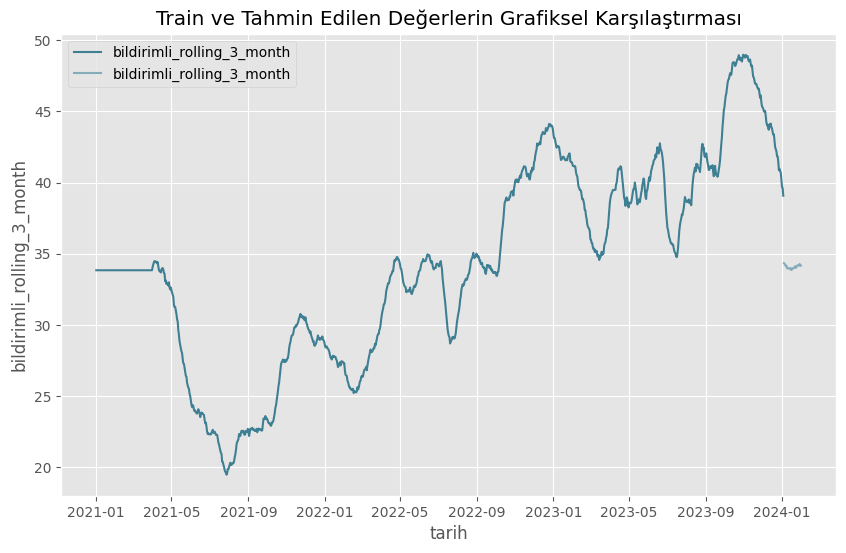

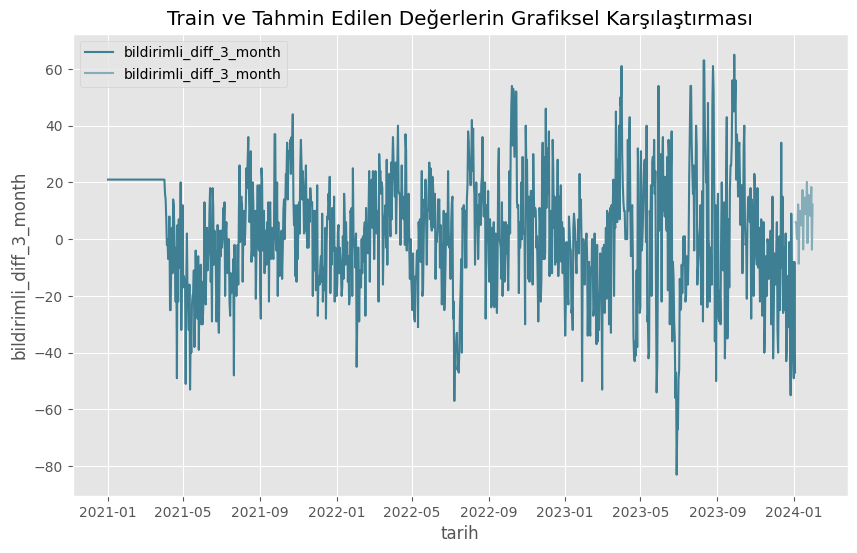

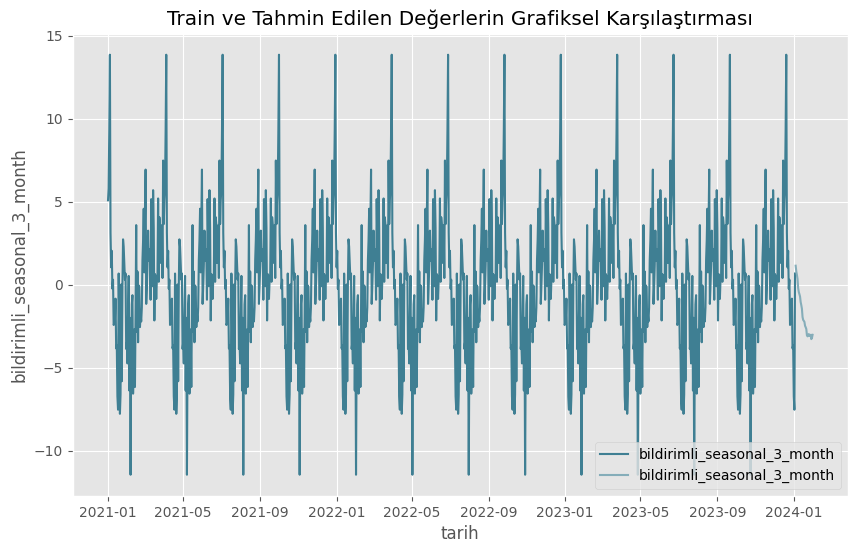

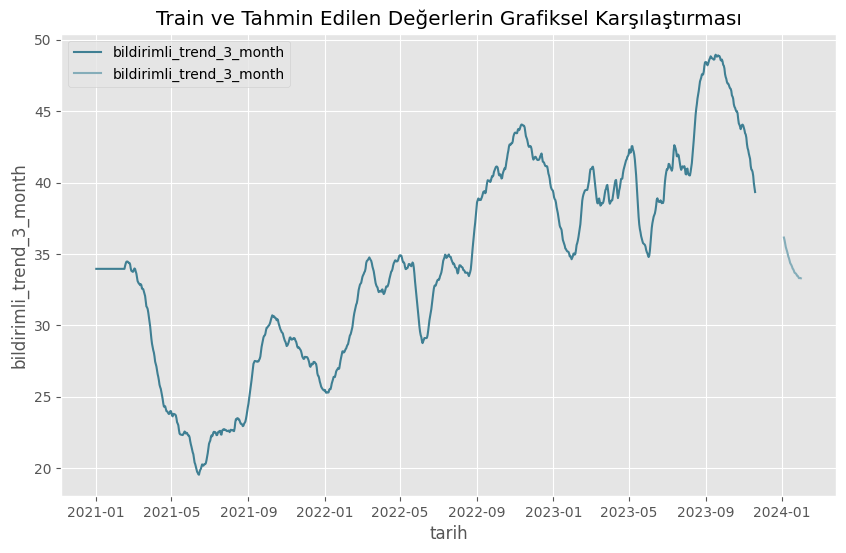

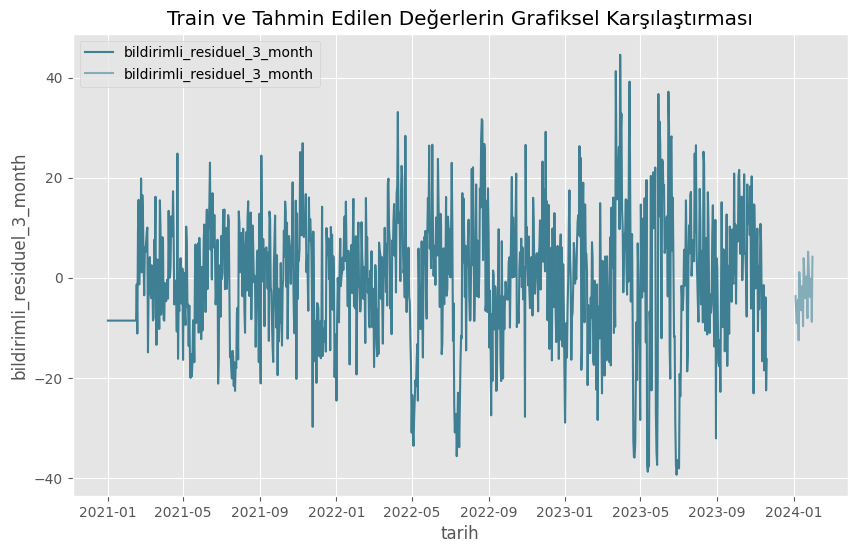

In [111]:
plot_all_feature_predictions(time_series_train_group,time_series_test_group,train_feature_list,"tarih")

**Verilerin tekrar birleştirilmesi**

In [112]:
time_series_train_group["tarih"] = time_series_train_group["tarih"].dt.strftime("%Y-%m-%d")
time_series_test_group["tarih"] = time_series_test_group["tarih"].dt.strftime("%Y-%m-%d")
temp_train = pd.merge(temp_train,time_series_train_group,how="left",on="tarih")
temp_test = pd.merge(temp_test,time_series_test_group,how="left",on="tarih")
train_test_concat=pd.concat([temp_train,temp_test],axis=0)

In [113]:
def plot_features(df:pd.DataFrame,feature_list:list, date_col:str):
    for feature in feature_list:
        plt.figure(figsize=(10, 6))
        plt.plot(df[date_col], df[feature], label=feature)
        plt.title(f"{feature} Grafiği")
        plt.xlabel(date_col)
        plt.ylabel(feature)
        plt.legend()
        plt.grid(True)
        plt.show()

**Kontrol**

In [114]:
# plot_features(train_test_concat,train_feature_list,"tarih")

**Coğrafik Özellikler**

In [115]:
# from geopy.distance import geodesic

# izmir_base_coords = (38.4192, 27.1287)  
# manisa_base_coords = (38.6191, 27.4286)  

# def calculate_distance(row):
#     coords = (row["lat"], row["long"])  
#     distance = geodesic(izmir_coords, coords).kilometers
#     return distance

# train_test_concat[["izmir_center_distance", "manisa_center_distance"]] = train_test_concat.apply(calculate_distance, axis=1)
# train_test_concat.head()

**Korelasyon Analizi**

In [116]:
# sns.pairplot(data=train_test_concat,vars=["bildirimsiz_sum",
#                                           "bildirimli_sum",
#                                           "temp", 
#                                           "cloud_cover", 
#                                           "global_rad", 
#                                           "relative_humidity", 
#                                           "wind_dir", 
#                                           "wind_speed",
#                                           "precip",
#                                           "blackout_ratio_per_city_county","planned_blackout_ratio_per_city_county"])
# plt.show()

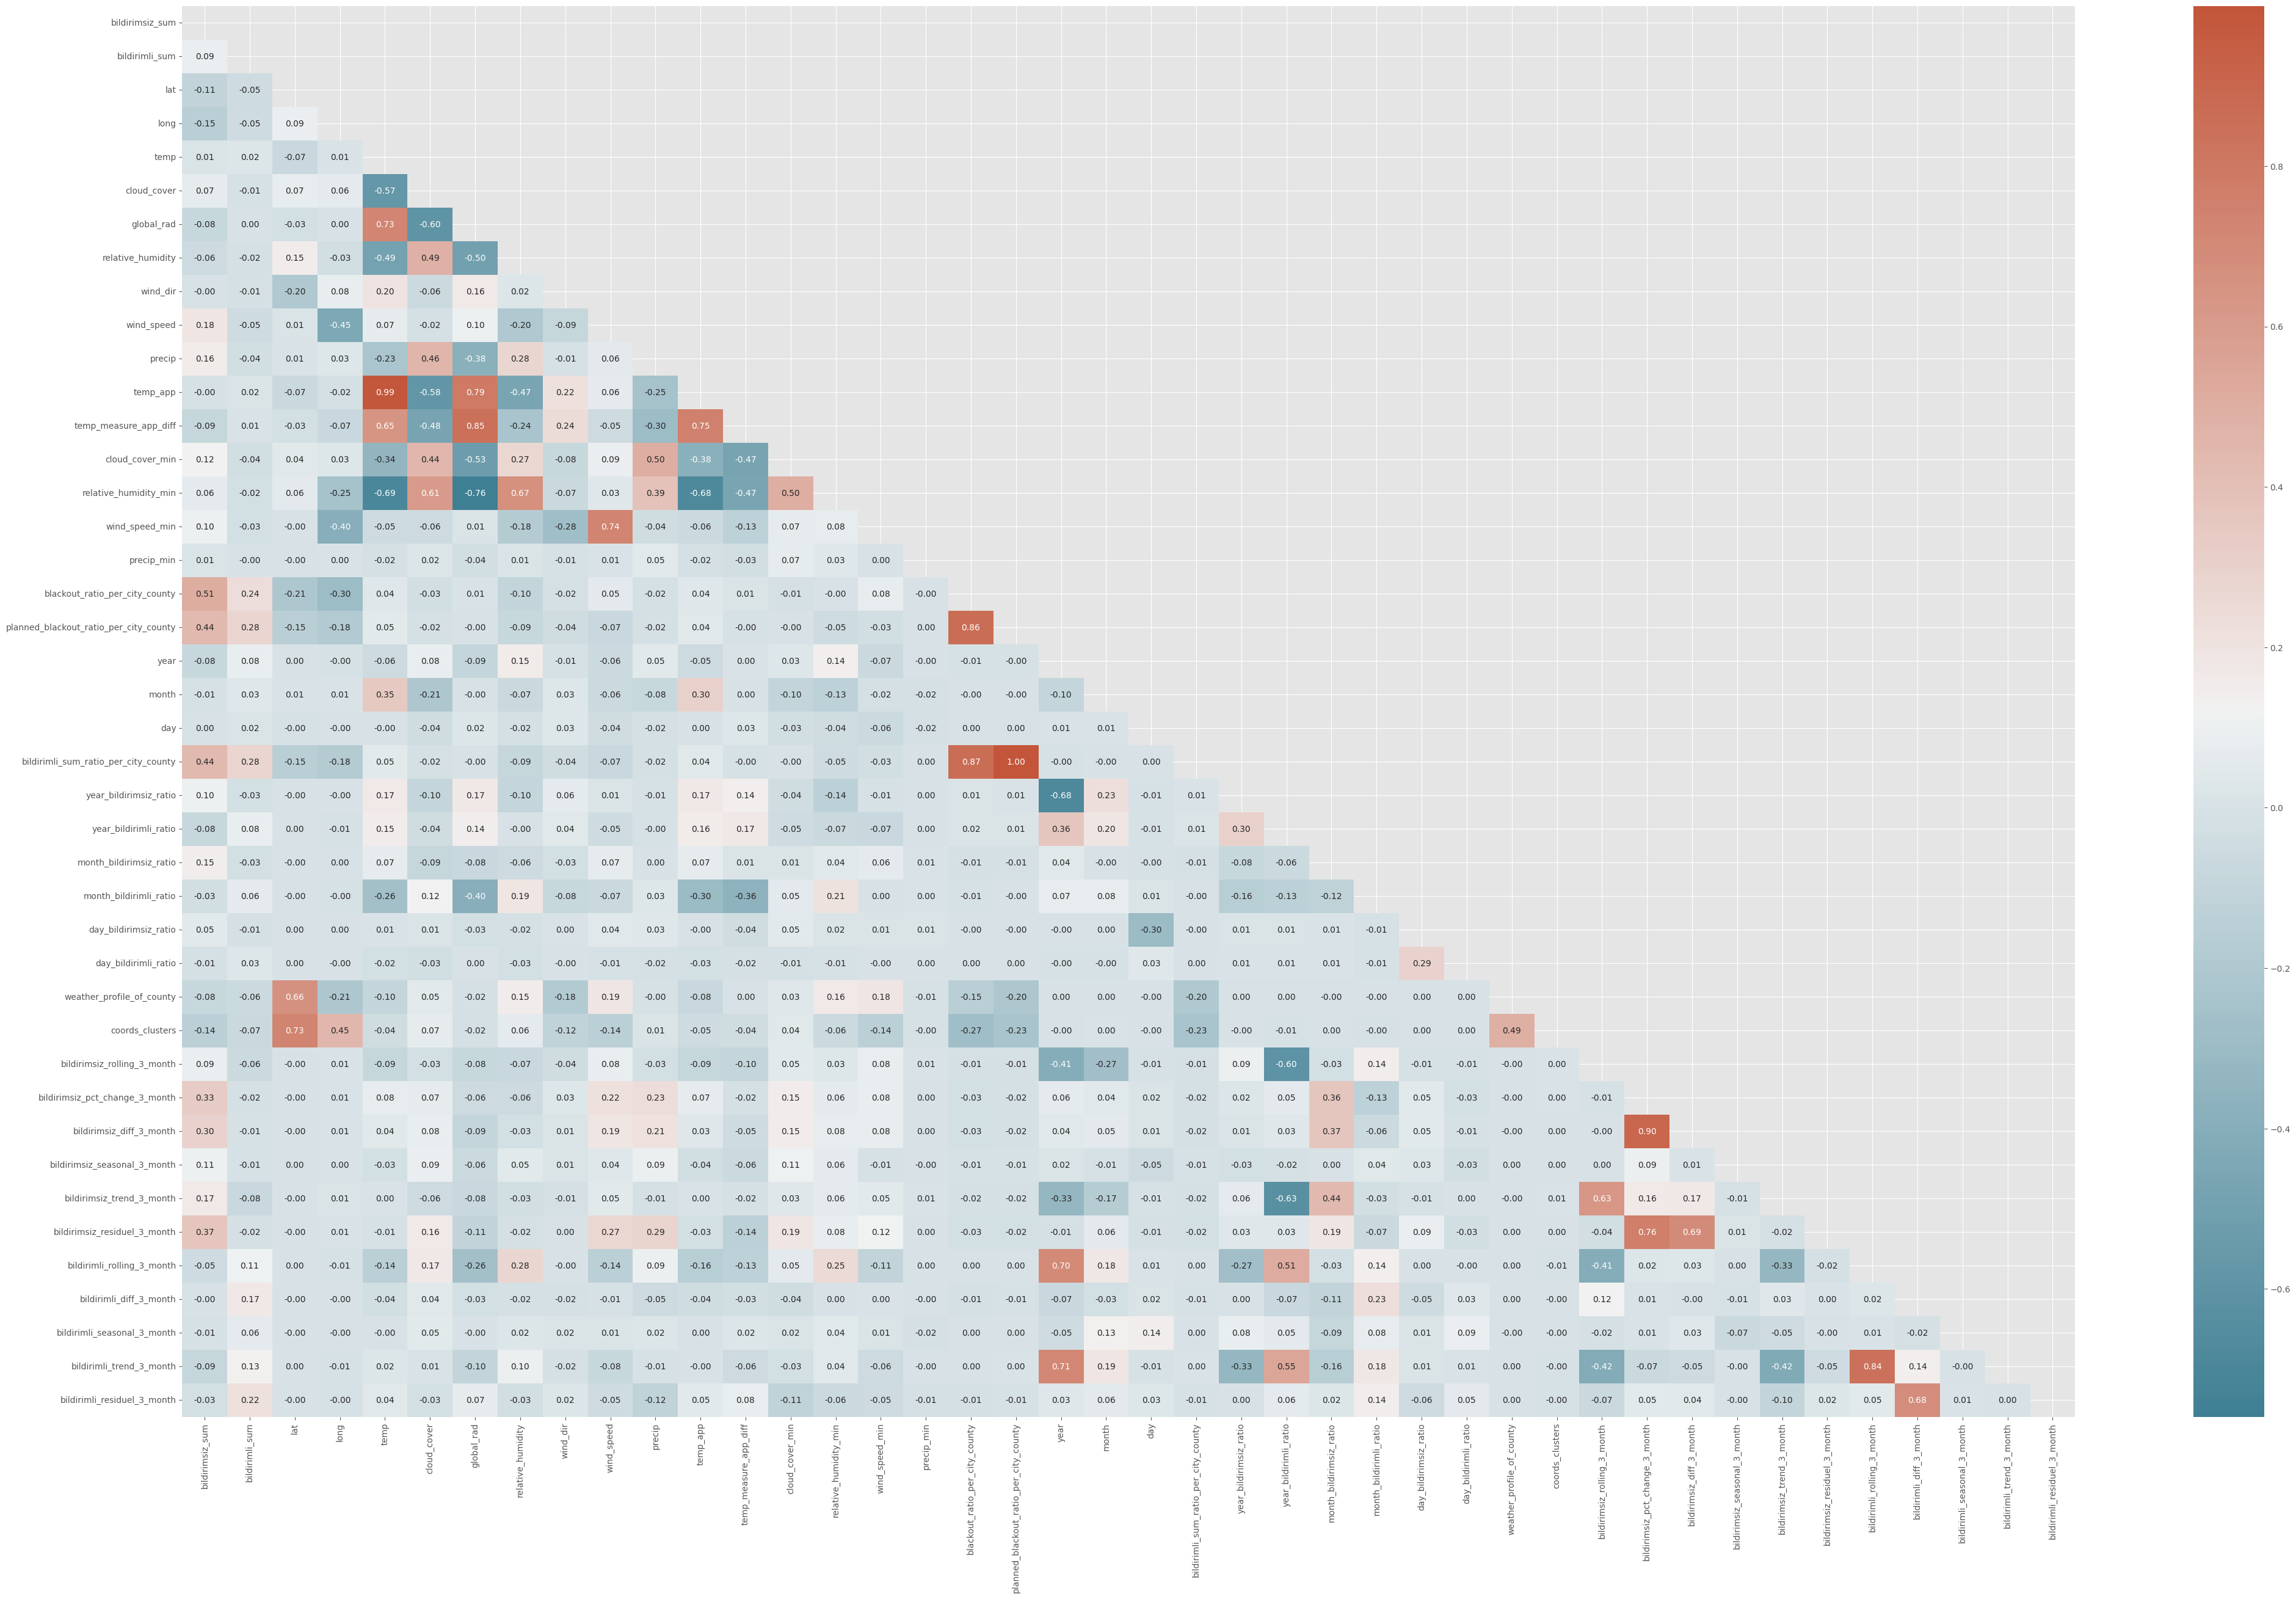

In [117]:
plt.figure(figsize=(50, 30))
num_variables = train_test_concat.select_dtypes(exclude=["object","category"])
corr_df = num_variables.corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
tri_df = corr_df.mask(mask)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(tri_df,annot=True,fmt=".2f",cmap = cmap)
plt.show()

**Multicollinearity probleminden dolayı 0.75 üzeri korelasyonlu olan değişkenlerin 1 tanesi overfittinge yol açmaması için veri setinden çıkarılmıştır. Bu değişkenler;**
- temp ve temp_app: 0.99 korelasyon var, temp_app çıkarıldı. 
- global_rad ve temp_measure_app_diff: 0.85 temp_measure_app_diff çıkarıldı.
- planned_blackout_ratio_per_city_county ve blackout_ratio_per_city_county:0.86 planned_blackout_ratio_per_city_county çıkarıldı.

In [118]:
train_test_concat.drop(["temp_app","temp_measure_app_diff","bildirimsiz_diff_3_month","bildirimli_rolling_3_month","bildirimsiz_diff_3_month"],axis=1,inplace=True)

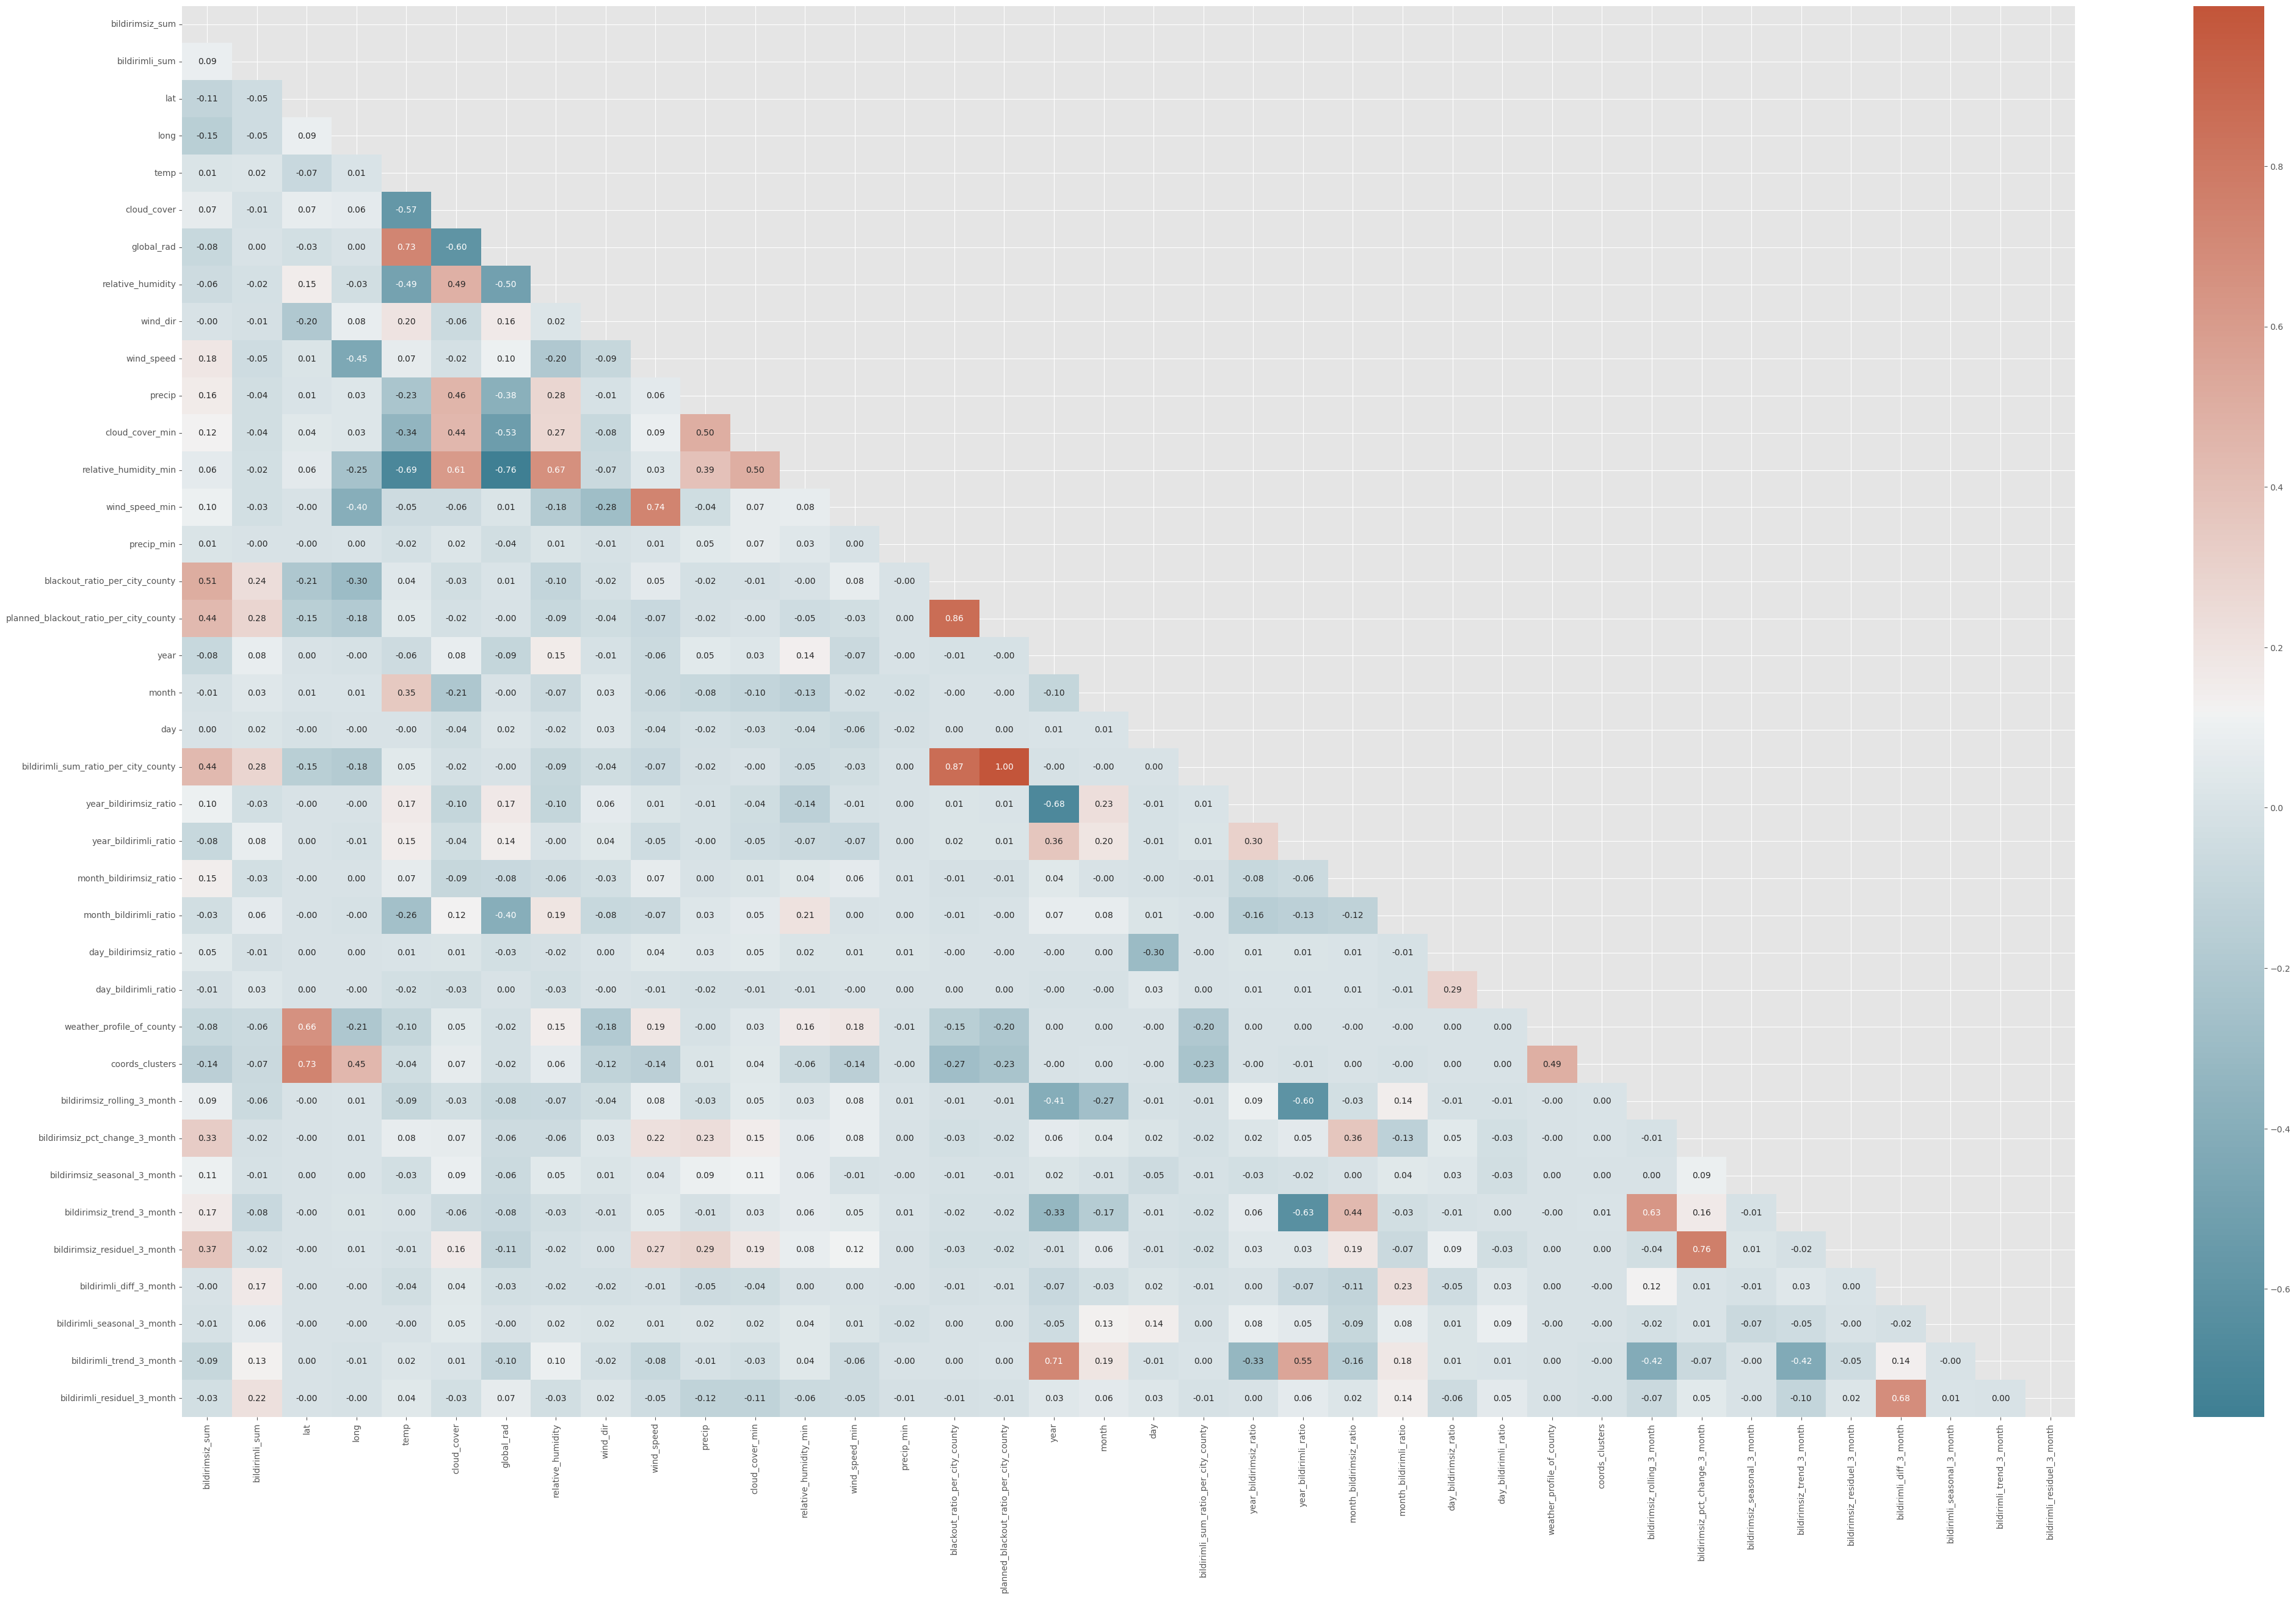

In [119]:
plt.figure(figsize=(50, 30))
num_variables = train_test_concat.select_dtypes(exclude=["object","category"])
corr_df = num_variables.corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
tri_df = corr_df.mask(mask)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(tri_df,annot=True,fmt=".2f",cmap = cmap)
plt.show()

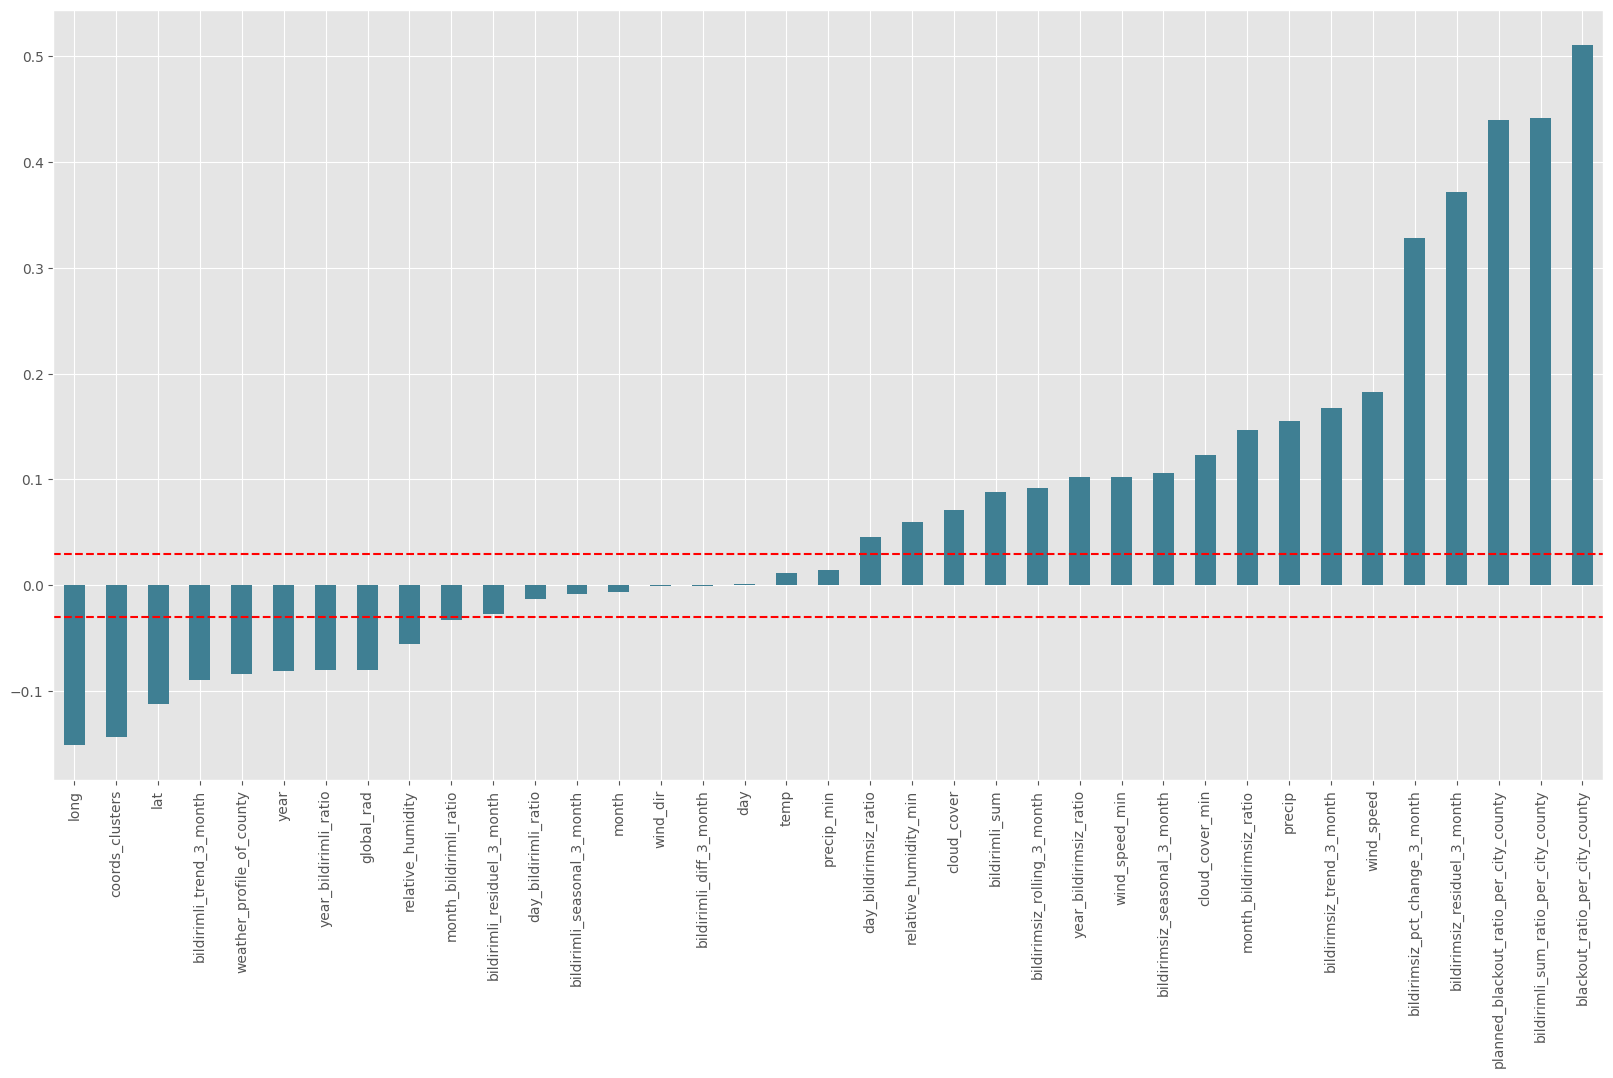

In [120]:
plt.figure(figsize=(20, 10))
tri_df["bildirimsiz_sum"].drop("bildirimsiz_sum").sort_values().plot(kind="bar")
plt.axhline(0.03, color ="red",linestyle ='--')
plt.axhline(-0.03, color='red',linestyle='--')
plt.show()

In [121]:
cor_target = abs(tri_df["bildirimsiz_sum"])
cor_target.drop("bildirimsiz_sum",inplace=True,axis=0)
correlated_features  = cor_target[cor_target >=0.03]
print("Toplam sayısal özellik sayısı:",len(train_test_concat.select_dtypes(exclude="object").columns))
print("Korelasyonlu özellik sayısı:",len(correlated_features))

Toplam sayısal özellik sayısı: 41
Korelasyonlu özellik sayısı: 28


**Veri Ön İşleme**
- Bayram flag one hot encoding işlemi

In [122]:
bayram_one_hot = pd.get_dummies(train_test_concat["flag"],drop_first=True).astype(int)
train_test_concat.drop("flag", axis=1,inplace=True)
train_test_concat=pd.concat([train_test_concat,bayram_one_hot], axis=1)
train_test_concat.head()

tarih         il_ilce  bildirimsiz_sum  bildirimli_sum  \
0  2021-01-01  manisa-akhisar              9.0               0   
1  2021-01-02  manisa-akhisar             10.0               0   
2  2021-01-03  manisa-akhisar              5.0               2   
3  2021-01-04  manisa-akhisar              6.0               0   
4  2021-01-05  manisa-akhisar             15.0               4   

                   unique_id      lat     long  temp  cloud_cover  global_rad  \
0  2021-01-01-manisa-akhisar  38.9177  27.8366  14.9         75.0       283.5   
1  2021-01-02-manisa-akhisar  38.9177  27.8366  17.1         49.6       437.6   
2  2021-01-03-manisa-akhisar  38.9177  27.8366  14.5         99.8       236.1   
3  2021-01-04-manisa-akhisar  38.9177  27.8366  17.5         95.5       442.3   
4  2021-01-05-manisa-akhisar  38.9177  27.8366  15.6        100.0       375.1   

   relative_humidity  wind_dir  wind_speed  precip  cloud_cover_min  \
0               94.3     133.6         2.1     1.0             30.5   
1               95.7     100.6         1.4     1.0              3.3   
2               95.0     122.5         1.7     1.0              1.3   
3               96.3      90.2         2.7    30.4              7.7   
4               90.2     160.1         3.1    53.9              8.0   

   relative_humidity_min  wind_speed_min  precip_min      il     ilce  \
0                   78.6             0.2         1.0  manisa  akhisar   
1                   52.7             0.4         1.0  manisa  akhisar   
2                   57.3             0.2         1.0  manisa  akhisar   
3                   41.9             0.5         1.0  manisa  akhisar   
4                   61.6             0.9         1.0  manisa  akhisar   

   blackout_ratio_per_city_county  planned_blackout_ratio_per_city_county  \
0                         0.03451                                0.041542   
1                         0.03451                                0.041542   
2                         0.03451                                0.041542   
3                         0.03451                                0.041542   
4                         0.03451                                0.041542   

   year  month  day  bildirimli_sum_ratio_per_city_county  \
0  2021      1    1                              0.041752   
1  2021      1    2                              0.041752   
2  2021      1    3                              0.041752   
3  2021      1    4                              0.041752   
4  2021      1    5                              0.041752   

   year_bildirimsiz_ratio  year_bildirimli_ratio  month_bildirimsiz_ratio  \
0                0.380895               0.257597                  0.08998   
1                0.380895               0.257597                  0.08998   
2                0.380895               0.257597                  0.08998   
3                0.380895               0.257597                  0.08998   
4                0.380895               0.257597                  0.08998   

   month_bildirimli_ratio  day_bildirimsiz_ratio  day_bildirimli_ratio  \
0                 0.09642               0.034594              0.028414   
1                 0.09642               0.036141              0.030416   
2                 0.09642               0.033241              0.031871   
3                 0.09642               0.032770              0.033015   
4                 0.09642               0.034441              0.032079   

  temp_category wind_speed_category precip_category  \
0          mild        hafif_rizgar        very_low   
1          warm              esinti        very_low   
2          mild        hafif_rizgar        very_low   
3          warm        hafif_rizgar       very_high   
4          warm        hafif_rizgar       very_high   

   weather_profile_of_county  coords_clusters  bildirimsiz_rolling_3_month  \
0                          2                2                   324.633333   
1                          2     

- İl İlçe alan büyüklüklerine göre label encoding işlemi

In [123]:
train_test_concat["il_ilce"].nunique()

47

In [124]:
data = {
    "ilce": ["izmir-aliaga", "izmir-balcova", "izmir-bayindir", "izmir-bayrakli", "izmir-bergama", "izmir-beydag", "izmir-bornova", "izmir-buca", "izmir-cesme", "izmir-cigli", "izmir-dikili", "izmir-foca", "izmir-gaziemir", "izmir-guzelbahce", "izmir-karabaglar", "izmir-karaburun", "izmir-karsiyaka", "izmir-kemalpasa", "izmir-kinik", "izmir-kiraz", "izmir-konak", "izmir-menderes", "izmir-menemen", "izmir-narlidere", "izmir-odemis", "izmir-seferihisar", "izmir-selcuk", "izmir-tire", "izmir-torbali", "izmir-urla", "manisa-ahmetli", "manisa-akhisar", "manisa-alasehir", "manisa-demirci", "manisa-golmarmara", "manisa-gordes", "manisa-kirkagac", "manisa-koprubasi", "manisa-kula", "manisa-salihli", "manisa-sarigol", "manisa-saruhanli", "manisa-selendi", "manisa-soma", "manisa-sehzadeler", "manisa-turgutlu", "manisa-yunusemre"],
    "alanı_km2": [379, 16, 548, 30, 1544, 172, 220, 178, 285, 139, 534, 251, 70, 77, 89, 421, 51, 681, 479, 573, 24, 777, 573, 50, 1019, 375, 317, 716, 577, 727, 227, 1645, 971, 1321, 310, 902, 541, 447, 981, 1359, 432, 771, 726, 820, 515, 549, 823]
}
il_ilce_df = pd.DataFrame(data).reset_index(drop=True).sort_values("alanı_km2")
il_ilce_df.head()

ilce  alanı_km2
1     izmir-balcova         16
20      izmir-konak         24
3    izmir-bayrakli         30
23  izmir-narlidere         50
16  izmir-karsiyaka         51

In [125]:
order_cols = il_ilce_df["ilce"].to_list()
train_test_concat["il_ilce_label_enc"] = pd.Categorical(train_test_concat["il_ilce"],categories=order_cols,ordered=True)
train_test_concat["il_ilce_label_enc"] = train_test_concat["il_ilce_label_enc"].cat.codes
train_test_concat["il_ilce_label_enc"].nunique()

47

**temp_category	wind_speed_category	precip_category kategorik değişkenler label encoding**

In [126]:
for cat in ["temp_category","wind_speed_category","precip_category"]:
    train_test_concat[cat] = train_test_concat[cat].cat.codes
    print(train_test_concat[cat].value_counts())
    print("*************************")

temp_category
4    19997
3    17860
2     6987
1     2856
0      560
Name: count, dtype: int64
*************************
wind_speed_category
3    20281
2    13666
4    10372
5     2391
1     1086
6      409
7       53
8        2
Name: count, dtype: int64
*************************
precip_category
0    34865
4     8845
3     1853
2     1502
1     1195
Name: count, dtype: int64
*************************


**Korelasyon Kontrol**

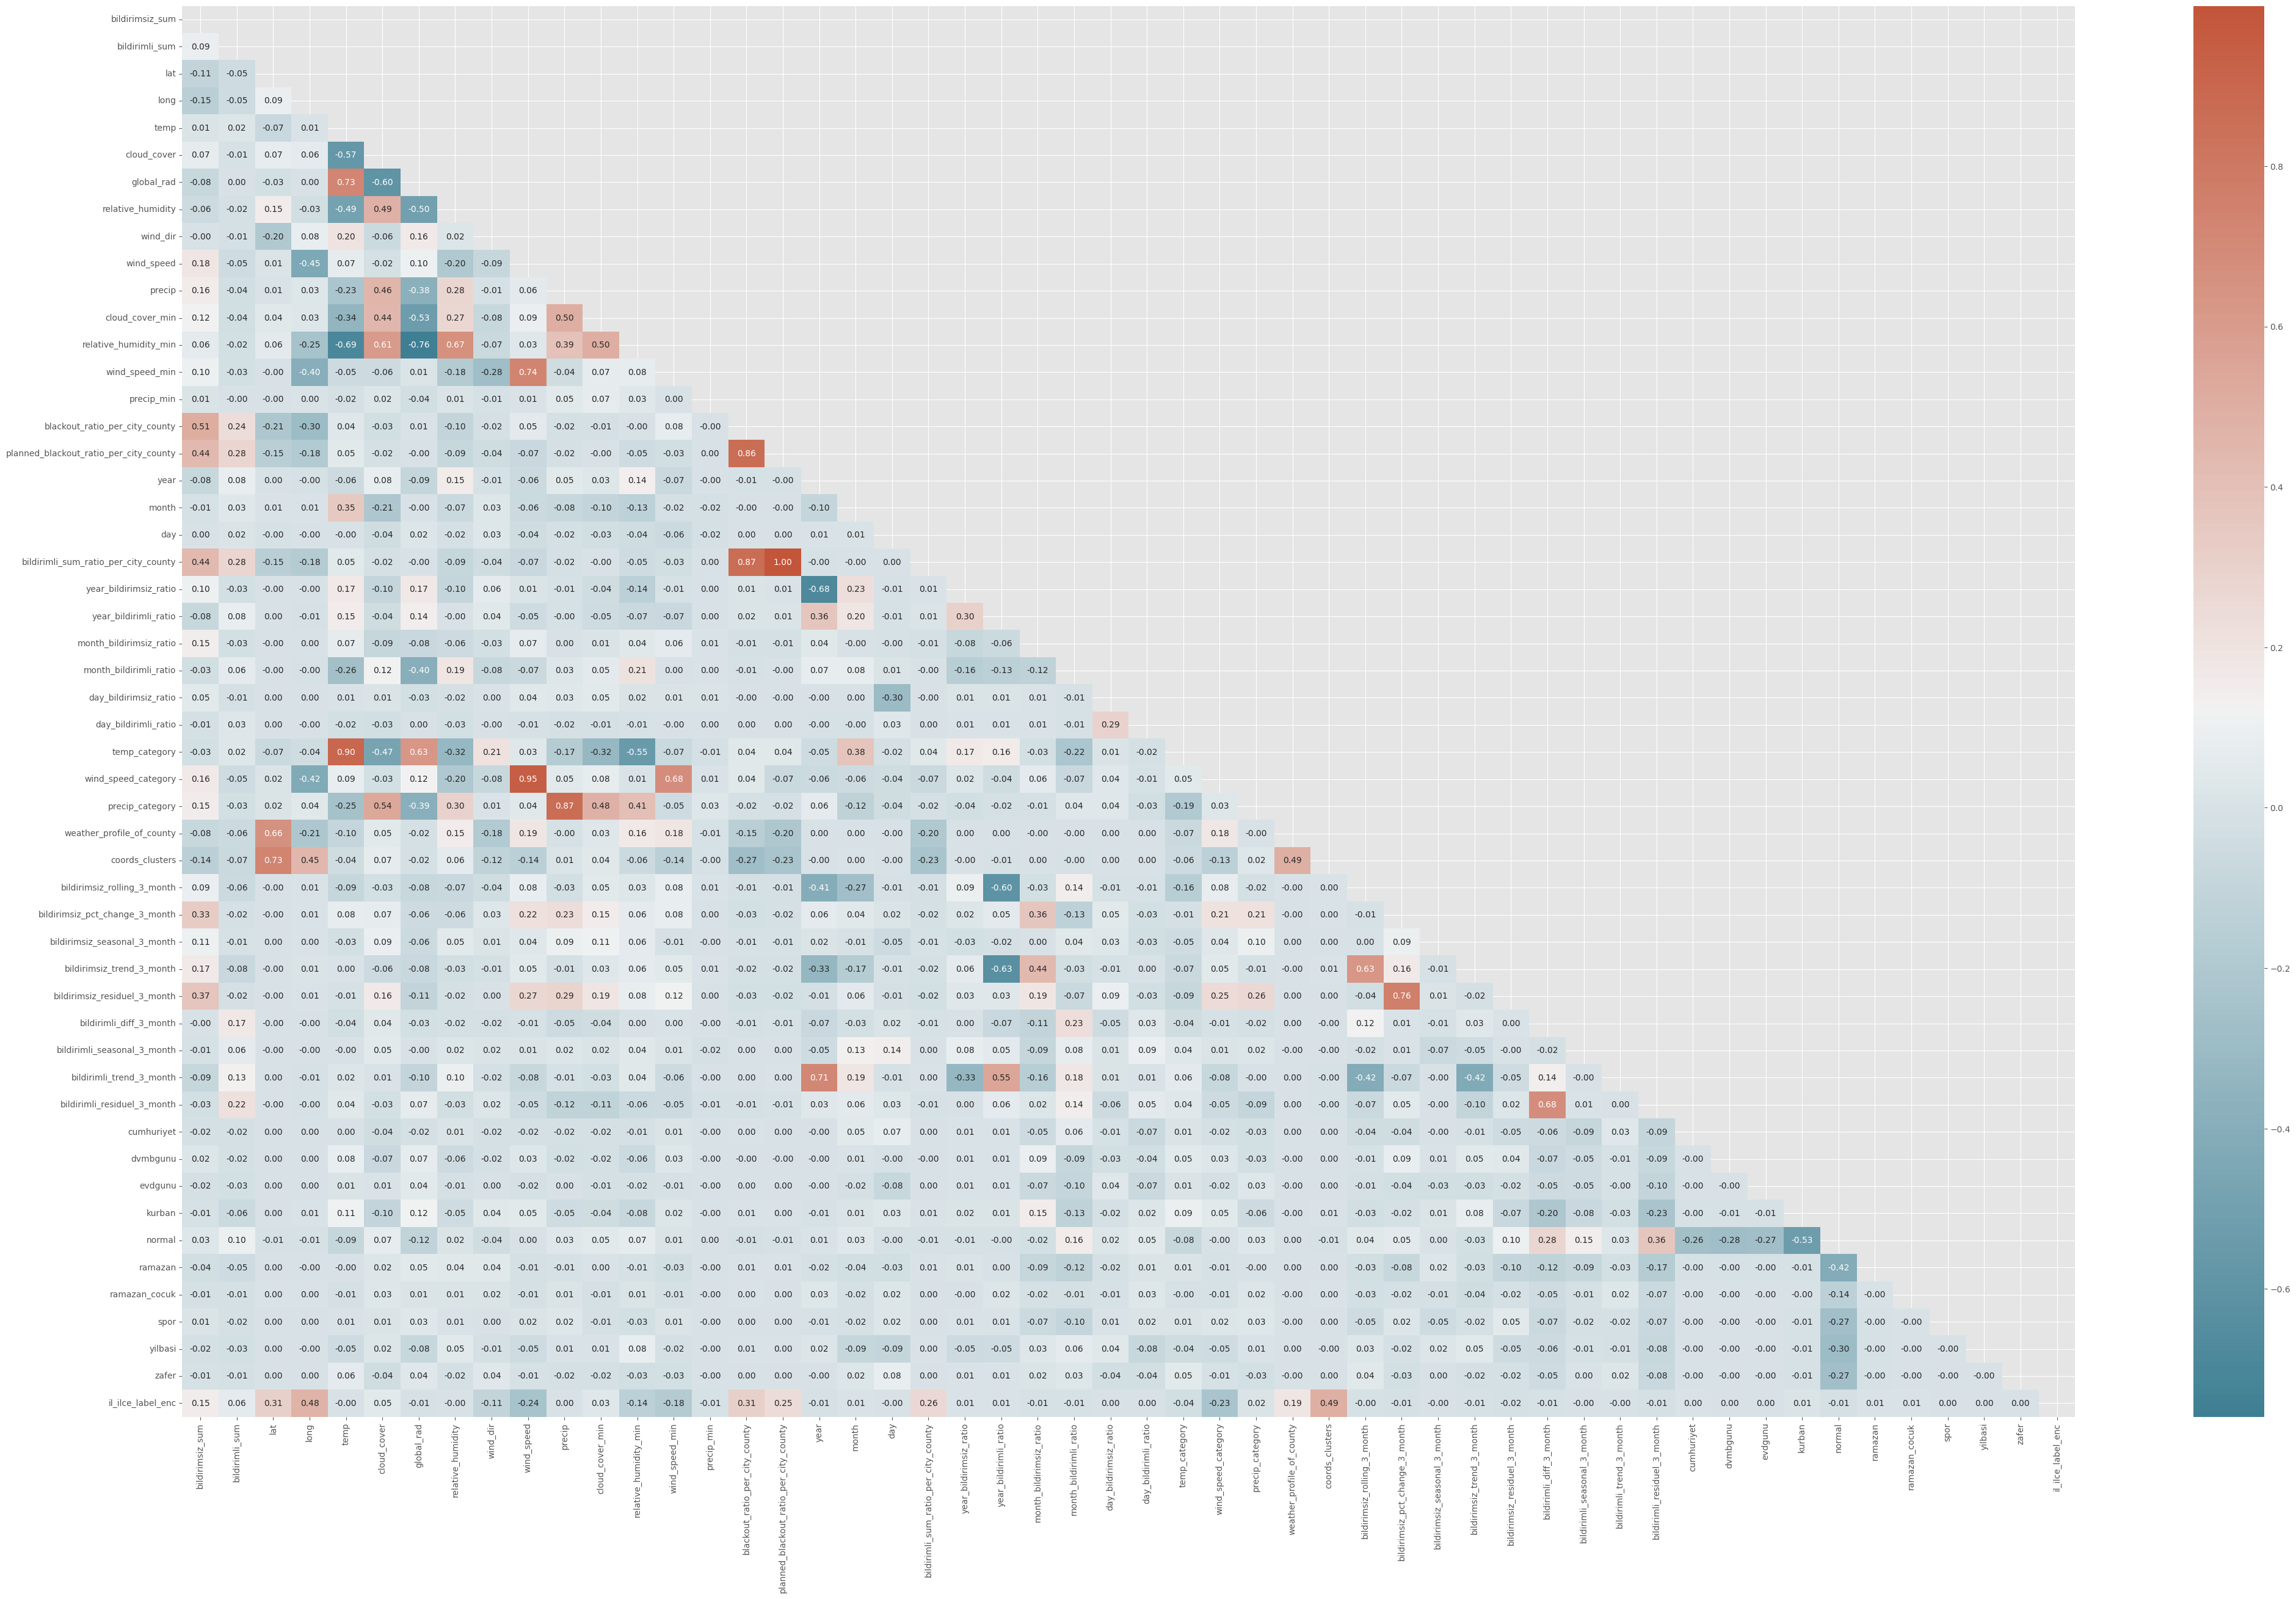

In [128]:
plt.figure(figsize=(50, 30))
num_variables = train_test_concat.select_dtypes(exclude=["object","category"])
corr_df = num_variables.corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
tri_df = corr_df.mask(mask)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(tri_df,annot=True,fmt=".2f",cmap = cmap)
plt.show()

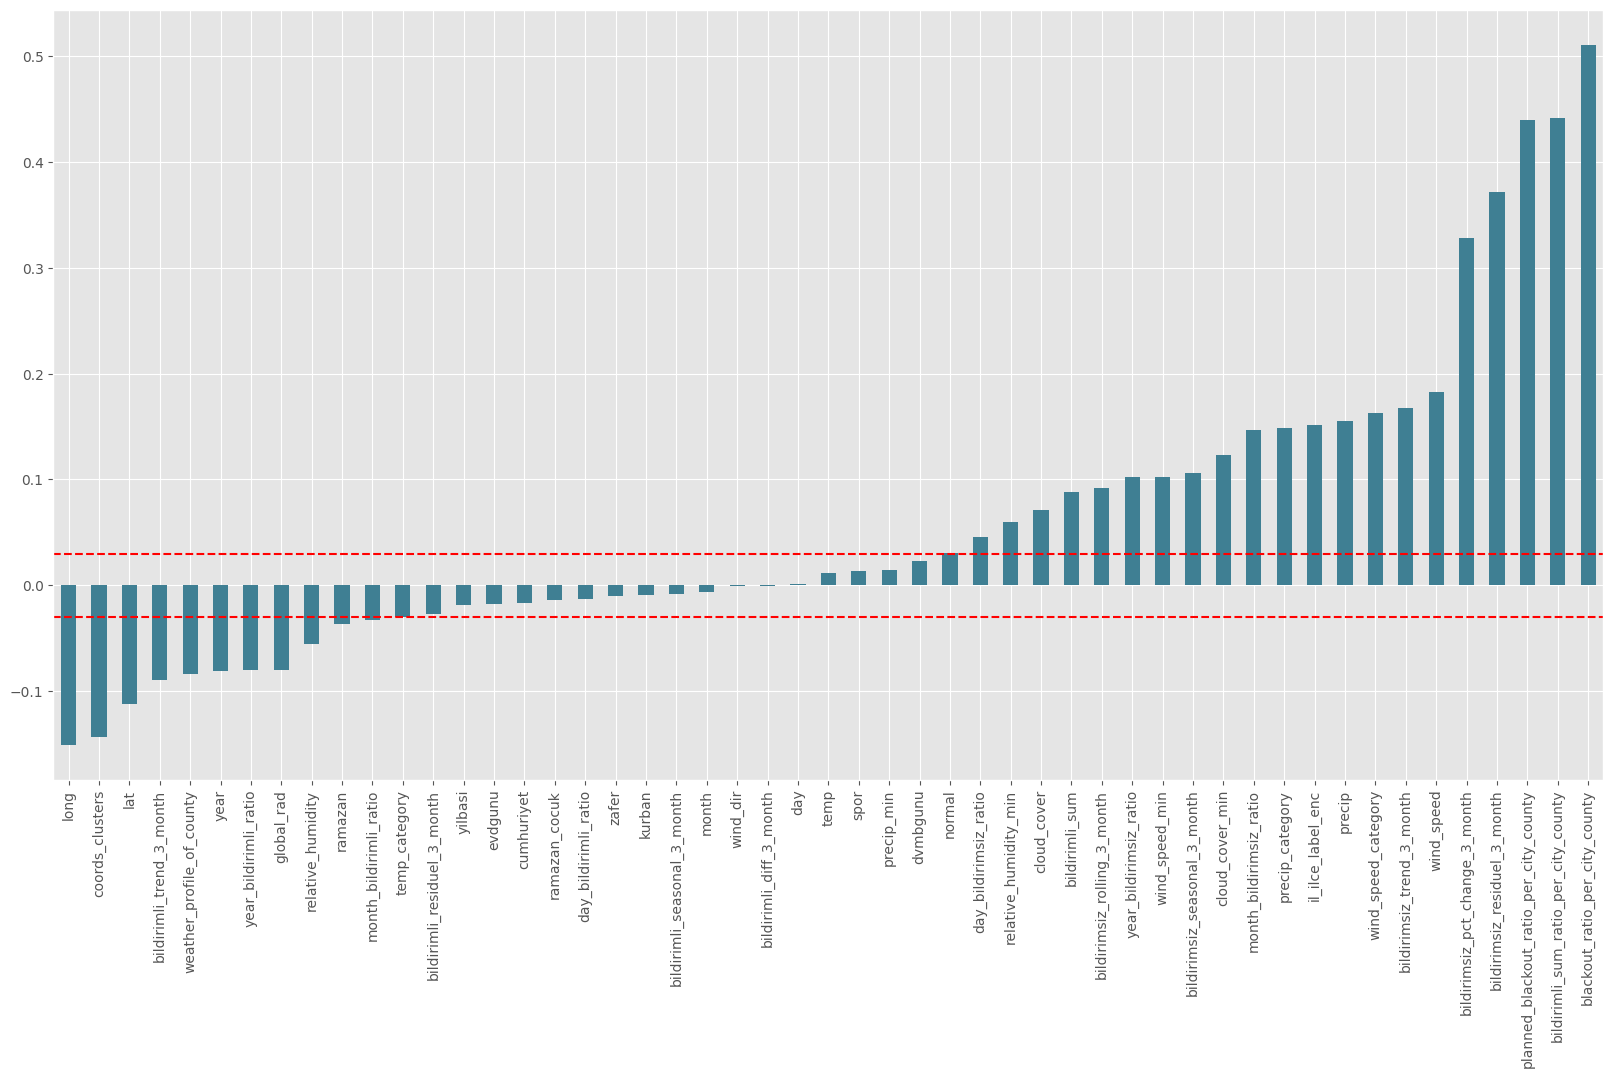

In [129]:
plt.figure(figsize=(20, 10))
tri_df["bildirimsiz_sum"].drop("bildirimsiz_sum").sort_values().plot(kind="bar")
plt.axhline(0.03, color ="red",linestyle ='--')
plt.axhline(-0.03, color='red',linestyle='--')
plt.show()

In [130]:
cor_target = abs(tri_df["bildirimsiz_sum"])
cor_target.drop("bildirimsiz_sum",inplace=True,axis=0)
correlated_features  = cor_target[cor_target >=0.03]
print("Toplam sayısal özellik sayısı:",len(train_test_concat.select_dtypes(exclude="object").columns))
print("Korelasyonlu özellik sayısı:",len(correlated_features))

Toplam sayısal özellik sayısı: 52
Korelasyonlu özellik sayısı: 33


**Model Oluşturma ve Değerlendirme**

**Model eğitim ve değerlendirme için kullanılacak fonksiyonun tanımlanması**
- Tüm model eğitimi ve değerlendirme süreci, işleri kolay ve hatasız hale getirmek, zaman kazanmak, denemeler yapmak için fonksiyona dönüştürülmüştür. Bu fonksiyon, modeli, bölünmüş verileri, çapraz doğrulama stratejisini, model değerlendirmede kullanılacak metriği  parametre olarak alır ve eğitilmiş modeli, eğitim ve doğrulama skorlarını içeren dataframe'i, son test skorunu ve test seti üzerindeki tahminleri döndürür. Plot parametresi aynı zamanda True olarak belirtilirse eğitim ve doğrulama sonuçlarını çizer. Eğitim verilerine çapraz doğrulama uygulamak, model değerlendirme aşamasında sıklıkla tercih edilen bir yöntemdir. Bu sayede modelin eğitim, doğrulama ve test seti üzerindeki sonuçlarını karşılaştırarak aşırı uyum ve yetersiz uyum durumlarını daha kolay gözlemleyebilir ve hiperparametreleri bu sonuçlara göre ayarlayabiliriz.

In [131]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, score_func, cv_type, plot=True, use_rmse=False):
    """
    This function uses cross-validation to evaluate the performance of a model.
    It allows comparison by calculating training score, validation score, and test score separately.
    First, it performs cross-validation, then trains the model with the entire training set from scratch to calculate the test score.
    This enables a better evaluation of model performance and detection of issues such as overfitting or underfitting.

    Parameters:
    model: the model to be trained.
    X_train: pandas.DataFrame, the split training dataset.
    y_train: pandas.Series, the target variable of the training dataset.
    X_test: pandas.DataFrame, the split test dataset.
    y_test: pandas.Series, the target variable of the test dataset.
    score_func: function, evaluation metric. For example, mean_squared_error, mean_absolute_error, etc.
    cv_type: cross-validation strategy. For example, KFold, StratifiedKFold, etc.
    plot: bool, optional (default=True) If True, plots the training and validation scores.
    use_rmse: bool, optional (default=False) If the metric function is mean_squared_error, set to True to calculate Root Mean Squared Error.

    Returns:
    model: trained model.
    final_test_score: float, metric score obtained on the test set.
    scores_df: pandas.DataFrame, dataframe containing calculated training and validation scores.
    y_pred_test: pandas.Series, predictions on the test set.
    """

    
    # score list initialization.
    train_scores = []
    validation_scores = []
    score_per_fold = []
    fold = 1

    # cross validation stage for overfitting , underfitting detection
    for train_index, test_index in cv_type.split(X_train, y_train):
        X_train_cv, X_validation_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_validation_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        # model fitting on train set
        model.fit(X_train_cv, y_train_cv)
        y_pred_train = model.predict(X_train_cv)
        y_pred_validation = model.predict(X_validation_cv)
        
        # evaluation of train score
        train_score = score_func(np.expm1(y_train_cv), np.expm1(y_pred_train))
        # evaluation of validation score
        validation_score = score_func(np.expm1(y_validation_cv), np.expm1(y_pred_validation))

       
       #if mean_squared_error score func use_rmse=True 
        if use_rmse and score_func.__name__ == "mean_squared_error":
            train_score = np.sqrt(train_score)
            validation_score = np.sqrt(validation_score)
            score_name = "root_mean_squared_error"
        else:
            train_score = train_score
            validation_score = validation_score
            score_name = score_func.__name__
        

   
        train_scores.append(train_score)
        validation_scores.append(validation_score)

        # scores per fold
        print(f"{fold}. Fold train_{score_name}: {train_score:.2f}")
        print(f"{fold}. Fold validasyon_{score_name}: {validation_score:.2f}")

        fold += 1
  
        score_per_fold.append(fold)

    print("Cross validation stage has been complated! Model is started to training...")

    # Çapraz doğrulama aşaması tamamlandıktan sonra. Model tüm eğitim seti ile tekrar eğitilir.
    model.fit(X_train, y_train)
    print("*******************************************")
    print("Model training has been complated!")
    print("*******************************************")

    # test seti üzerinden tahmin yapılması.
    y_pred_test = model.predict(X_test)
    
    # use_rmse=True calculate RMSE 
    if use_rmse and score_func.__name__ == "mean_squared_error":
        final_test_score = np.sqrt(score_func(np.expm1(y_test) , np.expm1(y_pred_test)))
        score_name = "root_mean_squared_error"
    else:
        final_test_score = score_func(np.expm1(y_test) , np.expm1(y_pred_test))
        score_name = score_func.__name__

    # saves scores in dictionary.
    scores_dict = {
    "fold": range(1, len(score_per_fold) + 1),
    f"train_{score_name}": train_scores,
    f"validation_{score_name}": validation_scores
    }

    # df for plotting
    scores_df = pd.DataFrame(scores_dict)

    
    # diff % of validation score according to training score 
    percentage_difference_train_valid = ((np.mean(validation_scores) - np.mean(train_scores)) / np.mean(train_scores)) * 100

    # diff % of final score according to training score 
    percentage_difference_train_test = ((final_test_score - np.mean(train_scores)) / np.mean(train_scores)) * 100

  
    print(f"Average train_{score_name} result: {np.mean(train_scores):.2f}")
    print(f"Average validation_{score_name} sonucu: {np.mean(validation_scores):.2f}")
    print(f"Test_{score_name} result: {final_test_score:.2f}")
    print(f'Validation percentage according to train:%{percentage_difference_train_valid:.2f}')
    print(f'Final test percentage according to train:%{percentage_difference_train_test:.2f}')
    print("*******************************************")


    if plot:
        sns.lineplot(data=scores_df, x="fold", y=f"train_{score_name}", marker="o", label=f"train_{score_name}")
        sns.lineplot(data=scores_df, x="fold", y=f"validation_{score_name}", marker="v", label=f"validation_{score_name}")
        plt.xlabel("Katman")
        plt.ylabel(f"{score_name}")
        plt.title(f"Each fold {score_name} score")
        plt.legend()
        plt.show()

    return  model, final_test_score, scores_df, np.expm1(y_pred_test)

**Verilerin Ayrılması**

In [133]:
new_train = train_test_concat[train_test_concat["unique_id"].isin(train["unique_id"])]
new_train["bildirimsiz_sum"] = new_train["bildirimsiz_sum"].astype(int)
new_test = train_test_concat[train_test_concat["unique_id"].isin(test["unique_id"])]

In [134]:
new_train.shape

(46944, 57)

In [135]:
new_test.shape

(1316, 57)

**Verilerin Eğitim ve Test Olarak ayrılması**
- Model aşamasında metriklerimizi hesaplamak için veri setini eğitim ve test diye bölmek yaygın bir uygulamadır. Burada verinin %20'si test seti için ayrılmıştır.

**Final Log1p Target Transformation**

In [136]:
target = "bildirimsiz_sum"
new_train[target] = np.log1p(new_train[target])

In [183]:
columns_that_will_not_used = [target,"tarih","il_ilce","il","ilce","unique_id","day","bildirimli_sum","blackout_ratio_per_city_county",
                              "planned_blackout_ratio_per_city_county","cloud_cover_min","relative_humidity_min","wind_speed_min","precip_min",
                              "month_bildirimli_ratio","year_bildirimli_ratio","day_bildirimsiz_ratio","day_bildirimli_ratio","temp_category",
                              "wind_speed_category","precip_category","weather_profile_of_county","coords_clusters",
                              "bildirimsiz_rolling_3_month","bildirimsiz_pct_change_3_month","bildirimsiz_seasonal_3_month","bildirimsiz_trend_3_month",
                              "bildirimsiz_residuel_3_month","bildirimli_diff_3_month","bildirimli_seasonal_3_month","bildirimli_trend_3_month","bildirimli_residuel_3_month","bildirimsiz_rolling_3_month"] 
feature_columns = [col for col in new_train.columns if col not in columns_that_will_not_used]
X = new_train[feature_columns]
y= new_train[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [184]:
X.columns

Index(['lat', 'long', 'temp', 'cloud_cover', 'global_rad', 'relative_humidity',
       'wind_dir', 'wind_speed', 'precip', 'year', 'month',
       'bildirimli_sum_ratio_per_city_county', 'year_bildirimsiz_ratio',
       'month_bildirimsiz_ratio', 'cumhuriyet', 'dvmbgunu', 'evdgunu',
       'kurban', 'normal', 'ramazan', 'ramazan_cocuk', 'spor', 'yilbasi',
       'zafer', 'il_ilce_label_enc'],
      dtype='object')

In [185]:
X_train.shape

(37555, 25)

In [186]:
X_test.shape

(9389, 25)

In [187]:
len(X_train.columns)

25

In [188]:
y_train.shape

(37555,)

In [189]:
y_test.shape

(9389,)

**Linear Regression Modeli**
- Modelin daha iyi performans göstermesi için yüksek derecede sağa çarpık verilerin ölçeklendirilmesi gerekebilir. Bunun için pipeline içerisinde RobustScaler kullanılmıştır. 
- RobustScaler, aykırı değerlerin etkisini azaltmak için medyan ve yüzdelik aralıkları kullanarak çalışır. Çarpık değişkenlerin olduğu veri setlerinde iyi performans gösterebilir.

1. Fold train_mean_absolute_error: 2.83
1. Fold validasyon_mean_absolute_error: 2.87
2. Fold train_mean_absolute_error: 2.84
2. Fold validasyon_mean_absolute_error: 2.84
3. Fold train_mean_absolute_error: 2.84
3. Fold validasyon_mean_absolute_error: 2.81
4. Fold train_mean_absolute_error: 2.83
4. Fold validasyon_mean_absolute_error: 2.94
5. Fold train_mean_absolute_error: 2.84
5. Fold validasyon_mean_absolute_error: 2.78
6. Fold train_mean_absolute_error: 2.84
6. Fold validasyon_mean_absolute_error: 2.79
7. Fold train_mean_absolute_error: 2.84
7. Fold validasyon_mean_absolute_error: 2.78
8. Fold train_mean_absolute_error: 2.83
8. Fold validasyon_mean_absolute_error: 2.87
9. Fold train_mean_absolute_error: 2.84
9. Fold validasyon_mean_absolute_error: 2.83
10. Fold train_mean_absolute_error: 2.83
10. Fold validasyon_mean_absolute_error: 2.89
Cross validation stage has been complated! Model is started to training...
*******************************************
Model training has been compl

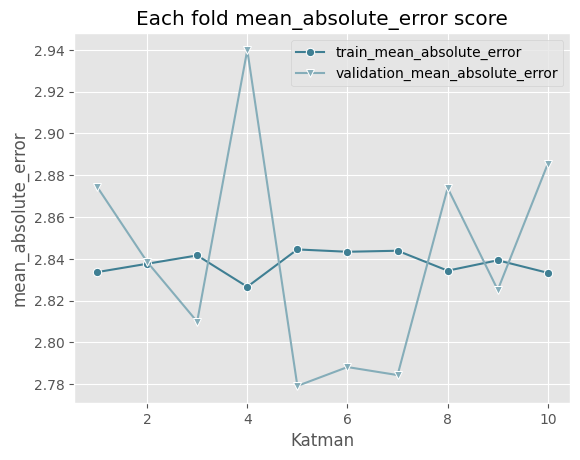

In [190]:
lr = LinearRegression()

lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", lr)
])

kf = KFold(n_splits=10,shuffle=True,random_state=42)
lr_model, lr_final_test_mae_score, lr_mae_scores_df,lr_y_pred_test = train_and_evaluate_model(lr_pipeline, X_train, y_train, X_test, y_test, mean_absolute_error, kf, plot=True, use_rmse=False)

1. Fold train_r2_score: 0.29
1. Fold validasyon_r2_score: 0.27
2. Fold train_r2_score: 0.29
2. Fold validasyon_r2_score: 0.30
3. Fold train_r2_score: 0.29
3. Fold validasyon_r2_score: 0.30
4. Fold train_r2_score: 0.29
4. Fold validasyon_r2_score: 0.28
5. Fold train_r2_score: 0.29
5. Fold validasyon_r2_score: 0.27
6. Fold train_r2_score: 0.29
6. Fold validasyon_r2_score: 0.32
7. Fold train_r2_score: 0.29
7. Fold validasyon_r2_score: 0.31
8. Fold train_r2_score: 0.29
8. Fold validasyon_r2_score: 0.26
9. Fold train_r2_score: 0.29
9. Fold validasyon_r2_score: 0.32
10. Fold train_r2_score: 0.29
10. Fold validasyon_r2_score: 0.28
Cross validation stage has been complated! Model is started to training...
*******************************************
Model training has been complated!
*******************************************
Average train_r2_score result: 0.29
Average validation_r2_score sonucu: 0.29
Test_r2_score result: 0.29
Validation percentage according to train:%-0.15
Final test percent

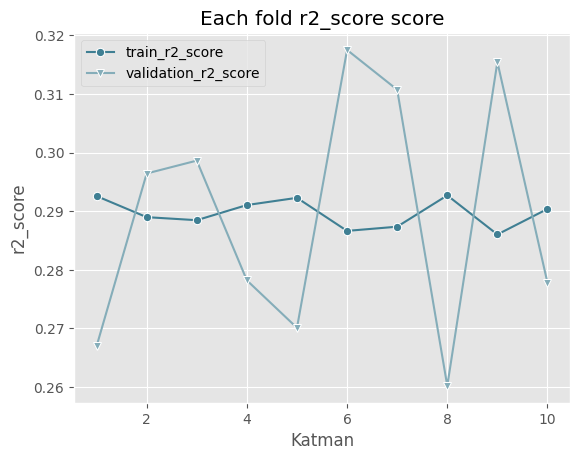

In [191]:
lr = LinearRegression()

lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", lr)
])

kf = KFold(n_splits=10,shuffle=True,random_state=42)
_ , lr_final_test_r2_score, lr_r2_scores_df,lr_y_pred_test = train_and_evaluate_model(lr_pipeline, X_train, y_train, X_test, y_test, r2_score, kf, plot=True, use_rmse=False)

**Linear Regression Özellik Seçimi**


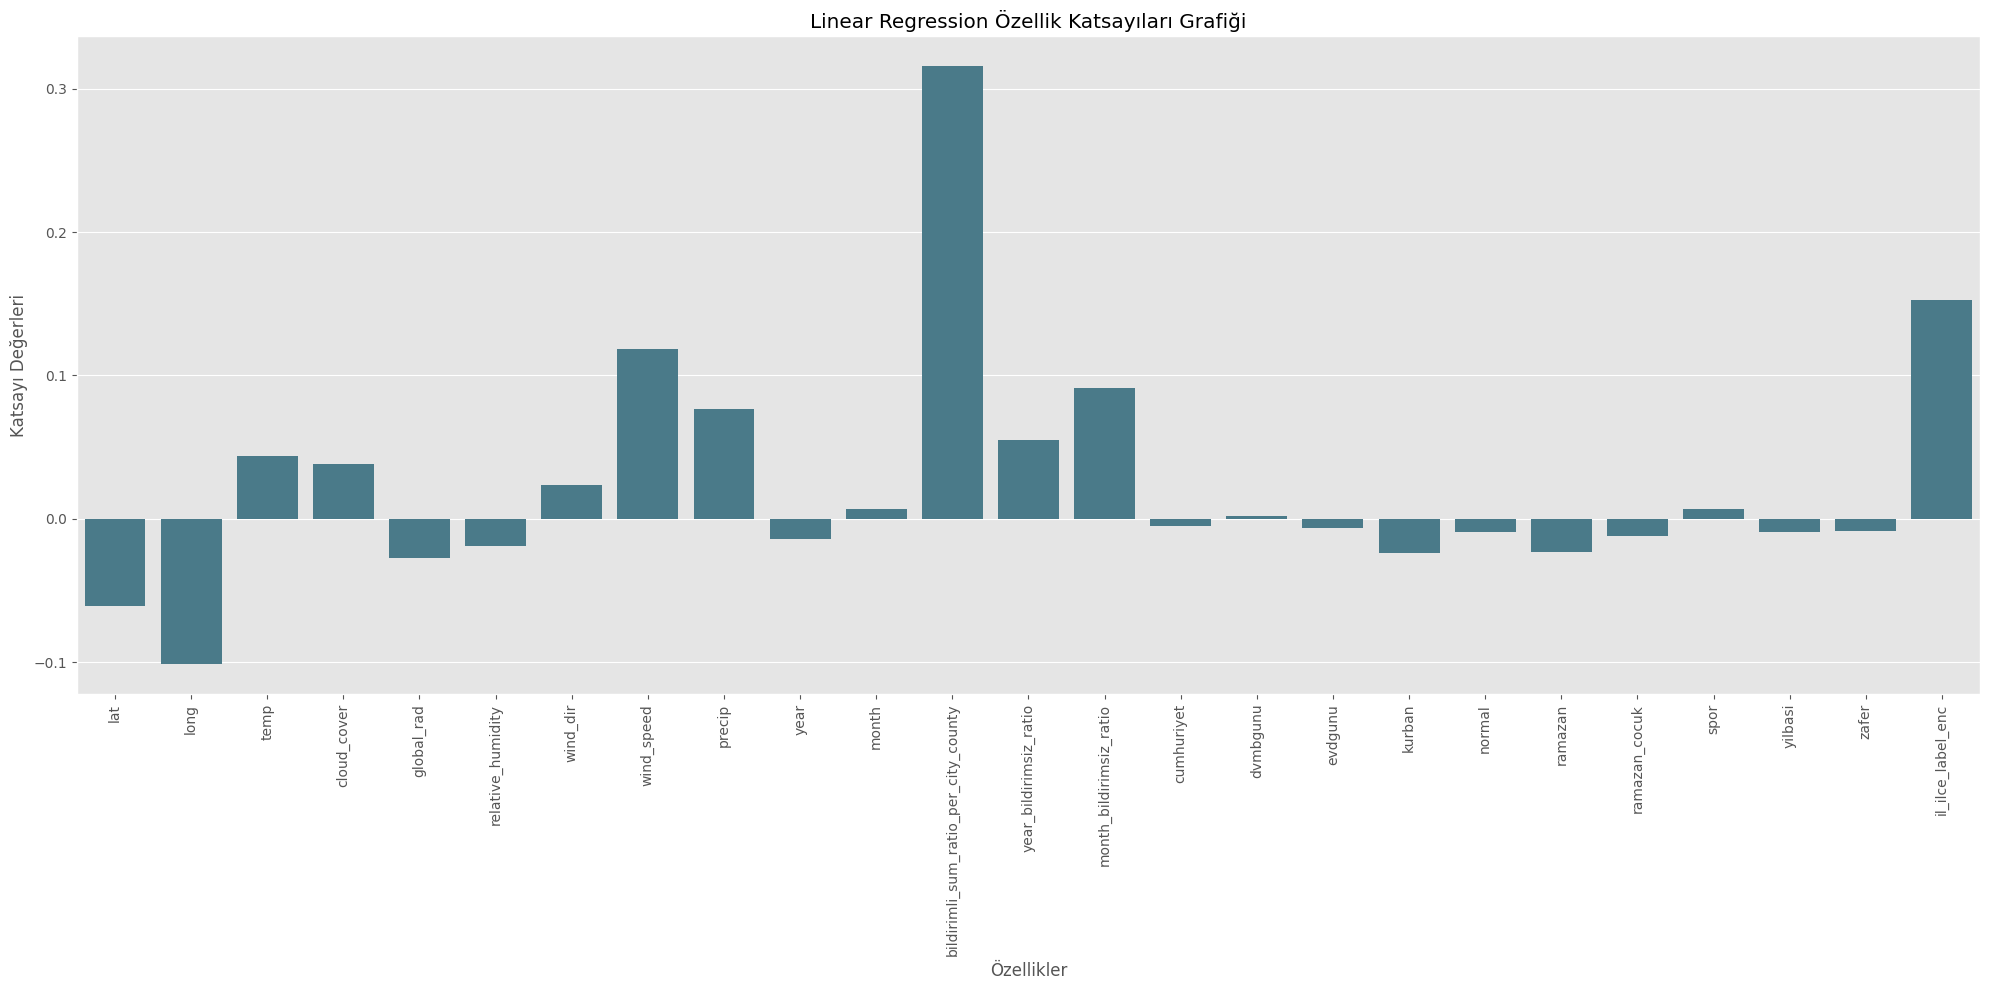

In [192]:
coef_values = lr_model.named_steps["regressor"].coef_
columns = X_train.columns
plt.figure(figsize=(20,10))
sns.barplot(x=columns, y=coef_values)
plt.xlabel("Özellikler")
plt.ylabel("Katsayı Değerleri")
plt.title("Linear Regression Özellik Katsayıları Grafiği")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**XgBoostRegressor Modeli**
- Model ağaç tabanlı olduğundan karmaşık ve çarpık verilerde iyi performans gösterir bu nedenle ölçekleme uygulanmamıştır.

**Hiperparametre Optimizasyonu**
- Bayesyen hiperparametre ayarlama, makine öğrenimi modellerindeki hiperparametreleri optimize etmek için bayesyen istatistiklerini kullanır. 
Bu yöntem, en iyi hiperparametre değerlerini tahmin etmek için bir olasılık dağılımını günceller ve modelin performansını artırmayı amaçlar.

In [134]:
# space = {
#     'learning_rate': hp.loguniform('learning_rate', -5, 0),  
#     'n_estimators': hp.quniform('n_estimators', 95, 500, 1),
#     'max_depth': hp.choice('max_depth', range(3, 15)),  
#     'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1), 
#     'subsample': hp.uniform('subsample', 0.2, 1), 
#     'gamma': hp.uniform('gamma', 0, 1), 
#     'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1), 
#     'reg_alpha': hp.quniform('reg_alpha', 0, 80, 1), 
#     'reg_lambda': hp.uniform('reg_lambda', 0, 1),
#     'scale_pos_weight': hp.quniform('scale_pos_weight', 1, 10, 1), 
#     'booster': hp.choice('booster', ['gbtree']), 
#     'seed': 0
# }
# def objective(params,X,y):
#     xg_reg = XGBRegressor(
#         colsample_bytree=params['colsample_bytree'],
#         gamma=params['gamma'],
#         n_estimators=int(params['n_estimators']),
#         max_depth=int(params['max_depth']),
#         learning_rate=params['learning_rate'],
#         subsample=params['subsample'],
#         min_child_weight=int(params['min_child_weight']),
#         reg_alpha=int(params['reg_alpha']),
#         reg_lambda=params['reg_lambda'],
#         seed=params['seed'],
#     )
    
#     kf = KFold(n_splits=10,shuffle=True,random_state=42)
#     mae_scores = []

#     for train_index, test_index in kf.split(X):
#         X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#         y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#         xg_reg.fit(X_train, y_train)
#         predictions = xg_reg.predict(X_test)

#         mae_score = mean_absolute_error(np.expm1(y_test), np.expm1(predictions))
#         mae_scores.append(mae_score)


#     average_mae = sum(mae_scores) / len(mae_scores)
#     return average_mae


# trials = Trials()
# best = fmin(fn=lambda params:objective(params,X=X,y=y), space=space, algo=tpe.suggest, max_evals=100, trials=trials)

# print("Best Hyperparameters:", best)
# print("Best score (MAE):", trials.best_trial['result']['loss'])

In [193]:
#bayesian_xgb_params = {'booster': 'gbtree', 'colsample_bytree': 0.9059713199918993, 'gamma': 0.7654256130970506, 'learning_rate': 0.05680557986964648, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 110, 'reg_alpha': 25, 'reg_lambda': 0.06579951812119596, 'scale_pos_weight': 7, 'subsample': 0.7735762314600151}
bayesian_xgb_params = {'booster': 'gbtree', 'colsample_bytree': 0.9092940475616561, 'gamma': 0.8100115391981325, 'learning_rate': 0.0722209725309728, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 120, 'reg_alpha': 25, 'reg_lambda': 0.5722436973737604, 'scale_pos_weight': 7, 'subsample': 0.8884445883672576}#sub3
# 136 denenecek

In [194]:
xgb = XGBRegressor(**bayesian_xgb_params,n_jobs=-1)
xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.9092940475616561,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0.8100115391981325,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.0722209725309728,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': 7,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 120,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': 25,
 'reg_lambda': 0.5722436973737604,
 'sampling_method': None,
 'scale_pos_weight': 7,
 'subsample': 0.8884445883672576,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [137]:
# n_trees = range(115, 150)
# train_maes = []
# validation_maes = []
# test_maes = []

# for n_tree in n_trees:
#     kf_ = KFold(n_splits=10,shuffle=True,random_state=42)
#     control_params = {'booster': 'gbtree', 'colsample_bytree': 0.9092940475616561, 'gamma': 0.8100115391981325, 'learning_rate': 0.0722209725309728, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': n_tree, 'reg_alpha': 25, 'reg_lambda': 0.5722436973737604, 'scale_pos_weight': 7, 'subsample': 0.8884445883672576}#sub3
#     xg_reg_control = XGBRegressor(**control_params,n_jobs=-1)
    
#     xgb_model, xgb_final_test_mae_score, xgb_mae_scores_df,xgb_y_pred_test = train_and_evaluate_model(xg_reg_control, X_train, y_train, X_test, y_test, mean_absolute_error, kf_, plot=False, use_rmse=False)
    
#     # Her ağaç sayısı için eğitim, doğrulama ve test MAE değerlerini kaydetme
#     train_maes.append(np.mean(xgb_mae_scores_df["train_mean_absolute_error"]))
#     validation_maes.append(np.mean(xgb_mae_scores_df["validation_mean_absolute_error"]))
#     test_maes.append(xgb_final_test_mae_score)
#     print(f'Tree number: {n_tree}')
#     print("*******************************************")

# # Eğitim, doğrulama ve test MAE farklarını hesaplama
# train_diffs = np.array(train_maes) - np.array(validation_maes)
# test_diffs = np.array(train_maes) - np.array(test_maes)

In [138]:
# # Tek grafik oluşturma
# plt.plot(n_trees, test_diffs, marker='o', c="blue", label='Train - Test')
# #plt.plot(n_trees, train_diffs, marker='x', c="red", label='Train - Validation')
# plt.xlabel('Number of Trees')
# plt.ylabel('MAE Difference (Train - Validation)')
# plt.title('MAE Differences for Train-Validation and Train-Test Sets')
# plt.legend()
# plt.grid(True)
# plt.show()

1. Fold train_mean_absolute_error: 2.52
1. Fold validasyon_mean_absolute_error: 2.58
2. Fold train_mean_absolute_error: 2.52
2. Fold validasyon_mean_absolute_error: 2.54
3. Fold train_mean_absolute_error: 2.52
3. Fold validasyon_mean_absolute_error: 2.56
4. Fold train_mean_absolute_error: 2.52
4. Fold validasyon_mean_absolute_error: 2.63
5. Fold train_mean_absolute_error: 2.52
5. Fold validasyon_mean_absolute_error: 2.51
6. Fold train_mean_absolute_error: 2.53
6. Fold validasyon_mean_absolute_error: 2.52
7. Fold train_mean_absolute_error: 2.52
7. Fold validasyon_mean_absolute_error: 2.56
8. Fold train_mean_absolute_error: 2.52
8. Fold validasyon_mean_absolute_error: 2.61
9. Fold train_mean_absolute_error: 2.52
9. Fold validasyon_mean_absolute_error: 2.57
10. Fold train_mean_absolute_error: 2.52
10. Fold validasyon_mean_absolute_error: 2.60
Cross validation stage has been complated! Model is started to training...
*******************************************
Model training has been compl

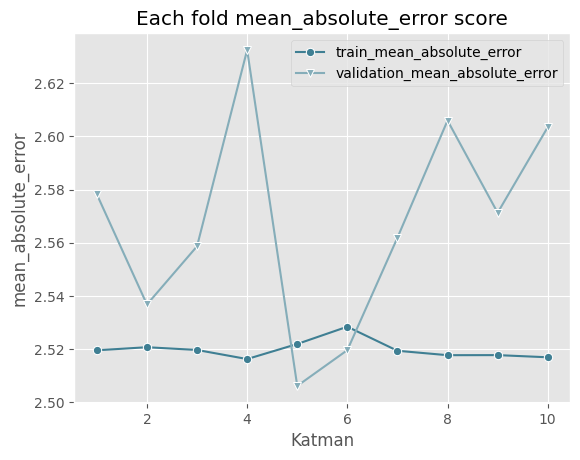

In [195]:
# Metrik MAE
kf = KFold(n_splits=10,shuffle=True,random_state=42)
xgb_model, xgb_final_test_mae_score, xgb_mae_scores_df,xgb_y_pred_test = train_and_evaluate_model(xgb, X_train, y_train, X_test, y_test, mean_absolute_error, kf, plot=True, use_rmse=False)

1. Fold train_r2_score: 0.43
1. Fold validasyon_r2_score: 0.40
2. Fold train_r2_score: 0.43
2. Fold validasyon_r2_score: 0.42
3. Fold train_r2_score: 0.43
3. Fold validasyon_r2_score: 0.42
4. Fold train_r2_score: 0.43
4. Fold validasyon_r2_score: 0.41
5. Fold train_r2_score: 0.44
5. Fold validasyon_r2_score: 0.40
6. Fold train_r2_score: 0.43
6. Fold validasyon_r2_score: 0.44
7. Fold train_r2_score: 0.43
7. Fold validasyon_r2_score: 0.42
8. Fold train_r2_score: 0.43
8. Fold validasyon_r2_score: 0.38
9. Fold train_r2_score: 0.43
9. Fold validasyon_r2_score: 0.44
10. Fold train_r2_score: 0.43
10. Fold validasyon_r2_score: 0.39
Cross validation stage has been complated! Model is started to training...
*******************************************
Model training has been complated!
*******************************************
Average train_r2_score result: 0.43
Average validation_r2_score sonucu: 0.41
Test_r2_score result: 0.43
Validation percentage according to train:%-4.54
Final test percent

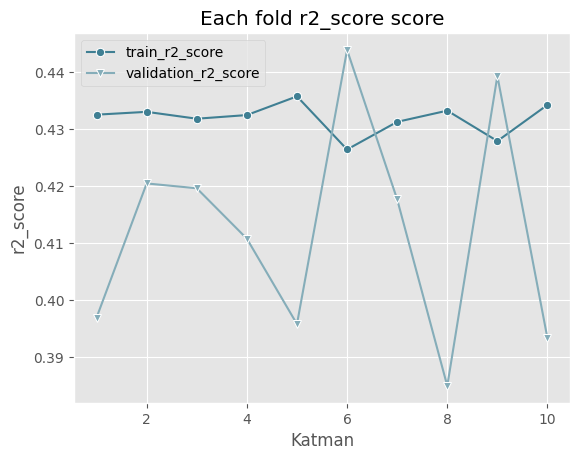

In [196]:
# Metrik R2

kf = KFold(n_splits=10,shuffle=True,random_state=42)
xgb_model, xgb_final_test_r2_score, xgb_r2_scores_df,xgb_y_pred_test = train_and_evaluate_model(xgb, X_train, y_train, X_test, y_test, r2_score, kf, plot=True, use_rmse=True)

**XGBoost Regressor Regression Özellik Seçimi**

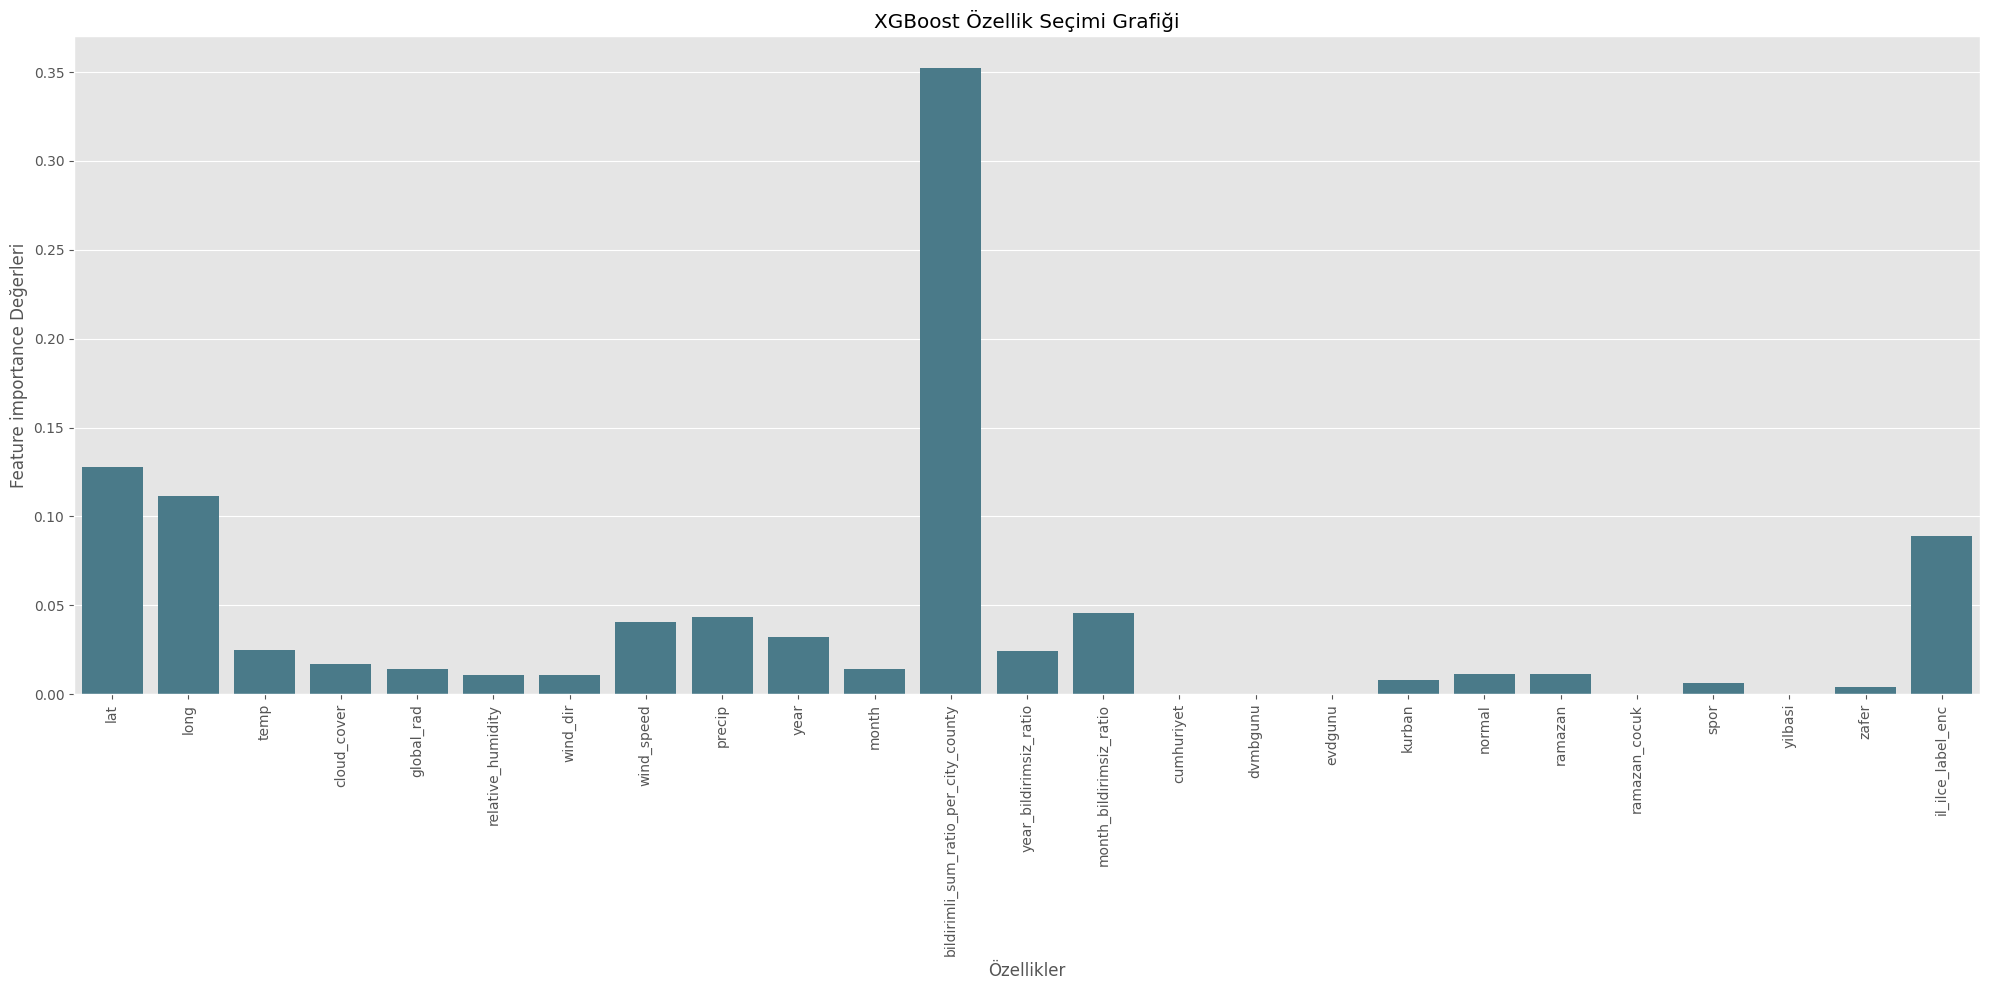

In [197]:
feature_importances = xgb_model.feature_importances_
columns = X_train.columns
plt.figure(figsize=(20,10))
sns.barplot(x=columns, y=feature_importances)
plt.xlabel("Özellikler")
plt.ylabel("Feature importance Değerleri")
plt.title("XGBoost Özellik Seçimi Grafiği")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**!!BURAYI DÜZENLE Modellerin Karşılaştırılması**
- Linear regresyon modeli gecikmeleri 10.49 dakika hata payı (RMSE) ile tahmin etmiştir. R2 0.88 çıkmasıda modelin veriye çok iyi bir şekilde uyduğunu gösterir. Linear regresyon modeli bu veri setinde iyi performans göstermiştir diyebiliriz. 2 metrik içinde eğitim, doğrulama ve test verilerinin birbirine yakın olmasıda modelin dengeli ve genelleştirilebilir olduğunu herhangi bir overfitting underfitting durumu olmadığını gösterebilir.
  
- XGBoost Regressor modeli gecikmeleri 8.77 dakika hata payı (RMSE) ile tahmin etmiştir. R2 0.92 çıkmasıda modelin veriye mükemmele yakın bir şekilde uyduğunu gösterir. XGBoost Regressor modeli bu veri setinde çok iyi performans göstermiştir. 2 metrik içinde eğitim, doğrulama ve test verilerini incelediğimizde yine dengeli görünmektedir. Test sonucunun eğitim sonucundan biraz yüksek olması beklenen bir durumdur. Xgboostun parametrelerinin ayarlanmasına biraz daha vakit harcanıp daha da iyi sonuçlar elde edilebilir.
- Modellerin metriklere göre karşılaştırılması görseli aşağıda sunulmuştur.

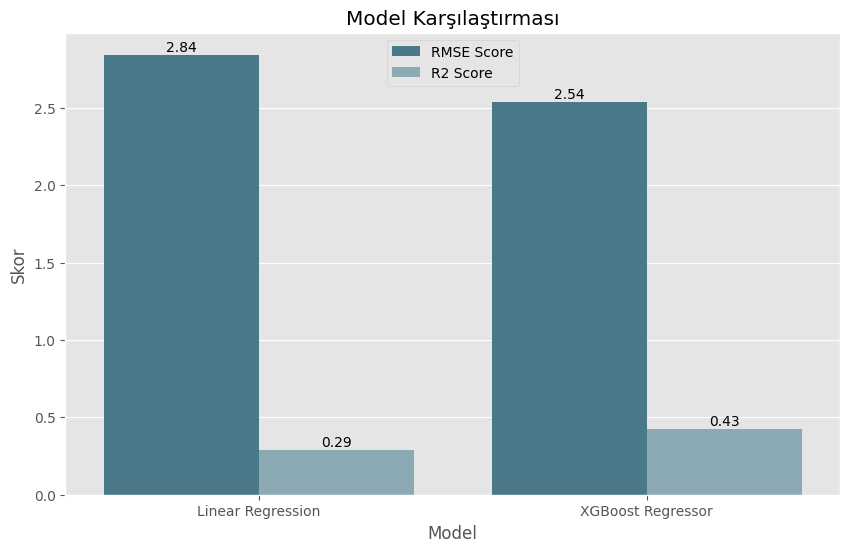

In [198]:
scores_data = {
    "Model": ["Linear Regression"] * 2 + ["XGBoost Regressor"] * 2,
    "Metrik": ["RMSE Score", "R2 Score"] * 2,
    "Skor": [lr_final_test_mae_score, lr_final_test_r2_score, xgb_final_test_mae_score, xgb_final_test_r2_score]
}
scores_df = pd.DataFrame(scores_data)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Model", y="Skor", hue="Metrik", data=scores_df)
for container in ax.containers:
    ax.bar_label(container, fmt='%0.2f', label_type="edge")
plt.title("Model Karşılaştırması")
plt.ylabel("Skor")
plt.xlabel("Model")
plt.legend(loc="upper center")
plt.show()

**Son Tahmin ve Submission Oluşturulması**

In [199]:
final_test = new_test[X_train.columns]
new_test.loc[:, "bildirimsiz_sum"] = xgb_model.predict(final_test)
new_test["bildirimsiz_sum"] = np.expm1(new_test["bildirimsiz_sum"])
new_test["bildirimsiz_sum"] = round(new_test["bildirimsiz_sum"]).astype(int)
new_test[["unique_id","bildirimsiz_sum"]].head()

unique_id  bildirimsiz_sum
0     2024-01-04-manisa-akhisar                5
1    2024-01-04-manisa-alasehir                4
2     2024-01-04-manisa-demirci                2
3  2024-01-04-manisa-golmarmara                1
4      2024-01-04-manisa-gordes                3

In [200]:
new_test.groupby("month")["bildirimsiz_sum"].sum().reset_index()

month  bildirimsiz_sum
0      1             5790

In [201]:
new_train["bildirimsiz_sum"] = np.expm1(new_train["bildirimsiz_sum"])
new_train.groupby("month")["bildirimsiz_sum"].sum().reset_index()

month  bildirimsiz_sum
0       1          24822.0
1       2          24105.0
2       3          20502.0
3       4          21049.0
4       5          18795.0
5       6          26100.0
6       7          28610.0
7       8          24044.0
8       9          17847.0
9      10          19482.0
10     11          27349.0
11     12          23156.0

In [202]:
new_test[["unique_id","bildirimsiz_sum"]].to_csv('submissions/submission33.csv',index=False)